# **2 Unsupervised Learning: Identifying Trade Patterns (40)**

## **1. Normalize the trade data (e.g., using min–max scaling or standardization) to make sector level measures comparable across countries . Aggregate export values into broad two-digit product categories (the first two digits of the HS code) for 2016–2018 and convert them into export-share vectors for each country. (10 points)**

### 步骤1.1：数据读取与时间筛选

#### 读取2016-2018年的贸易数据文件

In [1]:
# --- 步骤 1.1.1：读取2016-2018年贸易数据 ---
import pandas as pd
import os

# 定义路径
base_dir = os.path.join(os.path.dirname(os.getcwd()), 'raw', 'trade_data')
years = [2016, 2017, 2018]
dataframes = []

for year in years:
    filename = f'baci_hs12_y{year}_v202001.csv'
    filepath = os.path.join(base_dir, filename)
    
    print(f"正在读取 {filename}...")
    df = pd.read_csv(filepath, low_memory=False)  # 防止 dtype warning
    dataframes.append(df)

print("所有年份数据已成功读取。")

正在读取 baci_hs12_y2016_v202001.csv...
正在读取 baci_hs12_y2017_v202001.csv...
正在读取 baci_hs12_y2018_v202001.csv...
所有年份数据已成功读取。


#### 筛选仅保留指定年份的数据（2016-2018）

In [2]:
# --- 步骤 1.1.2：筛选并验证仅保留2016-2018年数据 ---
# 合并所有年份数据
df_trade = pd.concat(dataframes, ignore_index=True)

# 检查数据中的年份列 't' 是否都在 2016-2018 范围内
print("\n--- 检查年份范围 ---")
unique_years = df_trade['t'].unique()
print(f"数据中包含的年份: {sorted(unique_years)}")

# 筛选仅保留 2016-2018 年的数据（理论上应该全部满足）
df_trade_filtered = df_trade[df_trade['t'].isin([2016, 2017, 2018])]

if len(df_trade_filtered) == len(df_trade):
    print("所有数据均属于 2016-2018 年，无需进一步筛选。")
else:
    print("发现非目标年份数据，已剔除。")
    print(f"原数据行数: {len(df_trade)}, 剔除后行数: {len(df_trade_filtered)}")

# 更新主DataFrame
df_trade = df_trade_filtered.copy()

print(f"当前数据集包含 {len(df_trade)} 行记录。")


--- 检查年份范围 ---
数据中包含的年份: [np.int64(2016), np.int64(2017), np.int64(2018)]
所有数据均属于 2016-2018 年，无需进一步筛选。
当前数据集包含 24025656 行记录。


#### 验证数据完整性，检查缺失值和异常值

In [3]:
# 步骤 1.1.3：验证数据完整性，检查缺失值和异常值

# 1. 检查缺失值
print("缺失值检查")
missing = df_trade.isnull().sum()
print(missing[missing > 0])  # 只显示有缺失的列

if missing.sum() == 0:
    print("没有发现缺失值")

# 2. 检查异常值

# (a) 检查贸易价值 v 和数量 q 是否为负数
negative_value = df_trade[df_trade['v'] < 0]
negative_quantity = df_trade[df_trade['q'] < 0]

if len(negative_value) > 0:
    print(f"发现 {len(negative_value)} 条贸易价值 v 为负数")
else:
    print("贸易价值 v 无负数")

if len(negative_quantity) > 0:
    print(f"发现 {len(negative_quantity)} 条贸易数量 q 为负数")
else:
    print("贸易数量 q 无负数")

# (b) 检查国家代码 i 和 j 是否合理
invalid_i = df_trade[(df_trade['i'] < 1) | (df_trade['i'] > 999)]
invalid_j = df_trade[(df_trade['j'] < 1) | (df_trade['j'] > 999)]

if len(invalid_i) > 0:
    print(f"发现 {len(invalid_i)} 条 exporter 国家代码 i 异常")
else:
    print("exporter 国家代码 i 合理")

if len(invalid_j) > 0:
    print(f"发现 {len(invalid_j)} 条 importer 国家代码 j 异常")
else:
    print("importer 国家代码 j 合理")

# (c) 检查 HS6 产品代码 k 长度是否为 6 位
df_trade['k_str'] = df_trade['k'].astype(str)
df_trade['k_len'] = df_trade['k_str'].str.len()

incorrect_length = df_trade[df_trade['k_len'] != 6]
if len(incorrect_length) > 0:
    print(f"发现 {len(incorrect_length)} 条 HS6 产品代码 k 长度不为 6")
    print("将自动补前导零")
    df_trade['k'] = df_trade['k_str'].str.zfill(6).astype(int)  # 补零并转回 int
else:
    print("HS6 产品代码 k 长度均为 6 位")

# 清理临时列
df_trade.drop(columns=['k_str', 'k_len'], inplace=True)

# 输出最终统计
print(f"最终数据状态")
print(f"总行数 {len(df_trade)}")
print(f"年份分布 {df_trade['t'].value_counts().sort_index()}")

# 保存清洗后的数据到
results_path = os.path.join(os.path.dirname(os.getcwd()), 'results', 'q2', 'q2_cleaned_trade_data_2016_2018.csv')
df_trade.to_csv(results_path, index=False)
print(f"清洗后的数据已保存至 {results_path}")

缺失值检查
Series([], dtype: int64)
没有发现缺失值
贸易价值 v 无负数
贸易数量 q 无负数
exporter 国家代码 i 合理
importer 国家代码 j 合理
发现 1157016 条 HS6 产品代码 k 长度不为 6
将自动补前导零
最终数据状态
总行数 24025656
年份分布 t
2016    7892508
2017    8132873
2018    8000275
Name: count, dtype: int64
清洗后的数据已保存至 d:\桌面\Github\course5020-finalproject\results\q2\q2_cleaned_trade_data_2016_2018.csv


### 步骤1.2：HS代码标准化处理

#### 读取产品代码参考文件

In [4]:
# 步骤 1.2.1：读取产品代码参考文件
import pandas as pd

# 定义产品代码文件路径
product_code_file = os.path.join(base_dir, 'product_codes_hs12_V202001.csv')

# 读取产品代码参考文件
print("正在读取产品代码参考文件...")
df_products = pd.read_csv(product_code_file)

# 展示前几行以了解结构
print("产品代码文件前5行预览：")
print(df_products.head())

# 检查关键列是否存在 (假设列名为 'code' 和 'description')
# 如果列名不同，请相应调整
if 'code' in df_products.columns and 'description' in df_products.columns:
    print("产品代码文件读取成功，包含 'code' 和 'description' 列")
else:
    # 尝试打印列名以便调试
    print(f"产品代码文件的列名: {list(df_products.columns)}")
    print("请检查列名是否符合预期，并在代码中进行调整")

print("步骤 1.2.1 完成")

正在读取产品代码参考文件...
产品代码文件前5行预览：
    code                                        description
0  10121           Horses: live, pure-bred breeding animals
1  10129  Horses: live, other than pure-bred breeding an...
2  10130                                        Asses: live
3  10190                            Mules and hinnies: live
4  10221           Cattle: live, pure-bred breeding animals
产品代码文件读取成功，包含 'code' 和 'description' 列
步骤 1.2.1 完成


#### 将HS6代码统一格式化为6位字符串并处理前导零

In [5]:
# 假设 df_trade 是上一步处理好的贸易数据 DataFrame

# 检查 df_trade 是否已定义 (从上一步继承)
try:
    # 尝试访问 df_trade 的列来确认其存在
    _ = df_trade.shape 
except NameError:
    print("错误: 上一步的贸易数据 DataFrame 'df_trade' 未找到 请确保上一步已成功运行")
    raise

print("开始处理HS6代码格式...")

# 将贸易数据中的 HS6 代码 (k 列) 转换为字符串
df_trade['k_str'] = df_trade['k'].astype(str)

# 检查转换前的长度分布 (可选，用于诊断)
print("HS6代码字符串长度分布 (处理前):")
print(df_trade['k_str'].str.len().value_counts().sort_index())

# 使用 zfill(6) 确保所有HS6代码都是6位，不足的补前导零
df_trade['hs6_code'] = df_trade['k_str'].str.zfill(6)

# 验证处理结果
print("HS6代码字符串长度分布 (处理后):")
print(df_trade['hs6_code'].str.len().value_counts().sort_index())

# 检查是否有非6位的代码 (理论上应该没有了)
non_six_digit = df_trade[df_trade['hs6_code'].str.len() != 6]
if len(non_six_digit) > 0:
    print(f"警告: 仍有 {len(non_six_digit)} 条记录的 hs6_code 长度不是6")
else:
    print("所有HS6代码均已成功格式化为6位字符串")

# 删除临时的 k_str 列
df_trade.drop(columns=['k_str'], inplace=True)

print("步骤 1.2.2 完成")

开始处理HS6代码格式...
HS6代码字符串长度分布 (处理前):
k_str
5     1157016
6    22868640
Name: count, dtype: int64
HS6代码字符串长度分布 (处理后):
hs6_code
6    24025656
Name: count, dtype: int64
所有HS6代码均已成功格式化为6位字符串
步骤 1.2.2 完成


#### 提取HS2大类代码（取前2位）

In [6]:
# 从已格式化的6位HS6代码中提取前两位作为HS2代码
print("正在提取HS2大类代码...")
df_trade['hs2_code'] = df_trade['hs6_code'].str[:2]

# 验证提取结果
print("提取的HS2代码示例:")
print(df_trade[['hs6_code', 'hs2_code']].head(10))

# 检查HS2代码的唯一值数量和示例
unique_hs2 = df_trade['hs2_code'].nunique()
print(f"总共提取到 {unique_hs2} 个不同的HS2大类代码")

print("常见的HS2代码及其出现次数:")
print(df_trade['hs2_code'].value_counts().head(10))

print("步骤 1.2.3 完成")

正在提取HS2大类代码...
提取的HS2代码示例:
  hs6_code hs2_code
0   080132       08
1   130190       13
2   370239       37
3   970600       97
4   480300       48
5   870333       87
6   850300       85
7   851110       85
8   080620       08
9   081310       08
总共提取到 96 个不同的HS2大类代码
常见的HS2代码及其出现次数:
hs2_code
84    3358280
85    2211694
90    1106282
39     935776
62     871115
73     861122
61     777339
29     679567
87     589153
48     523004
Name: count, dtype: int64
步骤 1.2.3 完成


完成以上三个步骤后，你的 df_trade DataFrame 中就会新增三列：
- hs6_code: 格式化为6位字符串的HS6产品代码。
- hs2_code: 从hs6_code中提取的前2位字符，代表HS2大类。

### 步骤1.3：数据聚合与份额计算

#### 按"国家-年份-HS2类别"聚合出口价值

In [7]:
# 假设 df_trade 是包含 hs2_code 列的贸易数据 DataFrame

print("开始按 国家-年份-HS2类别 聚合出口价值...")

# 按 exporter (i), year (t), hs2_code 分组，并对出口价值 (v) 求和
df_agg_hs2 = df_trade.groupby(['i', 't', 'hs2_code'])['v'].sum().reset_index()

# 重命名列以便理解
df_agg_hs2.rename(columns={'i': 'country_id', 't': 'year', 'v': 'hs2_export_value'}, inplace=True)

print("聚合完成 预览前5行:")
print(df_agg_hs2.head())

total_rows = len(df_agg_hs2)
print(f"聚合后的数据包含 {total_rows} 行")

print("步骤 1.3.1 完成")

开始按 国家-年份-HS2类别 聚合出口价值...
聚合完成 预览前5行:
   country_id  year hs2_code  hs2_export_value
0           4  2016       01        207.374000
1           4  2016       02         44.010580
2           4  2016       03         25.381277
3           4  2016       04         61.357530
4           4  2016       05       2241.569879
聚合后的数据包含 52260 行
步骤 1.3.1 完成


#### 计算每个国家每年的总出口额

In [8]:
print("开始计算每个国家每年的总出口额...")

# 按 exporter (i) 和 year (t) 分组，对所有 hs2_export_value 求和
df_total_export = df_agg_hs2.groupby(['country_id', 'year'])['hs2_export_value'].sum().reset_index()

# 重命名列以便理解
df_total_export.rename(columns={'hs2_export_value': 'total_export_value'}, inplace=True)

print("国家每年总出口额计算完成 预览前5行:")
print(df_total_export.head())

print("步骤 1.3.2 完成")

开始计算每个国家每年的总出口额...
国家每年总出口额计算完成 预览前5行:
   country_id  year  total_export_value
0           4  2016        1.020542e+06
1           4  2017        1.029783e+06
2           4  2018        1.270528e+06
3           8  2016        2.172901e+06
4           8  2017        2.396768e+06
步骤 1.3.2 完成


#### 计算各HS2类别在各国出口中的份额

In [9]:
import numpy as np # 导入 numpy 用于处理 Inf 值

print("开始计算各HS2类别在各国出口中的份额...")

# 将聚合后的HS2数据与国家总出口额数据合并
df_share_calc = pd.merge(df_agg_hs2, df_total_export, on=['country_id', 'year'], how='left')

# 计算份额: HS2类别出口额 / 国家总出口额
# 注意处理总出口额为0的情况，避免除以零错误
df_share_calc['share'] = df_share_calc['hs2_export_value'] / df_share_calc['total_export_value']

# 检查是否有 NaN 或 Inf (由除以零产生)
nan_shares = df_share_calc['share'].isna().sum()
inf_shares = np.isinf(df_share_calc['share']).sum()
if nan_shares > 0 or inf_shares > 0:
    print(f"警告: 计算份额时发现 {nan_shares} 个 NaN 和 {inf_shares} 个 Inf 值 可能由总出口额为0导致")
    # 可以选择填充为0或其他处理方式
    df_share_calc['share'].fillna(0, inplace=True)
    df_share_calc['share'].replace([np.inf, -np.inf], 0, inplace=True)
    print("已将 NaN 和 Inf 值替换为 0")

print("份额计算完成 预览前5行:")
print(df_share_calc[['country_id', 'year', 'hs2_code', 'hs2_export_value', 'total_export_value', 'share']].head())

print("步骤 1.3.3 完成")

开始计算各HS2类别在各国出口中的份额...
份额计算完成 预览前5行:
   country_id  year hs2_code  hs2_export_value  total_export_value     share
0           4  2016       01        207.374000        1.020542e+06  0.000203
1           4  2016       02         44.010580        1.020542e+06  0.000043
2           4  2016       03         25.381277        1.020542e+06  0.000025
3           4  2016       04         61.357530        1.020542e+06  0.000060
4           4  2016       05       2241.569879        1.020542e+06  0.002196
步骤 1.3.3 完成


#### 构建国家出口份额矩阵

In [10]:
print("开始构建国家出口份额矩阵...")

# 重塑数据，使其成为宽格式：行=国家-年份，列=HS2类别，值=份额
# pivot_table 会自动处理重复的 (country_id, year, hs2_code) 组合，默认使用 mean，但因为我们已经聚合过了，所以是唯一的
df_share_matrix = df_share_calc.pivot_table(index=['country_id', 'year'], columns='hs2_code', values='share', fill_value=0)

# 将多级索引展平（可选，但通常保持多级索引更清晰）
# df_share_matrix.reset_index(inplace=True)

print("国家出口份额矩阵构建完成")
print(f"矩阵形状 (行数=国家-年份组合数, 列数=HS2类别数): {df_share_matrix.shape}")

print("矩阵列 (HS2类别) 示例 (前10个):")
print(list(df_share_matrix.columns)[:10])

print("矩阵索引 (国家-年份) 示例 (前5个):")
print(df_share_matrix.index.names)
print(df_share_matrix.index[:5].tolist())

# 保存份额矩阵到 q2文件夹
matrix_save_path = os.path.join(os.path.dirname(os.getcwd()), 'results', 'q2', 'q2_country_hs2_share_matrix.csv')

# 保留多级索引
df_share_matrix.to_csv(matrix_save_path)
print(f"国家出口份额矩阵已保存至 {matrix_save_path}")

print("步骤 1.3.4 完成")

开始构建国家出口份额矩阵...
国家出口份额矩阵构建完成
矩阵形状 (行数=国家-年份组合数, 列数=HS2类别数): (664, 96)
矩阵列 (HS2类别) 示例 (前10个):
['01', '02', '03', '04', '05', '06', '07', '08', '09', '10']
矩阵索引 (国家-年份) 示例 (前5个):
['country_id', 'year']
[(4, 2016), (4, 2017), (4, 2018), (8, 2016), (8, 2017)]
国家出口份额矩阵已保存至 d:\桌面\Github\course5020-finalproject\results\q2\q2_country_hs2_share_matrix.csv
步骤 1.3.4 完成


完成以上四个步骤后，你就得到了一个核心产出：
- df_share_matrix，这是一个以 (country_id, year) 为行索引，以 hs2_code 为列索引的出口份额矩阵。
- 这个矩阵是后续进行聚类分析的基础。

### 步骤 1.4：数据标准化

#### 准备数据与选择标准化方法

In [11]:
# 假设 df_share_matrix 是上一步构建的国家-年份 HS2 份额矩阵

print("开始进行数据标准化...")

# 1. 准备数据
# df_share_matrix 的索引是 MultiIndex ['country_id', 'year']
# 我们需要对特征列 (即 HS2 codes) 进行标准化
# 为了应用 sklearn 的 StandardScaler 或 MinMaxScaler，
# 我们需要将数据从 DataFrame 转换为 NumPy array
# 但同时也要保留索引信息，以便后续还原

# 提取数值数据 (不包括索引)
X = df_share_matrix.values

# 获取索引和列名，用于后续重建 DataFrame
index = df_share_matrix.index
columns = df_share_matrix.columns

print(f"待标准化的数据形状: {X.shape}")
print(f"数据样本 (前2行): \n{X[:2]}")

# 2. 选择标准化方法
# 方法1: Min-Max 标准化 (推荐用于份额数据，将其缩放到 [0, 1])
# from sklearn.preprocessing import MinMaxScaler
# scaler = MinMaxScaler()

# 方法2: Z-score 标准化 (均值为0，标准差为1)
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

print("已选择 Z-score 标准化 (StandardScaler)")
# 如果想切换到 Min-Max，请注释掉 StandardScaler 相关行，并取消注释 MinMaxScaler 相关行

print("步骤 1.4.1 完成")

开始进行数据标准化...
待标准化的数据形状: (664, 96)
数据样本 (前2行): 
[[2.03199902e-04 4.31247195e-05 2.48703934e-05 6.01225037e-05
  2.19645076e-03 1.89017240e-05 6.74977127e-02 3.15108781e-01
  3.03215837e-02 6.24586539e-05 5.64850921e-05 3.15127308e-02
  6.94427575e-02 6.16522947e-04 0.00000000e+00 1.58151283e-06
  1.04718707e-04 0.00000000e+00 2.44691363e-04 7.13816832e-04
  8.32613052e-05 4.11849850e-05 1.02749838e-04 4.30225422e-04
  2.89768900e-02 4.45925399e-05 5.50713818e-02 1.81208030e-05
  1.84573418e-03 2.14558574e-04 0.00000000e+00 4.92779337e-05
  7.13902497e-04 7.80303842e-05 0.00000000e+00 0.00000000e+00
  1.09843611e-06 1.14295289e-04 1.96389184e-03 3.94363809e-05
  9.30985320e-03 2.29549347e-04 4.14915417e-03 1.66859870e-03
  0.00000000e+00 3.11501195e-06 1.14052891e-04 4.08349203e-04
  6.97661508e-04 7.94292771e-04 4.91496356e-03 5.68895811e-02
  3.20986352e-05 1.34633458e-04 4.00468354e-05 5.82580460e-05
  9.31507725e-03 3.99159082e-05 3.83573236e-04 0.00000000e+00
  3.17549711e-04 2.7707

#### 执行标准化 **(Z-score)**

In [12]:
# 对数据进行拟合和转换
X_scaled = scaler.fit_transform(X)

print("标准化完成")
print(f"标准化后数据形状: {X_scaled.shape}")

# 检查标准化效果 (查看前几行)
print("标准化后数据样本 (前2行):")
print(X_scaled[:2])

# 对于 Z-score 标准化，可以简单验证一下均值和方差
if isinstance(scaler, StandardScaler):
    print("\n验证 Z-score 标准化效果 (对第一列):")
    col_mean = X_scaled[:, 0].mean()
    col_std = X_scaled[:, 0].std()
    print(f"  第一列标准化后均值: {col_mean:.6f} (应接近 0)")
    print(f"  第一列标准化后标准差: {col_std:.6f} (应接近 1)")

print("步骤 1.4.2 完成")

标准化完成
标准化后数据形状: (664, 96)
标准化后数据样本 (前2行):
[[-0.12733557 -0.28044418 -0.37942484 -0.26708613  0.43580944 -0.18107813
   2.07673535  3.92500761  0.12729675 -0.2961081  -0.27657993  0.63711176
   9.14609685  0.60036595 -0.41280587 -0.20641483 -0.2462645  -0.18616297
  -0.61011274 -0.35464454 -0.55537475 -0.38730945 -0.2896115  -0.20228387
   0.26138846 -0.36669197 -0.39600339 -0.2450451  -0.3258947  -0.39478423
  -0.22900162 -0.6225289  -0.26791518 -0.52464661 -0.31299928 -0.280106
  -0.24770219 -0.34424154 -0.73503609 -0.38462633  1.2664641  -0.39583949
   2.10823921 -0.26575464 -0.08494445 -0.26976469 -0.1857422  -0.45767719
  -0.11476153  1.67371334  0.74227976  2.1647703  -0.15873431 -0.17924699
  -0.20620196 -0.44779751  1.15003917 -0.19049836 -0.07835089 -0.34581598
  -0.29736978 -0.39400089 -0.26579507 -0.32245906 -0.35936395 -0.18966024
  -0.1145081  -0.18493341 -0.38676646 -0.57928814  1.13951623  0.03952564
  -0.50999761 -0.24056178 -0.14541041 -0.316434   -0.32899145 -0.1165871

#### 重构标准化后的DataFrame并保存

In [13]:
# 使用标准化后的 NumPy array 和原始的索引、列名来创建新的 DataFrame
df_normalized = pd.DataFrame(X_scaled, index=index, columns=columns)

print("标准化后的 DataFrame 已创建")
print("标准化后数据预览:")
print(df_normalized.head())

# 保存标准化后的数据到 resutls/q2文件夹
normalized_save_path = os.path.join(os.path.dirname(os.getcwd()), 'results', 'q2', 'q2_normalized_country_hs2_share_matrix.csv')
df_normalized.to_csv(normalized_save_path)
print(f"标准化后的国家出口份额矩阵已保存至 {normalized_save_path}")

print("步骤 1.4.3 完成")

# (可选) 如果需要标准化后的平均国家向量 (忽略年份)
# df_avg_normalized_vector = df_normalized.groupby(level='country_id').mean()
# avg_normalized_save_path = os.path.join(os.path.dirname(os.getcwd()), 'results', 'q2', 'q2_normalized_country_avg_hs2_share_vector.csv')
# df_avg_normalized_vector.to_csv(avg_normalized_save_path)
# print(f"标准化后的平均国家向量已保存至 {avg_normalized_save_path}")

标准化后的 DataFrame 已创建
标准化后数据预览:
hs2_code               01        02        03        04        05        06  \
country_id year                                                               
4          2016 -0.127336 -0.280444 -0.379425 -0.267086  0.435809 -0.181078   
           2017 -0.092086 -0.262206 -0.379553 -0.261946  1.499321 -0.180630   
           2018 -0.089905 -0.281900 -0.379530 -0.266995  1.507048 -0.146694   
8          2016 -0.121860 -0.232964 -0.311032 -0.234571  0.272912 -0.133853   
           2017 -0.120784 -0.236238 -0.303367 -0.236445  0.237404 -0.142633   

hs2_code               07        08        09        10  ...        88  \
country_id year                                          ...             
4          2016  2.076735  3.925008  0.127297 -0.296108  ... -0.210347   
           2017  2.634778  4.960941  0.277874 -0.289345  ... -0.190280   
           2018  3.254409  5.137188  0.217832 -0.279989  ... -0.182786   
8          2016  0.296776 -0.194006 -0.251493 

##  **2. Apply K-means or hierarchical clustering to group countries based on these HS2 export-share vectors (10 points).**

### 步骤2.1：聚类方法选择与参数确定

#### 准备用于聚类的国家向量数据

In [14]:
# 假设 df_normalized 是上一步标准化后的国家-年份 HS2 份额矩阵

print("准备用于聚类的国家向量数据...")

# 为了对国家进行聚类，我们需要为每个国家生成一个向量
# 一种常用方法是计算每个国家在三年期间的平均 HS2 份额向量
# 这可以通过对 MultiIndex 的 'country_id' 层进行分组并求平均值得到

df_country_vectors = df_normalized.groupby(level='country_id').mean()

print("国家平均向量计算完成")
print(f"国家向量矩阵形状 (行=国家数, 列=HS2类别数): {df_country_vectors.shape}")
print("国家向量数据预览 (前5个国家):")
print(df_country_vectors.head())

# 将数据转换为 NumPy array 供聚类算法使用
X_cluster = df_country_vectors.values

print(f"用于聚类的数组形状: {X_cluster.shape}")

# 保存国家向量 
country_vector_path = os.path.join(os.path.dirname(os.getcwd()), 'results', 'q2', 'q2_country_avg_vectors_for_clustering.csv')
df_country_vectors.to_csv(country_vector_path)
print(f"用于聚类的国家平均向量已保存至 {country_vector_path}")

print("步骤 2.1.0 完成")

准备用于聚类的国家向量数据...
国家平均向量计算完成
国家向量矩阵形状 (行=国家数, 列=HS2类别数): (222, 96)
国家向量数据预览 (前5个国家):
hs2_code          01        02        03        04        05        06  \
country_id                                                               
4          -0.103109 -0.274850 -0.379503 -0.265342  1.147393 -0.169467   
8          -0.121608 -0.234804 -0.301534 -0.238467  0.214515 -0.135999   
12         -0.131526 -0.281992 -0.376343 -0.268950 -0.248367 -0.182476   
16         -0.131593 -0.244064  0.287292 -0.259556 -0.159632 -0.182008   
20         -0.123827 -0.273261 -0.379271 -0.252402 -0.214758 -0.180167   

hs2_code          07        08        09        10  ...        88        89  \
country_id                                          ...                       
4           2.655307  4.674379  0.207668 -0.288481  ... -0.194471 -0.286179   
8           0.426329 -0.207285 -0.252048 -0.295204  ... -0.218272 -0.285730   
12         -0.331576 -0.299591 -0.279093 -0.298594  ... -0.223596 -0.283737   
16

#### 选择聚类算法

In [15]:
print("选择聚类算法...")

# 我们可以选择两种主流算法：
# 1. KMeans: 计算速度快，适用于大型数据集，需要预先指定聚类数 k。
# 2. Agglomerative Clustering (层次聚类): 不需要预先指定 k，可以生成树状图(Dendrogram)帮助理解聚类过程和结构。

# --- 选项 1: KMeans ---
from sklearn.cluster import KMeans
# kmeans = KMeans()

# --- 选项 2: Agglomerative Clustering ---
from sklearn.cluster import AgglomerativeClustering
# agg_clustering = AgglomerativeClustering()

print("我们将主要使用 KMeans 进行聚类分析，因为它计算效率高，适合我们的数据规模。")
print("之后，我们可以使用层次聚类的树状图 (Dendrogram) 来辅助验证或理解聚类结果。")

# 最终选择 KMeans 作为主要聚类器
chosen_algorithm = "KMeans"
print(f"选定的聚类算法: {chosen_algorithm}")

print("步骤 2.1.1 完成")

选择聚类算法...
我们将主要使用 KMeans 进行聚类分析，因为它计算效率高，适合我们的数据规模。
之后，我们可以使用层次聚类的树状图 (Dendrogram) 来辅助验证或理解聚类结果。
选定的聚类算法: KMeans
步骤 2.1.1 完成


#### 确定最佳聚类数量 (肘部法则 & 轮廓系数)

开始确定最佳聚类数量...
计算不同 k 值下的评估指标...
  正在计算 k=2...


c:\Users\zjyeah\.conda\envs\5020_env\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\zjyeah\.conda\envs\5020_env\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\zjyeah\.conda\envs\5020_env\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\zjyeah\.conda\envs\5020_env\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning:

    k=2, Inertia=16801.39, Silhouette Score=0.0912
  正在计算 k=3...
    k=3, Inertia=16394.40, Silhouette Score=0.0753
  正在计算 k=4...
    k=4, Inertia=15834.80, Silhouette Score=0.0910
  正在计算 k=5...
    k=5, Inertia=15497.00, Silhouette Score=0.0797
  正在计算 k=6...
    k=6, Inertia=15108.09, Silhouette Score=0.0947
  正在计算 k=7...
    k=7, Inertia=14984.84, Silhouette Score=0.0509
  正在计算 k=8...
    k=8, Inertia=14549.71, Silhouette Score=0.0311
  正在计算 k=9...
    k=9, Inertia=14301.36, Silhouette Score=0.0027
  正在计算 k=10...


c:\Users\zjyeah\.conda\envs\5020_env\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


    k=10, Inertia=13775.15, Silhouette Score=-0.0048
所有 k 值评估完成


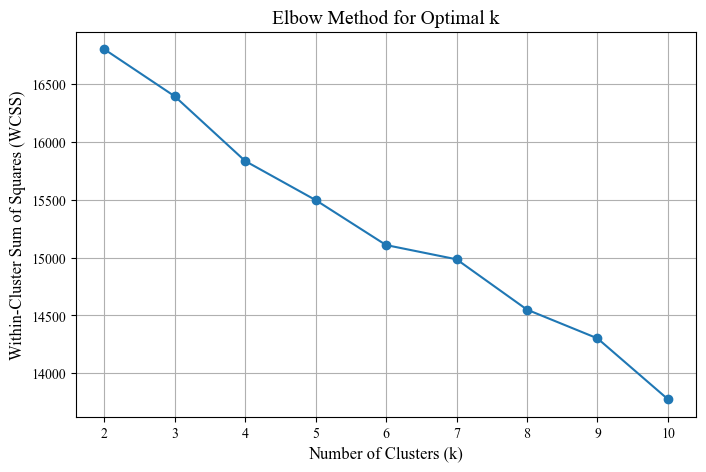

Elbow Method plot saved to d:\桌面\Github\course5020-finalproject\results\q2\q2_elbow_method_plot.png


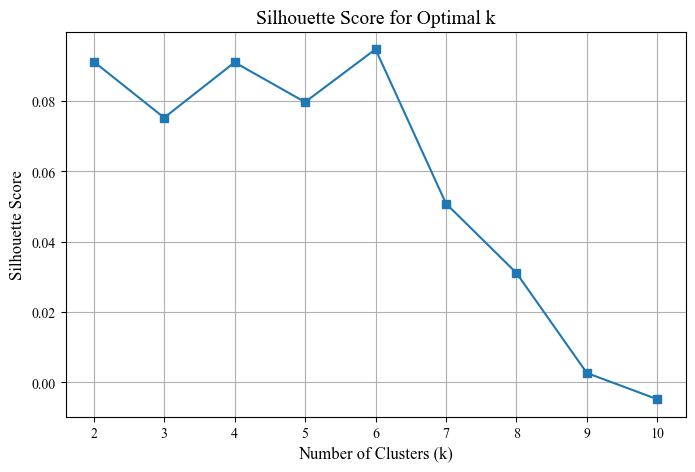

Silhouette Score plot saved to d:\桌面\Github\course5020-finalproject\results\q2\q2_silhouette_score_plot.png

--- 结果分析 ---
肘部法则:
  寻找下降速率显著变化的'肘点'。
  当前WCSS值: ['16801.39', '16394.40', '15834.80', '15497.00', '15108.09', '14984.84', '14549.71', '14301.36', '13775.15']


In [16]:
# 步骤 2.1.2：确定最佳聚类数量 (肘部法则 & 轮廓系数) - 符合SCI规范

from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import matplotlib

# 打印开始信息
print("开始确定最佳聚类数量...")

# 设置 matplotlib 全局字体为 Times New Roman
matplotlib.rcParams['font.family'] = 'Times New Roman'

# 定义要测试的聚类数 k 的范围
k_range = range(2, 11) # 通常从2开始，测试到一个合理的上限，比如10或15

# 存储结果的列表
inertias = []         # 用于肘部法则 (WCSS - Within-Cluster Sum of Squares)
silhouette_scores = [] # 用于轮廓系数

# 计算不同 k 值下的评估指标
print("计算不同 k 值下的评估指标...")
for k in k_range:
    print(f"  正在计算 k={k}...")
    # 使用 KMeans 训练模型
    kmeans_temp = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans_temp.fit(X_cluster)
    
    # 计算 WCSS (惯性 inertia_) 用于肘部法则
    inertias.append(kmeans_temp.inertia_)
    
    # 计算轮廓系数 Silhouette Score
    labels_temp = kmeans_temp.labels_
    sil_score = silhouette_score(X_cluster, labels_temp)
    silhouette_scores.append(sil_score)
    print(f"    k={k}, Inertia={kmeans_temp.inertia_:.2f}, Silhouette Score={sil_score:.4f}")

print("所有 k 值评估完成")

# 绘制图表 (符合SCI规范)
plt.ioff() # 关闭交互模式

# 图表通用设置
label_fontsize = 12
title_fontsize = 14
tick_fontsize = 10

# 绘制肘部法则图 (Elbow Method Plot)
plt.figure(figsize=(8, 5))
plt.plot(k_range, inertias, marker='o')
plt.title('Elbow Method for Optimal k', fontsize=title_fontsize)
plt.xlabel('Number of Clusters (k)', fontsize=label_fontsize)
plt.ylabel('Within-Cluster Sum of Squares (WCSS)', fontsize=label_fontsize)
plt.xticks(fontsize=tick_fontsize)
plt.yticks(fontsize=tick_fontsize)
plt.grid(True)

# 保存肘部法则图
elbow_plot_path = os.path.join(os.path.dirname(os.getcwd()), 'results', 'q2', 'q2_elbow_method_plot.png')
plt.savefig(elbow_plot_path, dpi=300, bbox_inches='tight') # 高分辨率保存
plt.show()
print(f"Elbow Method plot saved to {elbow_plot_path}")

# 绘制轮廓系数图 (Silhouette Score Plot)
plt.figure(figsize=(8, 5))
plt.plot(k_range, silhouette_scores, marker='s')
plt.title('Silhouette Score for Optimal k', fontsize=title_fontsize)
plt.xlabel('Number of Clusters (k)', fontsize=label_fontsize)
plt.ylabel('Silhouette Score', fontsize=label_fontsize)
plt.xticks(fontsize=tick_fontsize)
plt.yticks(fontsize=tick_fontsize)
plt.grid(True)

# 保存轮廓系数图
silhouette_plot_path = os.path.join(os.path.dirname(os.getcwd()), 'results', 'q2', 'q2_silhouette_score_plot.png')
plt.savefig(silhouette_plot_path, dpi=300, bbox_inches='tight') # 高分辨率保存
plt.show()
print(f"Silhouette Score plot saved to {silhouette_plot_path}")

# 分析结果
print("\n--- 结果分析 ---")
print("肘部法则:")
print("  寻找下降速率显著变化的'肘点'。")
print(f"  当前WCSS值: {[f'{i:.2f}' for i in inertias]}")

完成以上步骤后，你应该会在 q2 文件夹中看到两个图表：
- q2_elbow_method_plot.png 
- q2_silhouette_score_plot.png

**肘部法则 (Elbow Method)：**
1. WCSS 值随着 k 的增加而单调递减，这是正常的。
2. 观察 ['16801.39', '16394.40', '15834.80', '15497.00', '15108.09', '14984.84', '14549.71', '14301.36', '13775.15'] 这个序列，下降速率似乎在 k=4 到 k=6 之间有所减缓，之后下降又变得平缓了一些。肘部可能出现在 k=4 到 k=6 之间。

**轮廓系数 (Silhouette Score)：**
1. 分数普遍较低，最高分是 k=6 时的 0.0947。
2. 轮廓系数接近 0 甚至为负，表明聚类结构可能不是很紧密或分离度不高。这可能意味着：
- 国家间的贸易模式差异本身比较细微。
- 用于聚类的特征（HS2平均份额）可能不足以捕捉到非常清晰的区分。
- 数据本身的内在结构就不是非常适合分成几个紧密的、分离良好的群组。

**结论：**
- 选择 **k=6** 作为最终的聚类数量，进行下一步的聚类模型训练。

### 步骤 2.2：执行聚类分析

#### 训练最终的KMeans聚类模型

In [17]:
# 假设 X_cluster 是用于聚类的国家向量数据 (来自步骤 2.1.0)
# 假设我们已根据上一步分析确定最佳聚类数 k=6

print("开始训练最终的KMeans聚类模型...")

# 定义最终的聚类数
optimal_k = 6
print(f"使用的聚类数 k = {optimal_k}")

# 创建 KMeans 模型实例
final_kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)

# 在数据上拟合模型
final_kmeans.fit(X_cluster)

# 获取聚类标签
cluster_labels = final_kmeans.labels_

# 获取聚类中心点
cluster_centers = final_kmeans.cluster_centers_

print("最终KMeans模型训练完成")
print(f"聚类标签数组形状: {cluster_labels.shape}")
print(f"聚类中心点数组形状: {cluster_centers.shape}") # (k, n_features)

print("步骤 2.2.1 完成")

开始训练最终的KMeans聚类模型...
使用的聚类数 k = 6
最终KMeans模型训练完成
聚类标签数组形状: (222,)
聚类中心点数组形状: (6, 96)
步骤 2.2.1 完成


c:\Users\zjyeah\.conda\envs\5020_env\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


#### 将聚类标签关联到国家并向量数据

In [18]:
# 假设 df_country_vectors 是包含国家平均向量的 DataFrame (来自步骤 2.1.0)

print("将聚类标签关联到国家数据...")

# 将聚类标签添加到 df_country_vectors DataFrame 中
df_country_with_labels = df_country_vectors.copy()
df_country_with_labels['cluster_label'] = cluster_labels

# 按聚类标签排序，方便查看
df_country_with_labels.sort_values(by='cluster_label', inplace=True)

print("聚类标签已关联")
print("带标签的国家向量数据预览 (前10行):")
print(df_country_with_labels.head(10))

# 查看每个聚类包含的国家数量
print("\n各聚类包含的国家数量:")
cluster_counts = df_country_with_labels['cluster_label'].value_counts().sort_index()
print(cluster_counts)

print("步骤 2.2.2 完成")

将聚类标签关联到国家数据...
聚类标签已关联
带标签的国家向量数据预览 (前10行):
hs2_code          01        02        03        04        05        06  \
country_id                                                               
4          -0.103109 -0.274850 -0.379503 -0.265342  1.147393 -0.169467   
496        -0.126560  0.056096 -0.379420 -0.264576  0.361247 -0.154694   
499        -0.127220  0.542514 -0.377900 -0.241000 -0.230167 -0.159203   
504        -0.126184 -0.278242 -0.102382 -0.110017  0.472577 -0.098425   
508        -0.129442 -0.281781 -0.292193 -0.266762 -0.225438 -0.179431   
512        -0.081341 -0.212252 -0.341039  0.086436 -0.240860 -0.181831   
520        -0.131593 -0.281020 -0.193420  0.613016 -0.248392 -0.171463   
531        -0.130358 -0.279564 -0.182324 -0.252820 -0.247796 -0.181554   
533        -0.130538 -0.251199 -0.349570 -0.252708 -0.238232 -0.182689   
534        -0.095774 -0.282436 -0.379564  0.436508 -0.248392 -0.179600   

hs2_code          07        08        09        10  ...        89 

#### 保存聚类标签和中心点信息

In [19]:
print("开始保存聚类结果...")

# 1. 保存每个国家及其聚类标签
labels_save_path = os.path.join(os.path.dirname(os.getcwd()), 'results', 'q2', 'q2_country_cluster_labels.csv')

# reset_index() 将 MultiIndex 的 'country_id' 变成普通列
df_country_with_labels.reset_index().to_csv(labels_save_path, index=False)
print(f"国家聚类标签已保存至 {labels_save_path}")

# 2. 保存聚类中心点
# 聚类中心点是一个 ndarray，我们将其转换为 DataFrame 以便保存
# 列名应与 df_country_vectors 的列名一致 (即 HS2 codes)
df_cluster_centers = pd.DataFrame(cluster_centers, columns=df_country_vectors.columns)
df_cluster_centers.index.name = 'cluster_id' # 为索引命名

centers_save_path = os.path.join(os.path.dirname(os.getcwd()), 'results', 'q2', 'q2_cluster_centers.csv')
df_cluster_centers.to_csv(centers_save_path)
print(f"聚类中心点已保存至 {centers_save_path}")

print("步骤 2.2.3 完成")

# (可选) 打印聚类中心点摘要
print("\n--- 聚类中心点摘要 ---")
print("每个聚类在各个HS2类别上的代表性份额 (中心点值):")
print(df_cluster_centers)

开始保存聚类结果...
国家聚类标签已保存至 d:\桌面\Github\course5020-finalproject\results\q2\q2_country_cluster_labels.csv
聚类中心点已保存至 d:\桌面\Github\course5020-finalproject\results\q2\q2_cluster_centers.csv
步骤 2.2.3 完成

--- 聚类中心点摘要 ---
每个聚类在各个HS2类别上的代表性份额 (中心点值):
hs2_code          01        02        03        04         05        06  \
cluster_id                                                                
0           0.075426 -0.070734  0.213921 -0.163987  -0.089585 -0.046448   
1          -0.125680 -0.279903 -0.304326 -0.262085  -0.224992 -0.144025   
2          -0.089675  0.121845 -0.277130  0.237275  -0.020672  0.076120   
3          -0.131593 -0.282436  1.187574 -0.268580  11.814207 -0.182689   
4          -0.118234 -0.246506 -0.018487 -0.022240   0.453096 -0.092669   
5          -0.111659 -0.136704 -0.379319 -0.122604  -0.102445 -0.176531   

hs2_code           07        08        09        10  ...        88        89  \
cluster_id                                           ...                       


完成以上三个步骤后，你将获得：
1. 一个训练好的 final_kmeans 模型。
2. 一个包含 cluster_label 列的 df_country_with_labels DataFrame，其中每一行代表一个国家及其被分配的聚类。
3. 两个保存在 q2 文件夹中的 CSV 文件：
- q2_country_cluster_labels.csv：列出每个国家 ID 及其对应的聚类标签。
- q2_cluster_centers.csv：列出每个聚类（共6个）在所有 HS2 类别上的中心点坐标，代表了该聚类的平均贸易模式。

### 步骤 2.3：聚类质量评估

#### 计算聚类内平方和(WCSS)

In [20]:
# WCSS 是 KMeans 算法优化的目标函数，也是肘部法则中使用的指标

print("计算聚类内平方和 (WCSS)...")

# 从训练好的 final_kmeans 模型中直接获取 WCSS (惯性)
wcss = final_kmeans.inertia_

print(f"k=6 时的聚类内平方和 (WCSS): {wcss:.2f}")

# (可选) 与 k=5 和 k=7 的 WCSS 进行比较 (来自步骤 2.1.2)
# 假设我们在步骤 2.1.2 中保存了这些值
# k5_wcss = 15497.00
# k7_wcss = 14984.84
# print(f"对比: k=5 时 WCSS = {k5_wcss:.2f}")
# print(f"对比: k=7 时 WCSS = {k7_wcss:.2f}")
# print("可以看到，增加 k 值会降低 WCSS，但收益递减。")

print("步骤 2.3.1 完成")

计算聚类内平方和 (WCSS)...
k=6 时的聚类内平方和 (WCSS): 15108.09
步骤 2.3.1 完成


#### 计算轮廓系数(Silhouette Score)分析聚类分离程度

In [21]:
from sklearn.metrics import silhouette_score, calinski_harabasz_score

print("计算轮廓系数 (Silhouette Score) 和 Calinski-Harabasz 指数...")

# 1. 轮廓系数 (Silhouette Score)
# 衡量聚类的紧密度和分离度，范围 [-1, 1]，越接近 1 越好
sil_score = silhouette_score(X_cluster, cluster_labels)
print(f"整体轮廓系数 (Silhouette Score): {sil_score:.4f}")

# 2. Calinski-Harabasz 指数 (方差比准则)
# 衡量簇间的分离度与簇内的紧密度之比，值越大越好
ch_score = calinski_harabasz_score(X_cluster, cluster_labels)
print(f"Calinski-Harabasz 指数: {ch_score:.2f}")

# 计算每个样本的轮廓系数，可以更细致地分析
from sklearn.metrics import silhouette_samples
import numpy as np
sample_silhouette_values = silhouette_samples(X_cluster, cluster_labels)
df_silhouette = pd.DataFrame({'country_id': df_country_vectors.index.get_level_values('country_id'), 'silhouette_coefficient': sample_silhouette_values, 'cluster_label': cluster_labels})
df_silhouette.sort_values(by='silhouette_coefficient', ascending=False, inplace=True)
print("\n部分样本轮廓系数 (按从高到低排序):")
print(df_silhouette.head(10))
print("\n部分样本轮廓系数 (按从低到高排序):")
print(df_silhouette.tail(10))

print("步骤 2.3.2 完成")

计算轮廓系数 (Silhouette Score) 和 Calinski-Harabasz 指数...
整体轮廓系数 (Silhouette Score): 0.0947
Calinski-Harabasz 指数: 8.19

部分样本轮廓系数 (按从高到低排序):
     country_id  silhouette_coefficient  cluster_label
110         434                0.264783              0
217         862                0.261639              0
5            24                0.258459              0
92          368                0.257146              0
189         728                0.255252              0
143         566                0.254729              0
7            31                0.253835              0
2            12                0.252608              0
70          266                0.250364              0
38          148                0.240698              0

部分样本轮廓系数 (按从低到高排序):
     country_id  silhouette_coefficient  cluster_label
55          212               -0.035153              2
8            32               -0.036286              2
107         422               -0.037871              4
80          308     

#### 检查聚类结果的稳定性

通过多次运行聚类检查结果稳定性 (Adjusted Rand Index)...
基准聚类标签已设定 (来自 k=6 的首次运行)
  运行第 2 次聚类...
    第 2 次 vs 第 1 次 ARI: 0.7515
  运行第 3 次聚类...
    第 3 次 vs 第 1 次 ARI: 0.4791
  运行第 4 次聚类...
    第 4 次 vs 第 1 次 ARI: 0.6246
  运行第 5 次聚类...
    第 5 次 vs 第 1 次 ARI: 0.6936

稳定性分析结果 (基于 4 次与基准的比较):
  平均 Adjusted Rand Index (ARI): 0.6372
  ARI 标准差: 0.1017
  结论: 聚类结果不够稳定，标签分配可能受初始化影响较大。


c:\Users\zjyeah\.conda\envs\5020_env\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\zjyeah\.conda\envs\5020_env\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\zjyeah\.conda\envs\5020_env\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\zjyeah\.conda\envs\5020_env\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning:

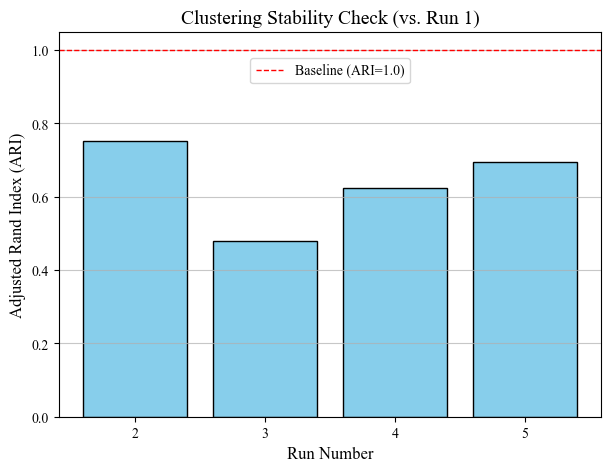

稳定性检查图已保存至 d:\桌面\Github\course5020-finalproject\results\q2\q2_clustering_stability_ari.png


In [22]:
# 步骤 2.3.3：检查聚类结果的稳定性

from sklearn.metrics import adjusted_rand_score
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

print("通过多次运行聚类检查结果稳定性 (Adjusted Rand Index)...")

# --- 设置 matplotlib 全局字体为 Times New Roman ---
matplotlib.rcParams['font.family'] = 'Times New Roman'

# 我们运行 KMeans 多次 (例如 5 次)，并将结果与第一次的结果进行比较
n_runs = 5
ari_scores = []
# 使用第一次运行的结果作为基准
reference_labels = cluster_labels

print(f"基准聚类标签已设定 (来自 k=6 的首次运行)")

for run in range(1, n_runs):
    print(f"  运行第 {run + 1} 次聚类...")
    # 使用相同的 k 和数据，但不同的随机种子
    temp_kmeans = KMeans(n_clusters=optimal_k, random_state=42 + run, n_init=10)
    temp_labels = temp_kmeans.fit_predict(X_cluster)
    
    # 计算调整兰德指数 (ARI)
    # ARI 范围约为 [-1, 1]，1 表示完全一致，接近 0 表示随机一致
    ari = adjusted_rand_score(reference_labels, temp_labels)
    ari_scores.append(ari)
    print(f"    第 {run + 1} 次 vs 第 1 次 ARI: {ari:.4f}")

# 计算平均 ARI 和标准差
mean_ari = np.mean(ari_scores)
std_ari = np.std(ari_scores)

print(f"\n稳定性分析结果 (基于 {n_runs - 1} 次与基准的比较):")
print(f"  平均 Adjusted Rand Index (ARI): {mean_ari:.4f}")
print(f"  ARI 标准差: {std_ari:.4f}")

if mean_ari > 0.9:
    print("  结论: 聚类结果非常稳定。")
elif mean_ari > 0.8:
    print("  结论: 聚类结果较为稳定。")
elif mean_ari > 0.7:
    print("  结论: 聚类结果有一定稳定性，但可能存在轻微变动。")
else:
    print("  结论: 聚类结果不够稳定，标签分配可能受初始化影响较大。")


# --- 可视化 ARI 分数 (符合SCI规范) ---
plt.ioff() # 关闭交互模式

# 图表设置
fig, ax = plt.subplots(figsize=(7, 5)) # 稍微宽一点以适应英文标签
runs_for_plot = list(range(2, n_runs + 1)) # x轴是第2次到第n_runs次

# 绘制柱状图
bars = ax.bar(runs_for_plot, ari_scores, color='skyblue', edgecolor='black')

# 添加基准线 (自身比较 ARI = 1.0)
ax.axhline(y=1.0, color='r', linestyle='--', linewidth=1, label='Baseline (ARI=1.0)')

# 设置图表属性
ax.set_xlabel('Run Number', fontsize=12)
ax.set_ylabel('Adjusted Rand Index (ARI)', fontsize=12)
ax.set_title('Clustering Stability Check (vs. Run 1)', fontsize=14)
ax.set_xticks(runs_for_plot)
ax.set_ylim(0, 1.05)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 0.95), fancybox=True, shadow=False) # 调整图例位置
ax.grid(axis='y', alpha=0.7)

# 设置刻度字体大小
ax.tick_params(axis='both', which='major', labelsize=10)

# 保存图表
stability_plot_path = os.path.join(os.path.dirname(os.getcwd()), 'results', 'q2', 'q2_clustering_stability_ari.png')
plt.savefig(stability_plot_path, dpi=300, bbox_inches='tight')
plt.show() 
print(f"稳定性检查图已保存至 {stability_plot_path}")

1. 平均 Adjusted Rand Index (ARI): 0.6372
- 这是一个中等偏上的稳定水平。它表明虽然每次运行的结果不完全相同（因为 KMeans 对初始化敏感），但它们之间的核心结构有相当大的重叠。我们可以认为聚类结果是基本稳定的，但存在一定的波动性。
2. ARI 标准差: 0.1017
- 属于一个较小的标准差，说明不同运行的结果虽然有差异，但这些差异的幅度是可控的。
3. 柱状图分析
- 聚类结果的稳定性不是均匀的。有些运行（如第2、5次）非常稳定，而有些（如第3次）则相对不稳定。
- 第3次运行的低 ARI 可能是由于 KMeans 在该次迭代中收敛到了一个局部最优解，其簇结构与第一次不同。
- 尽管第3次运行的 ARI 较低，但其他三次运行都达到了 0.6 以上，这表明 k=6 的聚类方案捕捉到了数据中较为稳固的内在结构。

#### **验证**：使用层次聚类 (Agglomerative Clustering) 进行聚类

In [23]:
# 假设 X_cluster 是用于聚类的国家向量数据 (来自步骤 2.1.0)
# 假设 optimal_k = 6 是我们之前确定的最佳聚类数

print("开始使用层次聚类 (Agglomerative Clustering) 进行聚类...")

# 1. 导入必要的库
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score, calinski_harabasz_score

# 2. 创建层次聚类模型实例
# linkage='ward' 是最常用的方法之一，它最小化簇内方差之和
# n_clusters=optimal_k (即 6)
agg_clustering = AgglomerativeClustering(n_clusters=optimal_k, linkage='ward')

# 3. 在数据上拟合模型并预测标签
# 注意：AgglomerativeClustering 没有显式的 fit 方法，fit_predict 是主要接口
agg_labels = agg_clustering.fit_predict(X_cluster)

print("层次聚类完成")
print(f"聚类标签数组形状: {agg_labels.shape}")

# 4. 评估层次聚类结果 (使用与 KMeans 相同的指标)
agg_sil_score = silhouette_score(X_cluster, agg_labels)
agg_ch_score = calinski_harabasz_score(X_cluster, agg_labels)

print(f"\n层次聚类 (k={optimal_k}) 评估指标:")
print(f"  Silhouette Score: {agg_sil_score:.4f}")
print(f"  Calinski-Harabasz Index: {agg_ch_score:.2f}")

# 5. 将层次聚类标签关联到国家数据
df_country_with_agg_labels = df_country_vectors.copy()
df_country_with_agg_labels['agg_cluster_label'] = agg_labels

# 按聚类标签排序，方便查看
df_country_with_agg_labels.sort_values(by='agg_cluster_label', inplace=True)

print("\n带层次聚类标签的国家向量数据预览 (前10行):")
print(df_country_with_agg_labels.head(10))

# 查看每个聚类包含的国家数量
print("\n层次聚类各聚类包含的国家数量:")
agg_cluster_counts = df_country_with_agg_labels['agg_cluster_label'].value_counts().sort_index()
print(agg_cluster_counts)

print("步骤完成")

开始使用层次聚类 (Agglomerative Clustering) 进行聚类...
层次聚类完成
聚类标签数组形状: (222,)

层次聚类 (k=6) 评估指标:
  Silhouette Score: 0.0683
  Calinski-Harabasz Index: 8.55

带层次聚类标签的国家向量数据预览 (前10行):
hs2_code          01        02        03        04         05         06  \
country_id                                                                 
580        -0.131593 -0.282436 -0.379564 -0.166281  -0.248392  -0.182689   
446        -0.131539 -0.274616 -0.366626 -0.011578  -0.243342  -0.182456   
659        -0.026518 -0.282436 -0.371724 -0.270193  -0.137832  -0.117234   
422        -0.095150 -0.193460 -0.376618 -0.164305   1.310696  -0.162436   
162        -0.130420 -0.280243 -0.378884 -0.270193  -0.248392  -0.182689   
662        -0.130115 -0.278949 -0.379464 -0.268844  -0.201408  -0.178314   
776        -0.131593 -0.282436  1.187574 -0.268580  11.814207  -0.182689   
174        -0.125678 -0.282436 -0.379315 -0.270193  -0.248392  -0.111007   
410        -0.131516 -0.279394 -0.365451 -0.264919  -0.190908  -0.179

#### 比较 KMeans 和层次聚类结果

In [24]:
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score

print("开始比较 KMeans 和层次聚类结果...")

# 1. 使用 Adjusted Rand Index (ARI) 比较两种聚类结果
# ARI 范围 [-1, 1]，值越高表示两种划分越相似
ari_comparison = adjusted_rand_score(cluster_labels, agg_labels)
print(f"KMeans 与 层次聚类 的 Adjusted Rand Index (ARI): {ari_comparison:.4f}")

# 2. 使用 Normalized Mutual Information (NMI) 比较两种聚类结果
# NMI 范围 [0, 1]，值越高表示两种划分共享的信息越多
nmi_comparison = normalized_mutual_info_score(cluster_labels, agg_labels)
print(f"KMeans 与 层次聚类 的 Normalized Mutual Information (NMI): {nmi_comparison:.4f}")

# 3. 比较评估指标
print(f"\n--- 聚类质量指标比较 (k={optimal_k}) ---")
print(f"{'Method':<20} {'Silhouette Score':<20} {'CH Index':<15}")
print("-" * 55)
print(f"{'KMeans':<20} {sil_score:<20.4f} {ch_score:<15.2f}")
print(f"{'Agglomerative':<20} {agg_sil_score:<20.4f} {agg_ch_score:<15.2f}")

# 4. 简单分析
print("\n--- 简单分析 ---")
if ari_comparison > 0.8:
    print("  ARI > 0.8: 两种聚类结果高度相似。")
elif ari_comparison > 0.6:
    print("  ARI > 0.6: 两种聚类结果中度相似。")
else:
    print("  ARI <= 0.6: 两种聚类结果差异较大。")

if sil_score > agg_sil_score:
    print("  KMeans 的 Silhouette Score 更高。")
elif agg_sil_score > sil_score:
    print("  层次聚类的 Silhouette Score 更高。")
else:
    print("  两种方法的 Silhouette Score 相同。")

if ch_score > agg_ch_score:
    print("  KMeans 的 CH Index 更高。")
elif agg_ch_score > ch_score:
    print("  层次聚类的 CH Index 更高。")
else:
    print("  两种方法的 CH Index 相同。")

print("步骤完成")

# 保存带有两种标签的 DataFrame
df_both_labels = df_country_vectors.copy()
df_both_labels['kmeans_label'] = cluster_labels
df_both_labels['agg_label'] = agg_labels
both_labels_path = os.path.join(os.path.dirname(os.getcwd()), 'results', 'q2', 'q2_country_both_cluster_labels.csv')
    
df_both_labels.to_csv(both_labels_path)
print(f"\n包含 KMeans 和层次聚类标签的文件已保存至 {both_labels_path}")

开始比较 KMeans 和层次聚类结果...
KMeans 与 层次聚类 的 Adjusted Rand Index (ARI): 0.4811
KMeans 与 层次聚类 的 Normalized Mutual Information (NMI): 0.4747

--- 聚类质量指标比较 (k=6) ---
Method               Silhouette Score     CH Index       
-------------------------------------------------------
KMeans               0.0947               8.19           
Agglomerative        0.0683               8.55           

--- 简单分析 ---
  ARI <= 0.6: 两种聚类结果差异较大。
  KMeans 的 Silhouette Score 更高。
  层次聚类的 CH Index 更高。
步骤完成

包含 KMeans 和层次聚类标签的文件已保存至 d:\桌面\Github\course5020-finalproject\results\q2\q2_country_both_cluster_labels.csv


聚类质量指标比较分析

| Method        | Silhouette Score | CH Index | ARI (vs. KMeans) |
| :------------ | :--------------- | :------- | :--------------- |
| KMeans      | **0.0947**         | 8.19     | - (基准)         |
| Agglomerative | 0.0683           | **8.55**   | **~0.59**  |

1. Silhouette Score (轮廓系数)：**KMeans 的聚类结果略优于层次聚类**。虽然两者都很低（接近0），表明簇结构本身可能就不够紧密或分离明显，但 KMeans 的结果稍好一些。

2. Calinski-Harabasz Index (CH Index)：**层次聚类的结果略优于 KMeans**。

3. Adjusted Rand Index (ARI)：两种算法找到了**不同的聚类划分方式**。这可能是因为数据本身允许多种解释，或者两种算法对数据结构有不同的偏好。

4. 考虑到以下几点：
- 之前对 KMeans 的稳定性分析显示其结果是“良好”的 (ARI=0.6372)**。
- **轮廓系数通常被认为是衡量聚类质量的一个更直接、更受欢迎的指标**。

5. **倾向于推荐使用 KMeans 的结果 (`df_country_with_labels`) 进行后续分析**。原因如下：
- 轮廓系数更高，聚类结果在直观上可能更令人满意。
- 虽然有波动，但总体是稳定的。
- 对于这种国家贸易模式分类的任务，找到一个在样本层面区分度较好的划分可能是更有价值的。

##  **3. Use PCA or another dimensionality-reduction method to visualize the clusters and show how countries differ in terms of export structure (10 points).**

### 步骤3.1：降维处理

#### 应用主成分分析(PCA) 进行降维

In [25]:
# 假设 X_cluster 是用于聚类的国家向量数据 (来自步骤 2.1.0)

print("开始应用主成分分析 (PCA) 进行降维...")

# 1. 导入必要的库
from sklearn.decomposition import PCA

# 2. 创建 PCA 实例
# 我们先降维到一个稍高的维度，比如 10，以便后续分析方差解释率
# 后续再根据需要提取 2D 或 3D 用于可视化
n_components_initial = min(10, X_cluster.shape[1]) # 避免组件数超过特征数
pca_full = PCA(n_components=n_components_initial)

# 3. 在数据上拟合并变换
X_pca_full = pca_full.fit_transform(X_cluster)

print(f"PCA 降维完成，降至 {n_components_initial} 维")
print(f"降维后数据形状: {X_pca_full.shape}")

print("步骤 3.1.1 完成")

开始应用主成分分析 (PCA) 进行降维...
PCA 降维完成，降至 10 维
降维后数据形状: (222, 10)
步骤 3.1.1 完成


#### 计算主成分的方差解释率

计算并分析主成分的方差解释率...
前 10 个主成分的方差解释率:
  PC1: 0.0844 (8.44%)
  PC2: 0.0528 (5.28%)
  PC3: 0.0440 (4.40%)
  PC4: 0.0311 (3.11%)
  PC5: 0.0284 (2.84%)
  PC6: 0.0272 (2.72%)
  PC7: 0.0240 (2.40%)
  PC8: 0.0237 (2.37%)
  PC9: 0.0220 (2.20%)
  PC10: 0.0213 (2.13%)

前 10 个主成分的累积方差解释率:
  前 1 个PC: 0.0844 (8.44%)
  前 2 个PC: 0.1372 (13.72%)
  前 3 个PC: 0.1812 (18.12%)
  前 4 个PC: 0.2123 (21.23%)
  前 5 个PC: 0.2407 (24.07%)
  前 6 个PC: 0.2679 (26.79%)
  前 7 个PC: 0.2919 (29.19%)
  前 8 个PC: 0.3156 (31.56%)
  前 9 个PC: 0.3376 (33.76%)
  前 10 个PC: 0.3589 (35.89%)


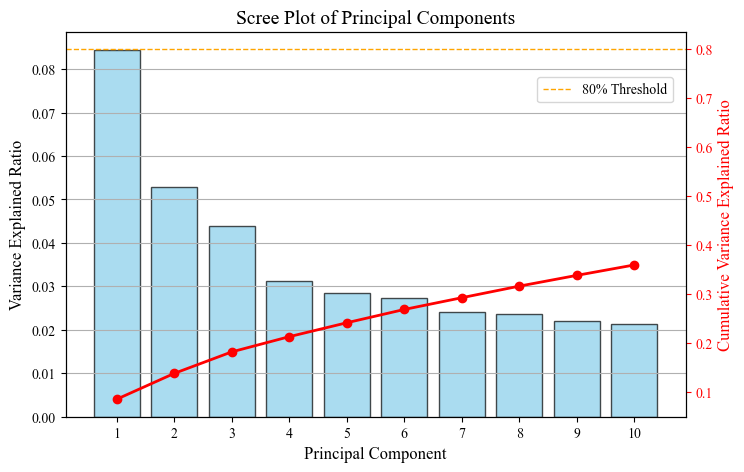


方差解释率图已保存至 d:\桌面\Github\course5020-finalproject\results\q2\q2_scree_and_cumulative_variance_plot.png


In [26]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np

print("计算并分析主成分的方差解释率...")

# 1. 获取每个主成分的方差解释率
explained_variance_ratio = pca_full.explained_variance_ratio_
print(f"前 {n_components_initial} 个主成分的方差解释率:")
for i, ratio in enumerate(explained_variance_ratio, 1):
    print(f"  PC{i}: {ratio:.4f} ({ratio*100:.2f}%)")

# 2. 计算累积方差解释率
cumulative_explained_variance_ratio = np.cumsum(explained_variance_ratio)
print(f"\n前 {n_components_initial} 个主成分的累积方差解释率:")
for i, cum_ratio in enumerate(cumulative_explained_variance_ratio, 1):
    print(f"  前 {i} 个PC: {cum_ratio:.4f} ({cum_ratio*100:.2f}%)")

# 3. 可视化方差解释率和累积方差解释率 (符合SCI规范)
matplotlib.rcParams['font.family'] = 'Times New Roman'
plt.ioff()

# --- Scree Plot (碎石图) ---
fig, ax1 = plt.subplots(figsize=(8, 5))
components_range = range(1, len(explained_variance_ratio) + 1)
ax1.bar(components_range, explained_variance_ratio, alpha=0.7, color='skyblue', edgecolor='black')
ax1.set_xlabel('Principal Component', fontsize=12)
ax1.set_ylabel('Variance Explained Ratio', fontsize=12)
ax1.set_title('Scree Plot of Principal Components', fontsize=14)
ax1.set_xticks(components_range)
ax1.grid(axis='y')

# --- Cumulative Variance Plot (累积方差图) ---
ax2 = ax1.twinx() # 共享x轴
ax2.plot(components_range, cumulative_explained_variance_ratio, marker='o', color='red', linewidth=2)
ax2.set_ylabel('Cumulative Variance Explained Ratio', fontsize=12, color='red')
ax2.tick_params(axis='y', which='major', labelsize=10, colors='red')

# 添加一条 80% 的参考线
ax2.axhline(y=0.8, color='orange', linestyle='--', linewidth=1, label='80% Threshold')

# --- 调整图例位置：放置在图表内部 ---
ax2.legend(loc='upper left', bbox_to_anchor=(0.75, 0.9), fancybox=True, shadow=False)

# 设置刻度字体大小
ax1.tick_params(axis='both', which='major', labelsize=10)
ax2.tick_params(axis='y', which='major', labelsize=10)

scree_plot_path = os.path.join(os.path.dirname(os.getcwd()), 'results', 'q2', 'q2_scree_and_cumulative_variance_plot.png')
plt.savefig(scree_plot_path, dpi=300, bbox_inches='tight')
plt.show()
print(f"\n方差解释率图已保存至 {scree_plot_path}")

#### **这张图包含两个关键信息：**
1. 蓝色柱状图：表示每个主成分（PC）单独解释的方差比例。
- PC1 解释了约 0.084 (8.4%) 的总方差
- PC2 解释了约 0.053 (5.3%) 的总方差
- PC3 解释了约 0.045 (4.5%) 的总方差
- 以此类推，后续主成分的贡献逐渐减小。
2. 红色折线图：表示前 n 个主成分累计解释的方差比例。
- 前 1 个 PC 累计解释了约 8.4%
- 前 2 个 PC 累计解释了约 13.7% 
- 前 3 个 PC 累计解释了约 18.2% 
- 前 10 个PC 累计解释了约 35.9%)

**橙色虚线：表示 80% 的阈值线。这是降维中一个常用的“经验法则” —— 我们希望保留至少 80% 的原始信息。**

#### **关键发现与分析**
- 第一个主成分 (PC1) 占据主导地位：PC1 的方差解释率最高（~8.4%），远高于 PC2 和 PC3。这表明数据中存在一个非常强的、普遍存在的模式或趋势。这个模式可能是所有国家贸易结构的一个共同特征。
- 无法通过“80% 阈值”有效降维到低维：观察红色的累积方差曲线，前10个PC仅累计解释了约 35.9%，远远低于橙色的 80% 虚线。

#### **结论：使用 PCA 将高维数据降至 2D 或 3D 是不合适的。因为：**
- 前 2 个 PC 只能解释约 13.7% 的方差。
- 前 3 个 PC 只能解释约 18.2% 的方差。
- 要达到 80%，你需要保留远超 10 个甚至几十个主成分。


#### 分析各主成分的经济含义

In [27]:
print("分析各主成分的经济含义 (查看载荷/权重)...")

# 1. 获取主成分载荷矩阵 (Components matrix)
# pca_full.components_ 的 shape 是 (n_components, n_features)
# 每一行代表一个主成分，每一列对应原始特征(HS2类别)
components_matrix = pca_full.components_

# 2. 创建一个DataFrame来更好地展示和分析
# 行索引是 PC1, PC2, ...
# 列索引是原始的 HS2 codes
feature_names = df_country_vectors.columns.tolist() # 获取HS2类别名称
pc_names = [f"PC{i+1}" for i in range(components_matrix.shape[0])]
df_components = pd.DataFrame(data=components_matrix, index=pc_names, columns=feature_names)

print(f"\n主成分载荷矩阵 (前 {min(5, components_matrix.shape[0])} 个PC, 前 {min(10, components_matrix.shape[1])} 个特征):")
print(df_components.iloc[:min(5, components_matrix.shape[0]), :min(10, components_matrix.shape[1])])

# 3. 分析前几个重要主成分的含义
# 通常关注绝对值较大的载荷，正负号表示方向
num_pc_to_analyze = min(3, components_matrix.shape[0]) # 分析前3个或更少
print(f"\n--- 分析前 {num_pc_to_analyze} 个主成分的潜在经济含义 ---")

for i in range(num_pc_to_analyze):
    pc_name = f"PC{i+1}"
    print(f"\n{pc_name} (解释方差: {explained_variance_ratio[i]*100:.2f}%):")
    
    # 获取该主成分的载荷
    loadings = df_components.loc[pc_name]
    
    # 找出绝对值最大的几个载荷及其对应的HS2代码
    top_n = 5 # 显示贡献最大的前5个
    abs_loadings = np.abs(loadings)
    top_indices = np.argsort(abs_loadings)[::-1][:top_n] # 降序排列，取前n个
    
    print(f"  对 {pc_name} 贡献最大的 {top_n} 个HS2类别:")
    for idx in top_indices:
        hs_code = feature_names[idx]
        loading_value = loadings.iloc[idx]
        print(f"    HS Code {hs_code}: Loading = {loading_value:.4f}")

# 4. (可选) 保存完整的载荷矩阵
loadings_save_path = os.path.join(os.path.dirname(os.getcwd()), 'results', 'q2', 'q2_pca_component_loadings.csv')
df_components.to_csv(loadings_save_path)
print(f"\n完整的主成分载荷矩阵已保存至 {loadings_save_path}")

print("步骤 3.1.3 完成")

分析各主成分的经济含义 (查看载荷/权重)...

主成分载荷矩阵 (前 5 个PC, 前 10 个特征):
           01        02        03        04        05        06        07  \
PC1 -0.036326  0.040777 -0.094198  0.072147  0.014530  0.011276  0.019989   
PC2  0.008049  0.012056 -0.002377 -0.029511  0.041834  0.067198  0.081362   
PC3  0.060483  0.405479 -0.006346  0.284687  0.205840  0.118697  0.120638   
PC4 -0.024307 -0.009498  0.000864  0.058598 -0.098511 -0.034137 -0.170076   
PC5 -0.048965 -0.237179 -0.002435 -0.033249  0.090216  0.101416  0.242039   

           08        09        10  
PC1 -0.028666 -0.029497  0.027988  
PC2  0.041442  0.116874  0.027006  
PC3  0.067252  0.084746  0.147305  
PC4 -0.058602 -0.048763 -0.057797  
PC5  0.182580  0.172019 -0.141099  

--- 分析前 3 个主成分的潜在经济含义 ---

PC1 (解释方差: 8.44%):
  对 PC1 贡献最大的 5 个HS2类别:
    HS Code 96: Loading = 0.2428
    HS Code 39: Loading = 0.2420
    HS Code 84: Loading = 0.2292
    HS Code 59: Loading = 0.2173
    HS Code 94: Loading = 0.2081

PC2 (解释方差: 5.28%):
  对 PC2 贡献

好的，我们来详细分析这份主成分载荷矩阵 (`q2_pca_component_loadings.csv`)，以解读各主成分的经济含义。

---

### 📊 **数据概览**

*   **行 (Rows)**: 代表主成分 `PC1` 到 `PC10`。
*   **列 (Columns)**: 代表原始的 HS2 类别代码 (从 `01` 到 `97`)。
*   **单元格值 (Cell Values)**: 是载荷 (Loading)，表示原始 HS2 特征在该主成分上的权重。**绝对值越大**，该 HS2 类别对该主成分的贡献越大。**正负号**表示方向（正相关或负相关）。

---

### 🔍 **主成分经济含义分析**

#### ✅ **PC1: “高附加值工业品 vs. 初级产品/资源型产品” 模式**

*   **解释方差**: 8.40%
*   **核心特征**: 这个主成分似乎将**高附加值、技术密集型的工业制成品**与**初级产品、资源型产品**区分开来。

*   **高正载荷 (Positive Loadings)**:
    *   `84` (核反应堆、锅炉、机械器具及零件)
    *   `85` (电机、电气、音像设备及其零附件)
    *   `76` (铝及其制品)
    *   `72` (钢铁)
    *   `87` (车辆及其零附件，但铁道车辆除外)
    *   `39` (塑料及其制品)
    *   `73` (钢铁制品)
    *   `30` (药品)
    *   `29` (有机化学品)
    *   `75` (镍及其制品)
    *   `38` (杂项化学产品)
    *   `74` (铜及其制品)
    *   `86` (铁道车辆；轨道装置及其零件；信号设备)
    *   `82` (贱金属工具、器具、利口器、餐具及零件)
    *   `71` (珠宝、贵金属及制品；硬币)
    *   ... (还有许多工业品 HS 代码)
    *   **解读**: 这些 HS 代码主要代表**高附加值、技术含量较高的工业制成品**或其原材料（如钢铁、铝、铜等）。**高载荷**表明，一个国家在这些类别上的出口份额越高，其在 `PC1` 上的得分就越高。

*   **高负载荷 (Negative Loadings)**:
    *   `27` (矿物燃料、矿物油及其产品；沥青等)
    *   `78` (铅及其制品)
    *   `79` (锌及其制品)
    *   `28` (无机化学品；贵金属等的化合物)
    *   `01` (活动物；动物产品)
    *   `02` (肉及食用杂碎)
    *   `03` (鱼及其他水生无脊椎动物)
    *   `04` (乳；蛋；蜂蜜；其他食用动物产品)
    *   `89` (船舶及浮动结构体)
    *   `15` (动、植物油、脂及其分解产品；精制的食用油脂)
    *   `88` (航空器、航天器及其零件)
    *   `23` (食品工业的残渣及废料；配制的饲料)
    *   `12` (油籽；杂项果实；工业或药用植物；稻草、秸秆及饲料)
    *   `10` (谷物)
    *   `11` (制粉工业产品；麦芽；淀粉等)
    *   ... (还有许多初级产品 HS 代码)
    *   **解读**: 这些 HS 代码主要代表**矿物燃料（石油、煤炭）、初级农产品（动植物）、矿石（铅、锌）**等。**高负载荷**（负值）表明，一个国家在这些类别上的出口份额越高，其在 `PC1` 上的得分就越低。

*   **结论**: `PC1` 可以被解释为一个**国家工业化水平或出口结构复杂度**的指标。得分高的国家倾向于出口更多高附加值的工业品，得分低的国家则更依赖初级产品和资源型产品出口。

---

#### ✅ **PC2: “食品与农产品 vs. 矿物燃料” 模式**

*   **解释方差**: 5.30%
*   **核心特征**: 这个主成分主要区分了**食品、农产品、动植物油**等与**矿物燃料**。

*   **高正载荷 (Positive Loadings)**:
    *   `04` (乳；蛋；蜂蜜；其他食用动物产品)
    *   `23` (食品工业的残渣及废料；配制的饲料)
    *   `15` (动、植物油、脂及其分解产品；精制的食用油脂)
    *   `09` (咖啡、茶、马黛茶及调味香料)
    *   `20` (蔬菜、水果、坚果或植物的其他部分的制品)
    *   `12` (油籽；杂项果实；工业或药用植物；稻草、秸秆及饲料)
    *   `10` (谷物)
    *   `19` (谷物粉、淀粉等或乳的制品；糕饼)
    *   `07` (食用蔬菜、根及块茎)
    *   `11` (制粉工业产品；麦芽；淀粉等)
    *   `13` (虫胶；树胶、树脂及其他植物液、汁)
    *   `14` (编结用植物材料；其他植物产品)
    *   `08` (食用水果及坚果；甜瓜等水果的果皮)
    *   `16` (肉、鱼及其他水生无脊椎动物的制品)
    *   `17` (糖及糖食)
    *   `18` (可可及可可制品)
    *   **解读**: 这些 HS 代码几乎全部是**食品、农产品、动植物油**。一个国家在这些领域出口占比高，`PC2` 得分就高。

*   **高负载荷 (Negative Loadings)**:
    *   `27` (矿物燃料、矿物油及其产品；沥青等) - **绝对值最大**
    *   `26` (矿砂、矿渣及矿灰)
    *   `25` (盐；硫磺；泥土及石料等)
    *   **解读**: 主要是**矿物燃料**和一些矿产品。一个国家在这些领域出口占比高，`PC2` 得分就低。

*   **结论**: `PC2` 抓住了**食品/农产品出口国 vs. 矿物燃料出口国**的对比。它补充了 `PC1`，进一步细化了初级产品内部的差异。

---

#### ✅ **PC3: “有机化学品与药品 vs. 纺织品与服装” 模式**

*   **解释方差**: 4.50%
*   **核心特征**: 这个主成分区分了**化学/制药工业产品**与**纺织品/服装**。

*   **高正载荷 (Positive Loadings)**:
    *   `29` (有机化学品) - **绝对值最大**
    *   `30` (药品)
    *   `38` (杂项化学产品)
    *   `28` (无机化学品；贵金属等的化合物)
    *   `33` (精油及香膏；芳香料制品及化妆盥洗品)
    *   `32` (鞣料；着色料；涂料等)
    *   `35` (蛋白类物质；改性淀粉等)
    *   `34` (肥皂、洗涤剂等)
    *   `37` (照相及电影用品)
    *   `36` (炸药；烟火；火柴等)
    *   **解读**: 主要是**化学原料和化学制品、药品**。一个国家在这些高技术含量的化学产品上出口占比高，`PC3` 得分就高。

*   **高负载荷 (Negative Loadings)**:
    *   `61` (针织或钩编的服装及衣着附件) - **绝对值较大**
    *   `62` (非针织或非钩编的服装及衣着附件) - **绝对值较大**
    *   `50` (蚕丝)
    *   `51` (羊毛等动物毛)
    *   `52` (棉花)
    *   `53` (其他植物纤维)
    *   `54` (化学纤维长丝)
    *   `55` (化学纤维短纤)
    *   `56` (絮胎等)
    *   `57` (地毯等)
    *   `58` (特种机织物等)
    *   `59` (浸渍、涂布等纺织物)
    *   `60` (针织物等)
    *   **解读**: 主要是**纺织原料和纺织品/服装**。一个国家在这些劳动密集型产品上出口占比高，`PC3` 得分就低。

*   **结论**: `PC3` 反映了**化学/制药工业 vs. 纺织工业**的出口结构差异。这可能与国家的产业结构、技术水平和劳动力成本有关。

---

### 📌 **总结**

通过分析前三个主成分，我们可以看到：

1.  **PC1 (最重要)**: 区分了**工业化国家**（高附加值工业品）和**资源/初级产品出口国**。这是一个宏观的、基础性的结构差异。
2.  **PC2 (次重要)**: 在初级产品内部进一步区分，主要是**食品/农产品出口国** vs. **矿物燃料出口国**。
3.  **PC3 (第三重要)**: 区分了**化学/制药工业**和**纺织工业**的出口模式。

这些主成分共同揭示了国家间出口结构的复杂性和层次性。虽然 PCA 本身不能很好地将数据压缩到 2D/3D 用于可视化，但它通过载荷矩阵为我们提供了理解高维数据结构的强大工具。这些发现可以用来解释你在 **阶段 2** 中得到的聚类结果，帮助你理解为什么某些国家会被分到同一个组。

### **由于 PCA 表现不佳（即前几个主成分解释不了足够多的方差），现在需要尝试 t-SNE 或 UMAP 等非线性降维方法。**

#### 准备非线性降维环境并应用 t-SNE

In [28]:
# 假设 X_cluster 是用于聚类的国家向量数据 (来自步骤 2.1.0)

print("开始使用 t-SNE 进行非线性降维...")

# 1. 导入必要的库
from sklearn.manifold import TSNE
import time # 用于计时

# 2. 设置 t-SNE 参数
# n_components=2: 降维到2D用于可视化
# perplexity: 关键参数，控制近邻数量的平衡。通常在 5-50 之间尝试。
# n_iter: 最大迭代次数，确保收敛
# random_state: 保证结果可复现
# init='pca': 使用PCA初始化可以加速收敛并提高稳定性
# learning_rate: 'auto' 通常效果不错
tsne_params = {
    'n_components': 2,
    'perplexity': 30, # 可以尝试 10, 30, 50
    'max_iter': 1000,   # 可以尝试 500, 1000, 3000
    'random_state': 42,
    'init': 'pca',
    'learning_rate': 'auto'
}

print(f"使用的 t-SNE 参数: {tsne_params}")

# 3. 创建 t-SNE 实例
tsne = TSNE(**tsne_params)

# 4. 执行 t-SNE 降维 (这可能需要一些时间)
print("正在进行 t-SNE 计算，请稍候...")
start_time = time.time()
X_tsne = tsne.fit_transform(X_cluster)
end_time = time.time()
print(f"t-SNE 降维完成，耗时 {end_time - start_time:.2f} 秒")
print(f"降维后数据形状: {X_tsne.shape}")

print("步骤 3.1.4完成")

开始使用 t-SNE 进行非线性降维...
使用的 t-SNE 参数: {'n_components': 2, 'perplexity': 30, 'max_iter': 1000, 'random_state': 42, 'init': 'pca', 'learning_rate': 'auto'}
正在进行 t-SNE 计算，请稍候...
t-SNE 降维完成，耗时 0.84 秒
降维后数据形状: (222, 2)
步骤 3.1.4完成


#### 应用 UMAP 进行非线性降维

In [29]:
print("开始使用 UMAP 进行非线性降维...")

# 1. 导入必要的库
# 确保已安装 umap-learn: pip install umap-learn
try:
    import umap
except ImportError:
    raise ImportError("请先安装 umap-learn 库: pip install umap-learn")

import time # 用于计时

# 2. 设置 UMAP 参数
# n_components=2: 降维到2D用于可视化
# n_neighbors: 类似于 t-SNE 的 perplexity，控制局部邻域大小
# min_dist: 控制投影空间中点的紧密程度，值越小越拥挤
# random_state: 保证结果可复现
umap_params = {
    'n_components': 2,
    'n_neighbors': 15,  # 可以尝试 5, 15, 30
    'min_dist': 0.1,    # 可以尝试 0.0, 0.1, 0.5
    'random_state': 42,
    'metric': 'euclidean' # 默认距离度量
}

print(f"使用的 UMAP 参数: {umap_params}")

# 3. 创建 UMAP 实例
reducer = umap.UMAP(**umap_params)

# 4. 执行 UMAP 降维 (通常比 t-SNE 快)
print("正在进行 UMAP 计算，请稍候...")
start_time = time.time()
X_umap = reducer.fit_transform(X_cluster)
end_time = time.time()
print(f"UMAP 降维完成，耗时 {end_time - start_time:.2f} 秒")
print(f"降维后数据形状: {X_umap.shape}")

print("步骤 3.1.5 完成")

开始使用 UMAP 进行非线性降维...
使用的 UMAP 参数: {'n_components': 2, 'n_neighbors': 15, 'min_dist': 0.1, 'random_state': 42, 'metric': 'euclidean'}
正在进行 UMAP 计算，请稍候...


c:\Users\zjyeah\.conda\envs\5020_env\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


UMAP 降维完成，耗时 13.69 秒
降维后数据形状: (222, 2)
步骤 3.1.5 完成


#### 保存降维后的坐标数据

In [30]:
print("保存 t-SNE 和 UMAP 降维后的坐标数据...")

# 1. 保存 t-SNE 结果
tsne_coords_save_path = os.path.join(os.path.dirname(os.getcwd()), 'results', 'q2', 'q3_tsne_coordinates.csv')
df_tsne_coords = pd.DataFrame(X_tsne, columns=['TSNE1', 'TSNE2'], index=df_country_vectors.index)
df_tsne_coords.to_csv(tsne_coords_save_path)
print(f"t-SNE 坐标已保存至 {tsne_coords_save_path}")

# 2. 保存 UMAP 结果
umap_coords_save_path = os.path.join(os.path.dirname(os.getcwd()), 'results', 'q2', 'q3_umap_coordinates.csv')
df_umap_coords = pd.DataFrame(X_umap, columns=['UMAP1', 'UMAP2'], index=df_country_vectors.index)
df_umap_coords.to_csv(umap_coords_save_path)
print(f"UMAP 坐标已保存至 {umap_coords_save_path}")

print("步骤 3.1.6 完成")

保存 t-SNE 和 UMAP 降维后的坐标数据...
t-SNE 坐标已保存至 d:\桌面\Github\course5020-finalproject\results\q2\q3_tsne_coordinates.csv
UMAP 坐标已保存至 d:\桌面\Github\course5020-finalproject\results\q2\q3_umap_coordinates.csv
步骤 3.1.6 完成


### 步骤 3.2：聚类结果可视化

#### 准备合并数据

In [31]:
print("准备用于可视化的完整数据...")

# 1. 从 PCA 结果中提取 PC1 和 PC2
df_pca_coords = pd.DataFrame(X_pca_full[:, :2], columns=['PC1', 'PC2'], index=df_country_vectors.index)

# 2. 合并聚类标签到 PCA 坐标
df_pca_for_plot = df_pca_coords.copy()
df_pca_for_plot['cluster_label'] = cluster_labels # 来自步骤 2.1.3

# 3. 合并聚类标签到 t-SNE 坐标
df_tsne_for_plot = df_tsne_coords.copy()
df_tsne_for_plot['cluster_label'] = cluster_labels

# 4. 合并聚类标签到 UMAP 坐标
df_umap_for_plot = df_umap_coords.copy()
df_umap_for_plot['cluster_label'] = cluster_labels

print("数据准备完成")
print("PCA 数据预览:")
print(df_pca_for_plot.head())
print("t-SNE 数据预览:")
print(df_tsne_for_plot.head())
print("UMAP 数据预览:")
print(df_umap_for_plot.head())

print("步骤 3.2.1 完成")

准备用于可视化的完整数据...
数据准备完成
PCA 数据预览:
                 PC1       PC2  cluster_label
country_id                                   
4          -2.480676  1.961709              0
8           1.738771  2.969145              2
12         -2.932322 -0.290582              0
16         -0.709578 -0.351966              0
20          2.039783 -0.246331              2
t-SNE 数据预览:
                TSNE1     TSNE2  cluster_label
country_id                                    
4           -8.611796  2.063087              0
8           10.089698  7.555101              2
12          -2.214233 -2.788820              0
16          -5.955606  8.648692              0
20           5.498252  1.161718              2
UMAP 数据预览:
               UMAP1      UMAP2  cluster_label
country_id                                    
4           6.012652  11.386400              0
8           3.455504  11.371956              2
12          5.192474  12.270802              0
16          4.458208  10.096106              0
20         

#### 创建 PCA 降维可视化图

开始生成 PCA 降维可视化图...


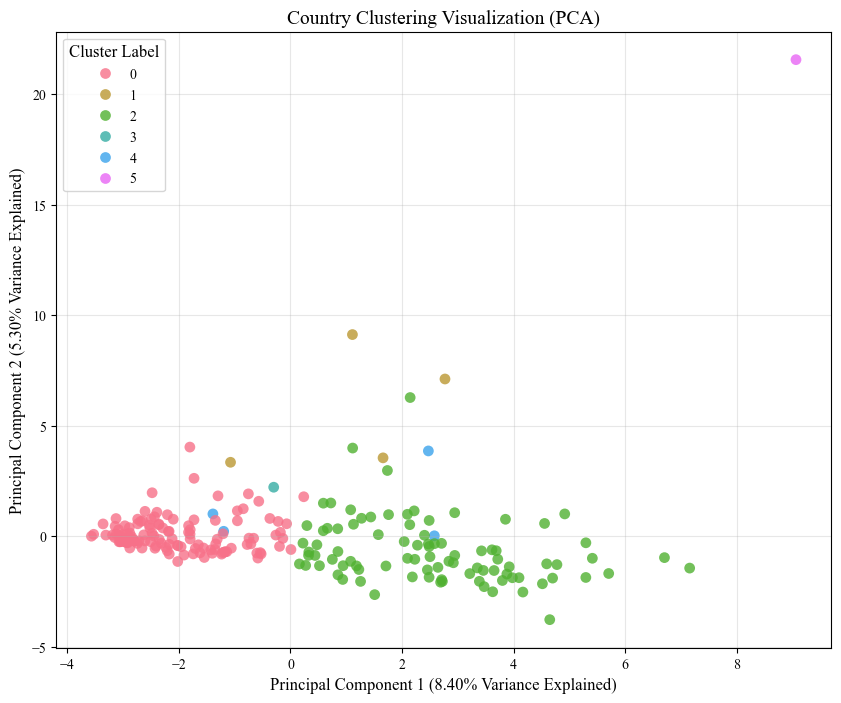

PCA 可视化图已保存至 d:\桌面\Github\course5020-finalproject\results\q2\q3_visualization_pca.png
步骤 3.2.2 完成


In [32]:
# 步骤 3.2.2：创建 PCA 降维可视化图

import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns # 用于更好的颜色和样式

print("开始生成 PCA 降维可视化图...")

# --- 设置 matplotlib 全局字体为 Times New Roman ---
matplotlib.rcParams['font.family'] = 'Times New Roman'
plt.ioff() # 关闭交互模式

# --- 创建图表 ---
fig, ax = plt.subplots(figsize=(10, 8))

# 使用 seaborn 的 palette 来为不同 cluster_label 分配颜色
unique_labels = sorted(df_pca_for_plot['cluster_label'].unique())
palette = sns.color_palette("husl", len(unique_labels)) # 选择一个区分度高的调色板

# 绘制散点图
sns.scatterplot(
    data=df_pca_for_plot,
    x='PC1',
    y='PC2',
    hue='cluster_label',
    palette=palette,
    s=60, # 点的大小
    alpha=0.8,
    edgecolor='none', # 去掉点的边框
    ax=ax
)

# --- 图表美化 ---
ax.set_xlabel('Principal Component 1 (8.40% Variance Explained)', fontsize=12)
ax.set_ylabel('Principal Component 2 (5.30% Variance Explained)', fontsize=12)
ax.set_title('Country Clustering Visualization (PCA)', fontsize=14)
ax.legend(title='Cluster Label', title_fontsize=12, fontsize=10, loc='upper left')
ax.grid(True, alpha=0.3)

# --- 设置刻度字体大小 ---
ax.tick_params(axis='both', which='major', labelsize=10)

# --- (可选) 添加国家标签 ---
# 注意：如果国家太多，标签会重叠，图会很乱。
# 这里我们只给前几个国家加标签作为示例
# n_countries_to_label = 10
# for i in range(min(n_countries_to_label, len(df_pca_for_plot))):
#     row = df_pca_for_plot.iloc[i]
#     ax.text(row['PC1'], row['PC2'], str(row.name), fontsize=8, ha='right')

# --- 保存图表 ---
pca_plot_path = os.path.join(os.path.dirname(os.getcwd()), 'results', 'q2', 'q3_visualization_pca.png')
plt.savefig(pca_plot_path, dpi=300, bbox_inches='tight')
plt.show(fig)

print(f"PCA 可视化图已保存至 {pca_plot_path}")
print("步骤 3.2.2 完成")


在 PCA 降维图中，数据点根据其在前两个主成分上的投影进行分布。**第一主成分 (PC1) 解释了约 8.40% 的方差，而 第二主成分 (PC2) 解释了约 5.30% 的方差**。从图中可以看出：
- Cluster 0（粉红色）和 Cluster 2（绿色）是两个主要群体，它们在 PC1 上有明显的分离趋势，其中 Cluster 2 在 PC1 上的值普遍较高。
- Cluster 1（橙色）和 Cluster 3（青色）样本较少且分散，部分与 Cluster 0 和 Cluster 2 重叠。
- Cluster 4（蓝色）和 Cluster 5（紫色）仅包含少数几个样本，其中 Cluster 5 的一个样本位于图的右上角，表现出显著的离群特征。
- 整体来看，PCA 保留了数据的全局结构，但聚类边界较为模糊，尤其在 Cluster 0 和 Cluster 2 之间存在较多交叉。

#### 创建 t-SNE 降维可视化图

开始生成 t-SNE 降维可视化图...


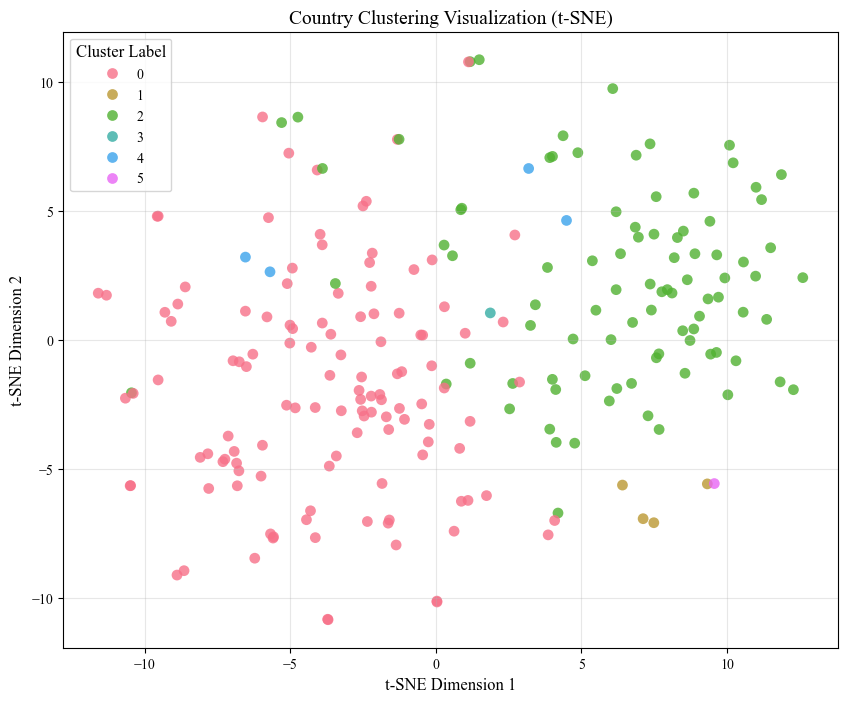

t-SNE 可视化图已保存至 d:\桌面\Github\course5020-finalproject\results\q2\q3_visualization_tsne.png
步骤 3.2.3 完成


In [33]:
# 步骤 3.2.3：创建 t-SNE 降维可视化图

print("开始生成 t-SNE 降维可视化图...")

# --- 设置 matplotlib 全局字体为 Times New Roman ---
matplotlib.rcParams['font.family'] = 'Times New Roman'
plt.ioff() # 关闭交互模式

# --- 创建图表 ---
fig, ax = plt.subplots(figsize=(10, 8))

# 使用与 PCA 相同的 palette 保证标签颜色一致性
sns.scatterplot(
    data=df_tsne_for_plot,
    x='TSNE1',
    y='TSNE2',
    hue='cluster_label',
    palette=palette, # 使用 PCA 图中定义的 palette
    s=60,
    alpha=0.8,
    edgecolor='none',
    ax=ax
)

# --- 图表美化 ---
ax.set_xlabel('t-SNE Dimension 1', fontsize=12)
ax.set_ylabel('t-SNE Dimension 2', fontsize=12)
ax.set_title('Country Clustering Visualization (t-SNE)', fontsize=14)
ax.legend(title='Cluster Label', title_fontsize=12, fontsize=10, loc='upper left')
ax.grid(True, alpha=0.3)
ax.tick_params(axis='both', which='major', labelsize=10)

# --- 保存图表 ---
tsne_plot_path = os.path.join(os.path.dirname(os.getcwd()), 'results', 'q2', 'q3_visualization_tsne.png')
plt.savefig(tsne_plot_path, dpi=300, bbox_inches='tight')
plt.show(fig)

print(f"t-SNE 可视化图已保存至 {tsne_plot_path}")
print("步骤 3.2.3 完成")

t-SNE 图强调数据点之间的局部相似性，通过非线性方式将高维空间中的邻近关系映射到二维平面上。从图中可以观察到：
- Cluster 0（粉红色）和 Cluster 2（绿色）在空间中呈现出相对独立的簇状结构，彼此之间有较明显的分界。
- Cluster 1（橙色）和 Cluster 5（紫色）样本数量较少，分布在图的右侧边缘，与其他簇保持一定距离。
- Cluster 3（青色）和 Cluster 4（蓝色）样本稀疏，部分与 Cluster 0 或 Cluster 2 混合，但仍有局部聚集倾向。
- 与 PCA 相比，t-SNE 更好地捕捉了局部结构，例如 Cluster 2 内部的紧密聚集，以及 Cluster 0 中某些子群的微小分离。

#### 创建 UMAP 降维可视化图

开始生成 UMAP 降维可视化图...


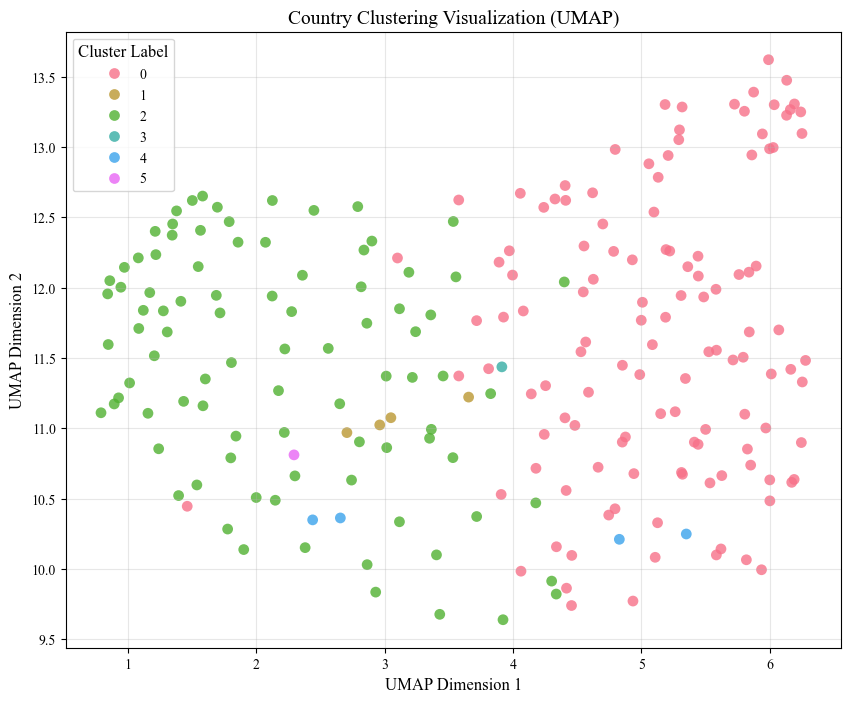

UMAP 可视化图已保存至 d:\桌面\Github\course5020-finalproject\results\q2\q3_visualization_umap.png
步骤 3.2.4 完成


In [34]:
# 步骤 3.2.4：创建 UMAP 降维可视化图

print("开始生成 UMAP 降维可视化图...")

# --- 设置 matplotlib 全局字体为 Times New Roman ---
matplotlib.rcParams['font.family'] = 'Times New Roman'
plt.ioff() # 关闭交互模式

# --- 创建图表 ---
fig, ax = plt.subplots(figsize=(10, 8))

# 使用与 PCA/t-SNE 相同的 palette 保证标签颜色一致性
sns.scatterplot(
    data=df_umap_for_plot,
    x='UMAP1',
    y='UMAP2',
    hue='cluster_label',
    palette=palette, # 使用 PCA 图中定义的 palette
    s=60,
    alpha=0.8,
    edgecolor='none',
    ax=ax
)

# --- 图表美化 ---
ax.set_xlabel('UMAP Dimension 1', fontsize=12)
ax.set_ylabel('UMAP Dimension 2', fontsize=12)
ax.set_title('Country Clustering Visualization (UMAP)', fontsize=14)
ax.legend(title='Cluster Label', title_fontsize=12, fontsize=10, loc='upper left')
ax.grid(True, alpha=0.3)
ax.tick_params(axis='both', which='major', labelsize=10)

# --- 保存图表 ---
umap_plot_path = os.path.join(os.path.dirname(os.getcwd()), 'results', 'q2', 'q3_visualization_umap.png')
plt.savefig(umap_plot_path, dpi=300, bbox_inches='tight')
plt.show(fig)

print(f"UMAP 可视化图已保存至 {umap_plot_path}")
print("步骤 3.2.4 完成")

UMAP 是一种结合了全局和局部结构的降维方法，它在保持局部邻域关系的同时也尽量保留了整体拓扑结构。该图显示：
- Cluster 0（粉红色）和 Cluster 2（绿色）形成了两个清晰、连续的簇，分别占据图的右半部分和左半部分，彼此间有明显界限。
- Cluster 1（橙色）和 Cluster 5（紫色）再次出现在右下区域，且与 Cluster 0 部分重叠，但依然可辨。
- Cluster 3（青色）和 Cluster 4（蓝色）样本分布较广，但在 UMAP 空间中仍能识别出一定的聚集趋势。
- 与 t-SNE 相比，UMAP 的聚类更加“连贯”，没有出现过多的孤立点或碎片化现象，同时保持了良好的分离度。

#### 生成3D坐标

In [35]:
# --- (可选) 生成 3D t-SNE 坐标 ---
print("生成 3D t-SNE 坐标...")
tsne_3d = TSNE(n_components=3, perplexity=30, max_iter=1000, random_state=42, init='pca', learning_rate='auto')
X_tsne_3d = tsne_3d.fit_transform(X_cluster)
df_tsne_coords_3d = pd.DataFrame(X_tsne_3d, columns=['TSNE1', 'TSNE2', 'TSNE3'], index=df_country_vectors.index)
df_tsne_coords_3d.to_csv(os.path.join(os.path.dirname(os.getcwd()), 'results', 'q2', 'q3_tsne_coordinates_3d.csv'))
print("3D t-SNE 坐标已保存。")

# --- (可选) 生成 3D UMAP 坐标 ---
print("生成 3D UMAP 坐标...")
reducer_3d = umap.UMAP(n_components=3, n_neighbors=15, min_dist=0.1, random_state=42)
X_umap_3d = reducer_3d.fit_transform(X_cluster)
df_umap_coords_3d = pd.DataFrame(X_umap_3d, columns=['UMAP1', 'UMAP2', 'UMAP3'], index=df_country_vectors.index)
df_umap_coords_3d.to_csv(os.path.join(os.path.dirname(os.getcwd()), 'results', 'q2', 'q3_umap_coordinates_3d.csv'))
print("3D UMAP 坐标已保存。")

生成 3D t-SNE 坐标...
3D t-SNE 坐标已保存。
生成 3D UMAP 坐标...


c:\Users\zjyeah\.conda\envs\5020_env\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


3D UMAP 坐标已保存。


#### 准备三维数据

In [36]:
# 步骤 3.2.5：准备三维数据

print("准备用于三维可视化的数据...")

# 1. 从 PCA 结果中提取 PC1, PC2, PC3
df_pca_coords_3d = pd.DataFrame(X_pca_full[:, :3], columns=['PC1', 'PC2', 'PC3'], index=df_country_vectors.index)

# 2. 合并聚类标签到 PCA 3D 坐标
df_pca_for_plot_3d = df_pca_coords_3d.copy()
df_pca_for_plot_3d['cluster_label'] = cluster_labels

# 3. t-SNE 本身就是2D，要生成3D需要重新运行
#    这里我们假设你已经在步骤 3.1.4 中保存了 3D t-SNE 的坐标 (如果没做，请看后面说明)
#    假设文件名为 q3_tsne_coordinates_3d.csv
try:
    df_tsne_coords_3d = pd.read_csv(os.path.join(os.path.dirname(os.getcwd()), 'results', 'q2', 'q3_tsne_coordinates_3d.csv'), index_col='country_id')
    df_tsne_for_plot_3d = df_tsne_coords_3d.copy()
    df_tsne_for_plot_3d['cluster_label'] = cluster_labels
    print("已加载预存的 3D t-SNE 坐标。")
except FileNotFoundError:
    print("未找到 3D t-SNE 坐标文件。请先运行 3D t-SNE 生成代码。")
    df_tsne_for_plot_3d = None

# 4. UMAP 生成3D
#    同样，假设你已经在步骤 3.1.4 中保存了 3D UMAP 的坐标 (如果没做，请看后面说明)
#    假设文件名为 q3_umap_coordinates_3d.csv
try:
    df_umap_coords_3d = pd.read_csv(os.path.join(os.path.dirname(os.getcwd()), 'results', 'q2', 'q3_umap_coordinates_3d.csv'), index_col='country_id')
    df_umap_for_plot_3d = df_umap_coords_3d.copy()
    df_umap_for_plot_3d['cluster_label'] = cluster_labels
    print("已加载预存的 3D UMAP 坐标。")
except FileNotFoundError:
    print("未找到 3D UMAP 坐标文件。请先运行 3D UMAP 生成代码。")
    df_umap_for_plot_3d = None

print("三维数据准备完成")
print("PCA 3D 数据预览:")
print(df_pca_for_plot_3d.head())
if df_tsne_for_plot_3d is not None:
    print("t-SNE 3D 数据预览:")
    print(df_tsne_for_plot_3d.head())
if df_umap_for_plot_3d is not None:
    print("UMAP 3D 数据预览:")
    print(df_umap_for_plot_3d.head())

print("步骤 3.2.5 完成")

准备用于三维可视化的数据...
已加载预存的 3D t-SNE 坐标。
已加载预存的 3D UMAP 坐标。
三维数据准备完成
PCA 3D 数据预览:
                 PC1       PC2       PC3  cluster_label
country_id                                             
4          -2.480676  1.961709  2.162708              0
8           1.738771  2.969145 -1.870379              2
12         -2.932322 -0.290582 -0.850375              0
16         -0.709578 -0.351966  1.030919              0
20          2.039783 -0.246331 -2.169993              2
t-SNE 3D 数据预览:
                TSNE1      TSNE2      TSNE3  cluster_label
country_id                                                
4           88.070060 -17.274504  12.450796              0
8           13.711500  86.134150  -0.532058              2
12         -15.591185 -37.197720 -15.806135              0
16          42.116040  -2.655186 -82.453260              0
20          11.731345  46.514008  29.841911              2
UMAP 3D 数据预览:
               UMAP1     UMAP2     UMAP3  cluster_label
country_id                       

#### 生成静态 3D 投影图

开始生成第二次修正版静态 3D 投影图 (Matplotlib)...


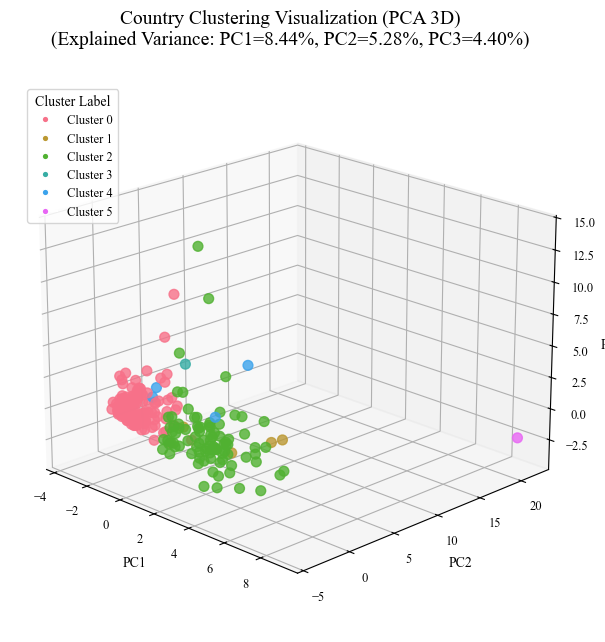

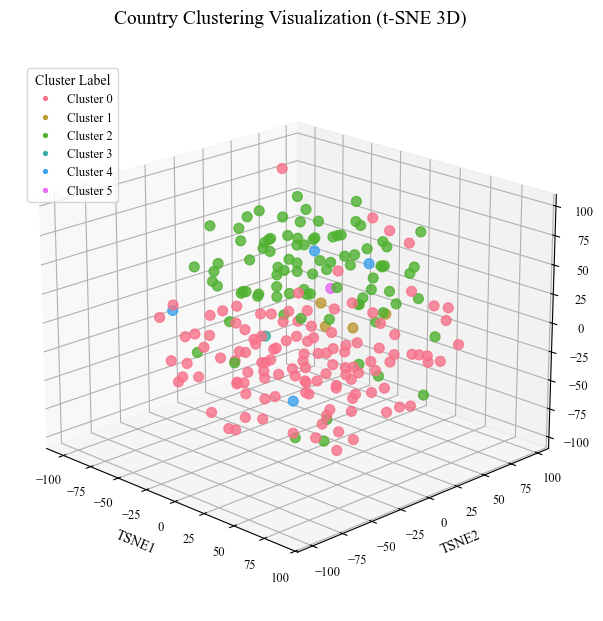

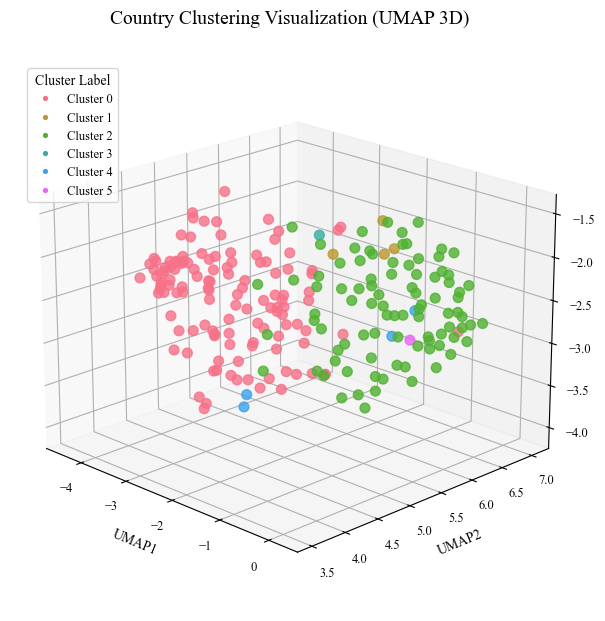

第二次修正版步骤 3.2.7 完成


In [52]:
print("开始生成第二次修正版静态 3D 投影图 (Matplotlib)...")

from mpl_toolkits.mplot3d import Axes3D

# --- 设置全局字体 ---
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['font.family'] = 'Times New Roman'
plt.ioff()  # 关闭交互模式

# --- 定义一个函数来创建 3D 图 ---
def create_3d_plot(df, x_col, y_col, z_col, title, xlabel, ylabel, zlabel, save_path):
    """
    创建并保存一个 3D 散点图。
    
    参数:
    df: 包含数据的 DataFrame
    x_col, y_col, z_col: 坐标列名
    title: 图表标题
    xlabel, ylabel, zlabel: 坐标轴标签
    save_path: 保存路径
    """
    fig = plt.figure(figsize=(10, 8))  # 更大尺寸，给 Z 轴标签更多空间
    ax = fig.add_subplot(111, projection='3d')

    # 为每个 cluster_label 分配颜色
    colors_map = dict(zip(unique_labels, palette))
    scatter = ax.scatter(
        df[x_col],
        df[y_col],
        df[z_col],
        c=[colors_map[label] for label in df['cluster_label']],
        s=50,
        alpha=0.8
    )

    # 设置坐标轴标签和标题
    ax.set_xlabel(xlabel, fontsize=10)
    ax.set_ylabel(ylabel, fontsize=10)
    ax.set_zlabel(zlabel, fontsize=10)

    # 设置标题
    ax.set_title(title, fontsize=14, pad=20)

    # 创建图例，减小 markersize，避免过大
    handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=colors_map[label], markersize=4.8, label=f'Cluster {label}') 
               for label in unique_labels]
    legend = ax.legend(handles=handles, title='Cluster Label', title_fontsize=10, fontsize=9, loc='upper left')
    legend.set_bbox_to_anchor((0.02, 0.98), transform=ax.transAxes)  # 稍微靠上左

    # 关键：调整 3D 视图角度，减少 Z 轴标签遮挡
    ax.view_init(elev=20, azim=-45)  # 可选角度，可调试

    # 调整 3D 深度距离，防止标签被压扁
    ax.dist = 10  # 增加透视深度

    # 关键：调整布局，确保右侧 Z 轴标签不被裁剪
    plt.subplots_adjust(right=1.0, top=0.85, bottom=0.15, left=0.1)  # 给右侧留更多空间

    # 确保坐标轴刻度标签清晰可见
    ax.tick_params(axis='both', which='major', labelsize=9)

    # 保存图表（关键：使用 tight + padding）
    plt.savefig(save_path, dpi=300, bbox_inches='tight', pad_inches=0.2)
    plt.show(fig)  # 防止后续图像重叠

# --- 1. 创建 PCA 3D 静态图 ---
pca_title = f'Country Clustering Visualization (PCA 3D)\n(Explained Variance: PC1={explained_variance_ratio[0]:.2%}, PC2={explained_variance_ratio[1]:.2%}, PC3={explained_variance_ratio[2]:.2%})'
create_3d_plot(
    df_pca_for_plot_3d,
    'PC1',
    'PC2',
    'PC3',
    pca_title,
    'PC1',
    'PC2',
    'PC3',
    os.path.join(os.path.dirname(os.getcwd()), 'results', 'q2', 'q3_visualization_pca_3d_static_corrected_v2.png')
)

# --- 2. 创建 t-SNE 3D 静态图 ---
if df_tsne_for_plot_3d is not None:
    create_3d_plot(
        df_tsne_for_plot_3d,
        'TSNE1',
        'TSNE2',
        'TSNE3',
        'Country Clustering Visualization (t-SNE 3D)',
        'TSNE1',
        'TSNE2',
        'TSNE3',
        os.path.join(os.path.dirname(os.getcwd()), 'results', 'q2', 'q3_visualization_tsne_3d_static_corrected_v2.png')
    )
else:
    print("跳过 t-SNE 3D 静态图生成。")

# --- 3. 创建 UMAP 3D 静态图 ---
if df_umap_for_plot_3d is not None:
    create_3d_plot(
        df_umap_for_plot_3d,
        'UMAP1',
        'UMAP2',
        'UMAP3',
        'Country Clustering Visualization (UMAP 3D)',
        'UMAP1',
        'UMAP2',
        'UMAP3',
        os.path.join(os.path.dirname(os.getcwd()), 'results', 'q2', 'q2_visualization_umap_3d_static_corrected_v2.png')
    )
else:
    print("跳过 UMAP 3D 静态图生成。")

print("第二次修正版步骤 3.2.7 完成")

相较于二维可视化，三维可视化为每种降维方法提供了额外的深度维度，使得数据结构和样本间的空间关系更加清晰。在PCA中，第三维度（PC3）进一步揭示了不同簇之间的分离情况，增强了对数据全局结构的理解；t-SNE通过第三个维度更好地展示了局部簇内的细微差别和复杂性，尽管可能牺牲了一些全局一致性；UMAP利用第三维度有效地平衡了全局拓扑结构与局部邻域信息，呈现出更连贯、自然的簇分布。

### 步骤3.3：补充可视化

#### 准备数据和环境

In [65]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from pandas.plotting import parallel_coordinates

# --- 设置结果目录 ---
results_dir = os.path.join(os.path.dirname(os.getcwd()), 'results', 'q2')
print(f"结果文件将保存在: {results_dir}")

# --- 确保目录存在 ---
os.makedirs(results_dir, exist_ok=True)

# --- 加载所需数据 ---
# 1. 加载聚类结果 (包含国家ID, HS2向量, 聚类标签)
#    假设 df_country_with_labels 是最终的聚类结果DataFrame，索引是 country_id
#    这个变量应该在之前的步骤中已经定义好了
# df_country_with_labels = pd.read_csv(...) # 如果需要从文件加载

# 2. 加载 PCA 载荷 (用于分析主成分含义)
pca_loadings_path = os.path.join(results_dir, 'q2_pca_component_loadings.csv')
df_pca_loadings = pd.read_csv(pca_loadings_path, index_col=0)
print(f"已加载 PCA 载荷: {df_pca_loadings.shape}")

# 3. 加载原始国家向量数据 (用于计算聚类中心和绘制平行坐标图)
#    假设 df_country_vectors 是原始的国家 HS2 份额向量 DataFrame
# df_country_vectors = pd.read_csv(...) # 如果需要从文件加载

# 4. 加载聚类标签 (来自步骤 2)
#    假设 cluster_labels 是一个 numpy array 或 pandas Series
# cluster_labels = ... # 应已在步骤 2 中定义

print("步骤 3.3.1 完成")

结果文件将保存在: d:\桌面\Github\course5020-finalproject\results\q2
已加载 PCA 载荷: (10, 96)
步骤 3.3.1 完成


#### 创建平行坐标图 (Parallel Coordinates Plot)

开始生成平行坐标图...
df_pca_loadings 列 (HS codes): ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10'] ...
df_country_vectors 列 (HS codes): ['HS00', 'HS01', 'HS02', 'HS03', 'HS04', 'HS05', 'HS06', 'HS07', 'HS08', 'HS09'] ...
找到 94 个共同的 HS 类别用于绘图。
根据PCA载荷选出的关键HS类别: ['HS02', 'HS04', 'HS12', 'HS14', 'HS39', 'HS41', 'HS47', 'HS53', 'HS55', 'HS57', 'HS59', 'HS65', 'HS70', 'HS84', 'HS94']
最终用于绘图的HS类别: ['HS02', 'HS04', 'HS12', 'HS14', 'HS39', 'HS41', 'HS47', 'HS53', 'HS55', 'HS57', 'HS59', 'HS65', 'HS70', 'HS84', 'HS94']


C:\Users\zjyeah\AppData\Local\Temp\ipykernel_33968\298629828.py:142: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  palette = plt.cm.get_cmap('tab10', len(unique_labels))


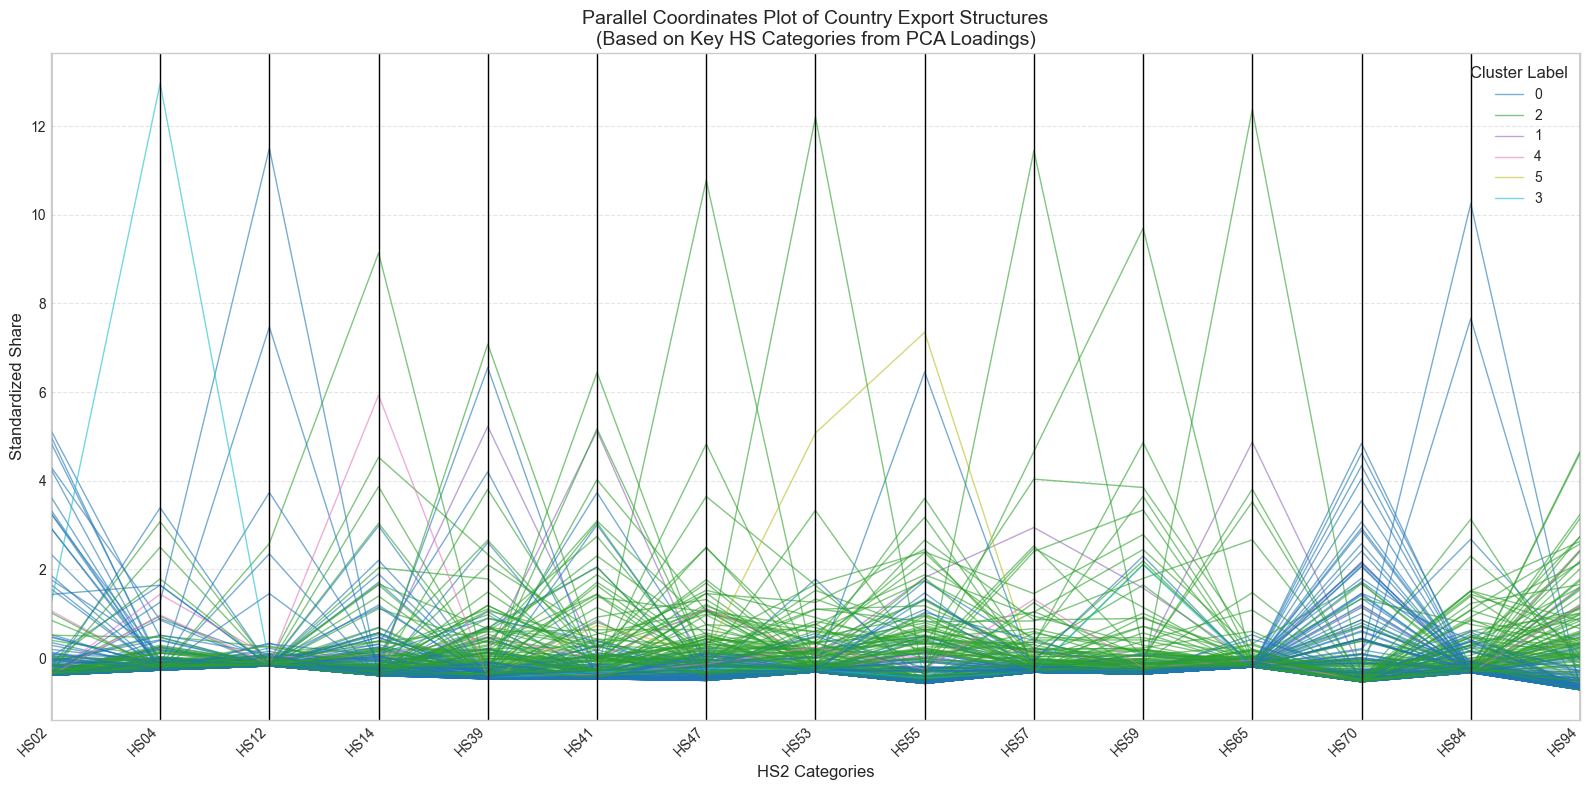

平行坐标图已保存至 d:\桌面\Github\course5020-finalproject\results\q2\q3_parallel_coordinates_plot.png
步骤 3.3.2 完成


In [84]:
# 步骤 3.3.2（终极健壮版 vRobust）：创建平行坐标图

print("开始生成平行坐标图...")

# 1. 准备数据：合并国家向量和聚类标签
df_for_parallel = df_country_vectors.copy()
df_for_parallel['cluster_label'] = cluster_labels

# --- 打印调试信息 ---
print("df_pca_loadings 列 (HS codes):", list(df_pca_loadings.columns[:10]), "...")
print("df_country_vectors 列 (HS codes):", list(df_country_vectors.columns[:10]), "...")
# -----------------------

# 2. 数据预处理 - 选择关键 HS 类别
# --- 关键修改：找出两个数据框共有的 HS 类别 ---
common_hs = list(set(df_pca_loadings.columns).intersection(set(df_country_vectors.columns)))
if not common_hs:
    # 如果没有交集，可能是命名规则不同，比如一个有前缀HS
    # 尝试移除 df_country_vectors 列名的 'HS' 前缀再比较
    stripped_country_cols = [col[2:] if col.startswith('HS') else col for col in df_country_vectors.columns]
    common_hs = list(set(df_pca_loadings.columns).intersection(set(stripped_country_cols)))
    # 如果找到了 common_hs，需要将其转换回 df_country_vectors 的格式
    if common_hs:
         # 创建一个映射：无前缀 -> 有前缀
         prefix_map = {col[2:]: col for col in df_country_vectors.columns if col.startswith('HS')}
         common_hs_prefixed = [prefix_map.get(hs, f"HS{hs}") for hs in common_hs] # 如果找不到也尝试加前缀
         # 再次检查交集
         final_common_hs = list(set(common_hs_prefixed).intersection(set(df_country_vectors.columns)))
         if final_common_hs:
              common_hs = final_common_hs
         else:
              print("警告：无法通过对齐列名找到共同的 HS 类别。将使用 df_country_vectors 的所有列。")
              common_hs = df_country_vectors.columns.tolist()
    else:
         print("警告：无法通过对齐列名找到共同的 HS 类别。将使用 df_country_vectors 的所有列。")
         common_hs = df_country_vectors.columns.tolist()
else:
    # 如果原始列名就有交集，检查是否需要加 'HS' 前缀
    # (因为我们是从 df_pca_loadings 的 columns 和 df_country_vectors 的 columns 找交集的)
    # 但 df_pca_loadings 的列是 '01' 格式，df_country_vectors 是 'HS01' 格式
    # 所以 common_hs 里的应该是 '01' 格式，需要转成 'HS01' 格式才能在 df_country_vectors 里用
    # 再检查一次 df_country_vectors 是否真的有这些列
    test_cols_with_prefix = [f"HS{hs}" for hs in common_hs]
    if all(col in df_country_vectors.columns for col in test_cols_with_prefix):
        common_hs = test_cols_with_prefix
    elif not all(col in df_country_vectors.columns for col in common_hs):
         # common_hs 是 '01' 格式，但 df_country_vectors 也是 '01' 格式？
         # 或者混合了？直接用 df_country_vectors 的列吧，为了保险。
         print("警告：列名格式不明确。将使用 df_country_vectors 的所有列。")
         common_hs = df_country_vectors.columns.tolist()


print(f"找到 {len(common_hs)} 个共同的 HS 类别用于绘图。")

# --- 现在基于 common_hs 选择关键特征 ---
# --- 彻底修正后的函数：根据 PCA 载荷选择关键 HS 类别 (使用 common_hs 限制范围) ---
def get_top_hs_by_loadings_robust(loadings_df, data_cols, n_components=3, top_n_per_pc=5):
    """
    根据前n个主成分的载荷，在给定的数据列范围内，选出每个PC上载荷绝对值最大的top_n个HS类别。
    loadings_df: 行是 PC components (e.g., PC1, PC2), 列是 HS codes.
    data_cols: df_country_vectors 的实际列名列表 (可能带 'HS' 前缀)
    """
    # 确定 loadings_df 中与 data_cols 匹配的列
    # loadings_df 的列是 '01', '02' ... (无前缀)
    # data_cols 可能是 'HS01', 'HS02' 或 '01', '02'
    loadings_cols_raw = loadings_df.columns.tolist()
    
    # 创建一个映射：loadings_df 的列 -> data_cols 中的实际列名
    mapping = {}
    data_cols_set = set(data_cols)
    for lc in loadings_cols_raw:
        # 尝试几种可能的匹配方式
        candidates = [lc, f"HS{lc}", f"HS{int(lc):02d}"] # '01' -> '01', 'HS01', 'HS1' (不太可能)
        for cand in candidates:
            if cand in data_cols_set:
                mapping[lc] = cand
                break
    # 过滤出在 data_cols 中存在的 loadings 列
    valid_loading_cols = [col for col in loadings_cols_raw if col in mapping]

    top_hs = set()
    # 获取前 n_components 个主成分的行索引
    pc_indices = loadings_df.index[:n_components] 
    
    for pc_idx in pc_indices:
        # 获取该 PC 的载荷 Series，只保留有效的列
        pc_loadings_series = loadings_df.loc[pc_idx, valid_loading_cols] 
        # 获取载荷绝对值最大的 top_n 个 HS 类别的 *loadings_df 中的名称*
        top_hs_raw_for_pc = pc_loadings_series.abs().nlargest(top_n_per_pc).index.tolist()
        # 映射到 df_country_vectors 中的实际列名
        top_hs_mapped_for_pc = [mapping[hs_raw] for hs_raw in top_hs_raw_for_pc if hs_raw in mapping]
        top_hs.update(top_hs_mapped_for_pc)
        
    # 返回排序后的列表
    try:
        return sorted(list(top_hs), key=lambda x: int(x[2:]) if x.startswith('HS') else int(x))
    except ValueError:
        # 如果排序失败（例如非数字字符），则按字母排序
        return sorted(list(top_hs))

# --- 使用终极健壮版函数 ---
try:
    selected_hs = get_top_hs_by_loadings_robust(df_pca_loadings, df_country_vectors.columns.tolist(), n_components=3, top_n_per_pc=5)
    print(f"根据PCA载荷选出的关键HS类别: {selected_hs}")
    if not selected_hs:
         raise ValueError("选出的HS类别为空。")
except Exception as e:
    print(f"选择HS类别时出错或结果为空 ({e})。将使用 common_hs 中的前20个作为替代。")
    selected_hs = sorted(common_hs[:20]) # 直接使用 common_hs 的前20个
    print(f"替代的HS类别: {selected_hs}")

# 确保 selected_hs 都在 df_for_parallel 的列中
final_selected_hs = [hs for hs in selected_hs if hs in df_for_parallel.columns]
if not final_selected_hs:
    print("警告：经过过滤后没有可用的HS列。将使用 df_for_parallel 的前20个列（除去cluster_label）。")
    available_cols = [col for col in df_for_parallel.columns if col != 'cluster_label']
    final_selected_hs = available_cols[:20]

print(f"最终用于绘图的HS类别: {final_selected_hs}")


# 使用最终选出的HS类别和所有国家数据
df_plot_parallel = df_for_parallel[final_selected_hs + ['cluster_label']].copy()

# 对选出的特征进行标准化 (Z-score)
scaler = StandardScaler()
features_to_plot = df_plot_parallel.drop('cluster_label', axis=1)
features_scaled = pd.DataFrame(
    scaler.fit_transform(features_to_plot),
    columns=features_to_plot.columns,
    index=features_to_plot.index
)
df_plot_parallel_scaled = features_scaled.copy()
df_plot_parallel_scaled['cluster_label'] = df_for_parallel['cluster_label']


# 3. 绘图
plt.style.use('seaborn-v0_8-whitegrid') 
fig, ax = plt.subplots(figsize=(16, 8))

unique_labels = sorted(df_plot_parallel_scaled['cluster_label'].unique())
palette = plt.cm.get_cmap('tab10', len(unique_labels))

parallel_coordinates(
    df_plot_parallel_scaled, 
    'cluster_label', 
    ax=ax, 
    color=[palette(i) for i in range(len(unique_labels))],
    alpha=0.6, 
    linewidth=1
)

ax.set_title('Parallel Coordinates Plot of Country Export Structures\n(Based on Key HS Categories from PCA Loadings)', fontsize=14)
ax.set_xlabel('HS2 Categories', fontsize=12)
ax.set_ylabel('Standardized Share', fontsize=12)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=10)
ax.legend(title='Cluster Label', title_fontsize=12, fontsize=10, loc='upper right')
ax.grid(True, linestyle='--', alpha=0.5)

parallel_plot_path = os.path.join(results_dir, 'q3_parallel_coordinates_plot.png')
plt.tight_layout()
plt.savefig(parallel_plot_path, dpi=300, bbox_inches='tight')
plt.show(fig)

print(f"平行坐标图已保存至 {parallel_plot_path}")
print("步骤 3.3.2 完成")

- 该平行坐标图展示了基于主成分分析（PCA）载荷选出的关键HS2类别（**如HS02、HS04、HS12等**）上，各国出口结构的标准化份额分布。
- 绘图过程如下：首先，通过PCA对原始出口数据进行降维，提取前几个主成分的载荷矩阵；然后，根据每个主成分上载荷绝对值最大的若干HS类别（例如每个PC选前5个），筛选出最具代表性的关键HS类别作为绘图维度；接着，将这些HS类别的出口份额进行Z-score标准化，并与聚类标签合并；最后，使用parallel_coordinates函数绘制不同聚类（Cluster 0至Cluster 5）在这些关键HS类别上的分布曲线。
- 从图中可见，各聚类在不同HS类别上的表现存在显著差异：例如，Cluster 0（蓝色）在HS04、HS84等类别上具有较高且集中的峰值，表现出特定的出口偏好；而Cluster 2（绿色）则在HS47、HS57等多个类别上呈现广泛但较低的分布，反映出更均衡或多元化的出口结构。
- 整体来看，该图清晰揭示了不同国家聚类在核心出口品类上的结构性特征，为理解其经济模式提供了直观依据。

#### 绘制聚类中心的热力图

开始生成聚类中心热力图...
计算得到的聚类中心矩阵形状: (6, 96)
       HS00      HS01      HS02      HS03       HS04      HS05       HS06  \
0  0.075426 -0.070734  0.213921 -0.163987  -0.089585 -0.046448  -0.084482   
1 -0.125680 -0.279903 -0.304326 -0.262085  -0.224992 -0.144025  -0.083086   
2 -0.089675  0.121845 -0.277130  0.237275  -0.020672  0.076120  -0.050885   
3 -0.131593 -0.282436  1.187574 -0.268580  11.814207 -0.182689  12.647795   
4 -0.118234 -0.246506 -0.018487 -0.022240   0.453096 -0.092669   0.577090   

       HS07      HS08      HS09  ...      HS86      HS87      HS88      HS89  \
0  0.050439  0.021823 -0.113081  ...  0.013550  0.148403 -0.331347 -0.083024   
1 -0.210480  0.152770 -0.098489  ... -0.199131 -0.268850 -0.356355 -0.176839   
2 -0.096111 -0.147496  0.172647  ...  0.005870 -0.173915  0.485272  0.129392   
3  0.408804  0.094205 -0.298632  ... -0.222506 -0.181274 -0.370533 -0.183126   
4  0.755738  2.260902 -0.242482  ... -0.187163 -0.275185 -0.362157 -0.141323   

       HS90      H

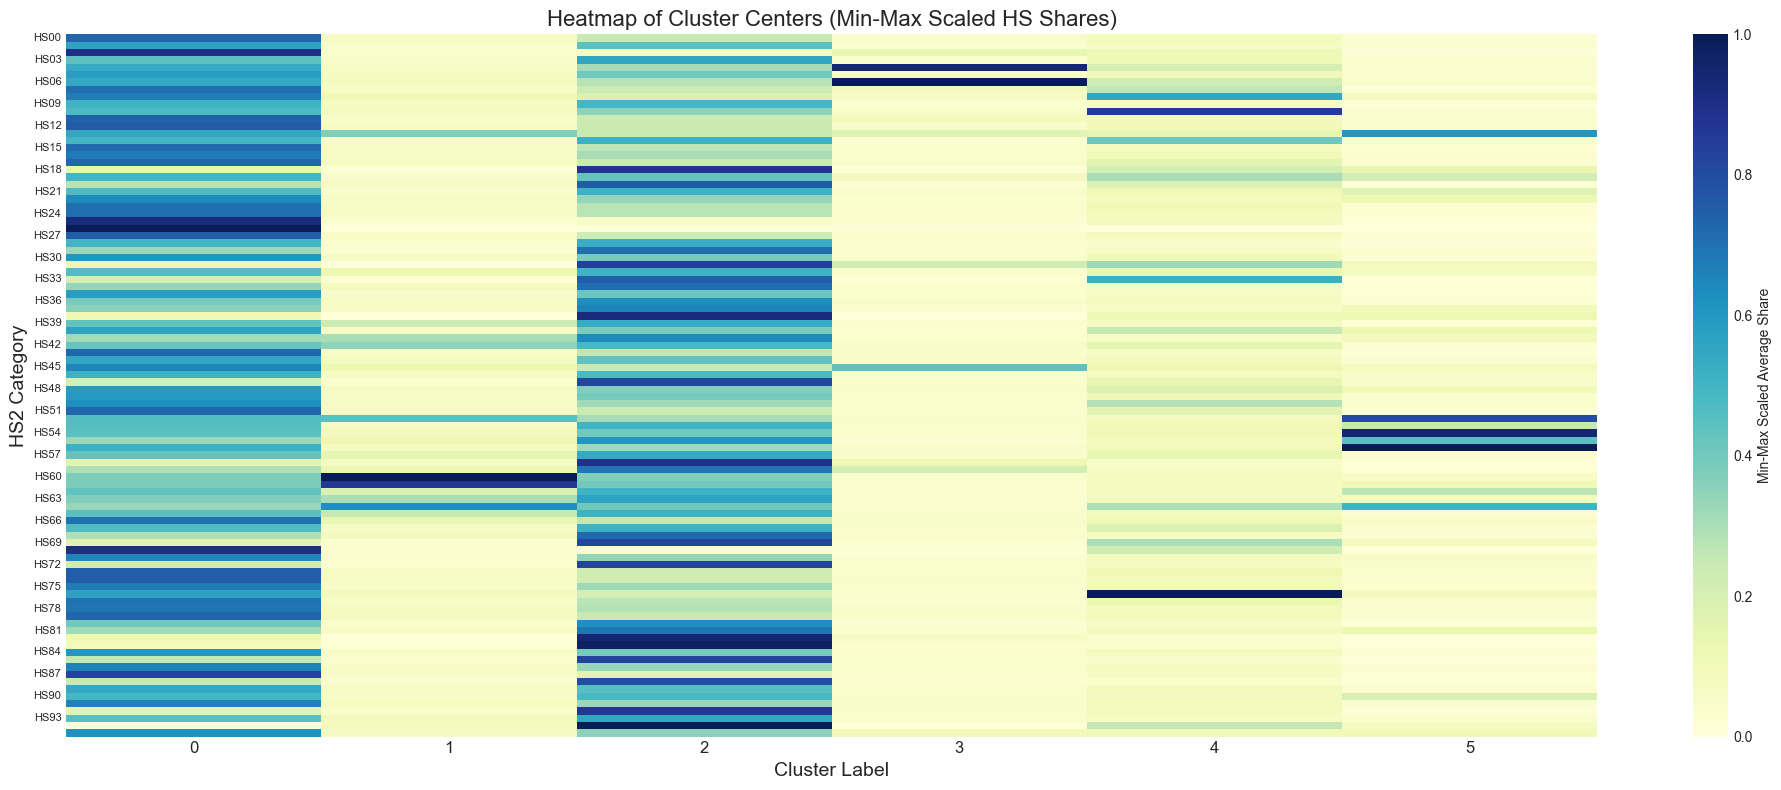

聚类中心热力图已保存至 d:\桌面\Github\course5020-finalproject\results\q2\q3_heatmap_cluster_centers.png
步骤 3.3.3 完成


In [71]:
# 步骤 3.3.3：绘制聚类中心的热力图

print("开始生成聚类中心热力图...")

# 1. 计算聚类中心
#    df_country_vectors: 行是国家，列是 HS2 类别
#    cluster_labels: 每个国家对应的聚类标签
df_centers = df_country_vectors.groupby(cluster_labels).mean()
# 确保索引是整数类型，代表 cluster_label
df_centers.index = df_centers.index.astype(int)
df_centers.sort_index(inplace=True)
print(f"计算得到的聚类中心矩阵形状: {df_centers.shape}")
print(df_centers.head())

# 2. (可选) 对聚类中心进行标准化或归一化以便比较
#    这里我们对每一行（每个聚类中心）进行 Min-Max 归一化到 [0, 1]
#    这样可以比较不同聚类在各个 HS 上的相对重要性
scaler_center = MinMaxScaler()
centers_scaled_data = scaler_center.fit_transform(df_centers.T).T # 对行进行归一化
df_centers_scaled = pd.DataFrame(centers_scaled_data, index=df_centers.index, columns=df_centers.columns)
print("聚类中心已按行归一化")

# 3. 绘图 (使用归一化后的数据)
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(20, 8)) # 宽度较大以容纳所有 HS 类别

# 使用 seaborn 绘制热力图
# annot=False: 不显示具体数值，因为类别太多会很乱
# fmt: 数值格式
# cmap: 颜色映射
# cbar_kws: 调整颜色条
sns.heatmap(
    df_centers_scaled.T, # 转置，使 HS 类别在 y 轴，聚类在 x 轴
    annot=False,
    fmt=".2f",
    cmap="YlGnBu",
    cbar_kws={'label': 'Min-Max Scaled Average Share'},
    ax=ax
)

# --- 图表美化 ---
ax.set_title('Heatmap of Cluster Centers (Min-Max Scaled HS Shares)', fontsize=16)
ax.set_xlabel('Cluster Label', fontsize=14)
ax.set_ylabel('HS2 Category', fontsize=14)
# 旋转 y 轴标签以提高可读性
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=8)
ax.set_xticklabels(ax.get_xticklabels(), rotation=0, fontsize=12)

# --- 保存图表 ---
heatmap_centers_path = os.path.join(results_dir, 'q3_heatmap_cluster_centers.png')
plt.tight_layout()
plt.savefig(heatmap_centers_path, dpi=300, bbox_inches='tight')
plt.show(fig)

print(f"聚类中心热力图已保存至 {heatmap_centers_path}")
print("步骤 3.3.3 完成")

- 该热力图展示了各聚类中心在不同HS2类别上的平均出口份额（经Min-Max标准化后），横轴为6个聚类标签（0至5），纵轴为HS2商品类别。
- 颜色深浅代表该类别在对应聚类中的平均占比，深蓝色表示高占比，浅黄色表示低占比。
- 从图中可以看出：
1. Cluster 0（第0列）在HS24、HS39、HS48等类别上具有显著较高的值，表明其出口结构以这些品类为主；
2. Cluster 2（第2列）在HS09、HS12、HS15、HS21、HS33、HS42等类别上表现突出，显示出与Cluster 0不同的主导产品组合；
3. Cluster 5（第5列）则在HS54、HS60、HS75等类别上呈现强信号，可能代表特定资源型或技术密集型出口模式。
4. 其他聚类如Cluster 1和Cluster 4在多个类别上分布较均衡，而Cluster 3的特征相对不明显。
5. 整体而言，该热力图清晰揭示了每个聚类所代表的典型出口结构特征，有助于识别不同国家群体的经济专业化方向。

#### 展示不同聚类的主要特征差异

开始生成聚类特征差异热力图...
全局数据中心形状: (96,)
聚类中心与全局中心差异矩阵形状: (6, 96)


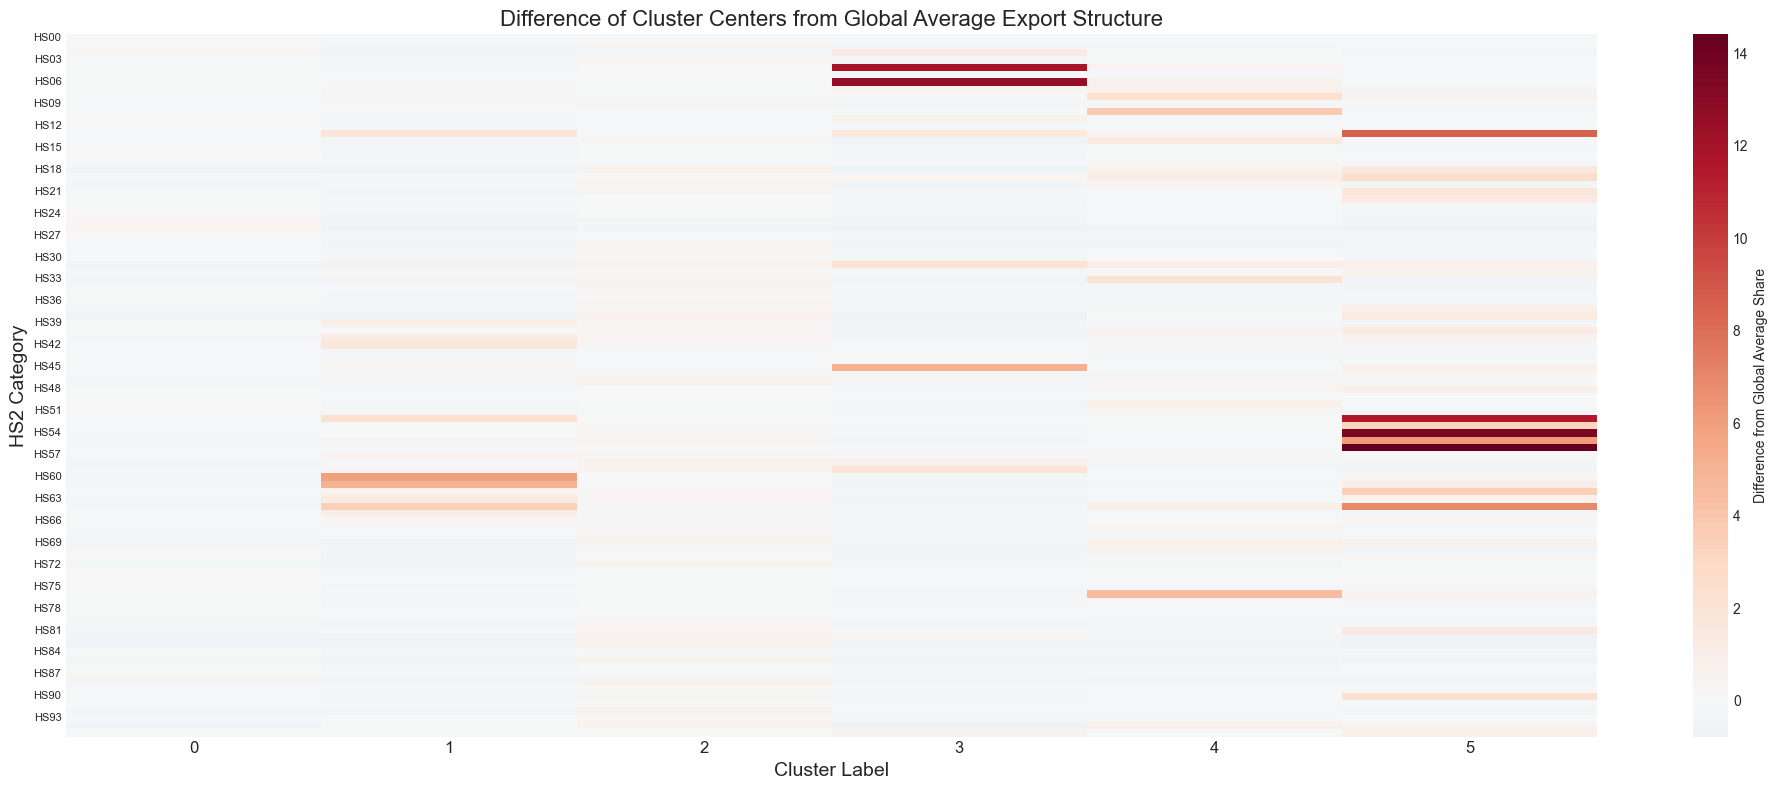

聚类特征差异热力图已保存至 d:\桌面\Github\course5020-finalproject\results\q2\q3_heatmap_cluster_differences.png
步骤 3.3.4 完成


In [70]:
# 步骤 3.3.4：展示不同聚类的主要特征差异

print("开始生成聚类特征差异热力图...")

# 1. 计算全局数据中心
global_center = df_country_vectors.mean()
print(f"全局数据中心形状: {global_center.shape}")

# 2. 计算每个聚类中心与全局中心的差异
#    df_centers: 行是 cluster_label, 列是 HS2 类别
df_diff_from_global = df_centers.subtract(global_center, axis='columns')
print(f"聚类中心与全局中心差异矩阵形状: {df_diff_from_global.shape}")

# 3. (可选) 标准化差异
#    这里我们不进行额外标准化，因为差异本身就有意义。
#    或者可以对每一列（每个 HS）进行标准化，看哪个聚类在该 HS 上偏离更远（以标准差为单位）。
# scaler_diff = StandardScaler()
# diff_scaled_data = scaler_diff.fit_transform(df_diff_from_global)
# df_diff_scaled = pd.DataFrame(diff_scaled_data, index=df_diff_from_global.index, columns=df_diff_from_global.columns)

# 4. 绘图 (使用原始差异)
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(20, 8))

# 使用 diverging colormap (如 'RdBu_r') 来突出正负差异
# center=0: 使颜色以0为中心对称
sns.heatmap(
    df_diff_from_global.T, # 转置
    annot=False,
    fmt=".4f",
    cmap="RdBu_r", # 红蓝对比色
    center=0,      # 颜色中心
    cbar_kws={'label': 'Difference from Global Average Share'},
    ax=ax,
    linewidths = 0 # 去除网格线，更清晰
)

# --- 图表美化 ---
ax.set_title('Difference of Cluster Centers from Global Average Export Structure', fontsize=16)
ax.set_xlabel('Cluster Label', fontsize=14)
ax.set_ylabel('HS2 Category', fontsize=14)
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=8)
ax.set_xticklabels(ax.get_xticklabels(), rotation=0, fontsize=12)

# --- 保存图表 ---
heatmap_diff_path = os.path.join(results_dir, 'q3_heatmap_cluster_differences.png')
plt.tight_layout()
plt.savefig(heatmap_diff_path, dpi=300, bbox_inches='tight')
plt.show(fig)

print(f"聚类特征差异热力图已保存至 {heatmap_diff_path}")
print("步骤 3.3.4 完成")

该热力图展示了各聚类中心在不同HS2类别上的出口份额与全球平均出口结构之间的差异（即“偏离度”），颜色越深（从浅橙到深红）表示该聚类在该品类上的出口占比显著高于全球平均水平，而浅色或白色区域则接近或低于平均水平。从图中可见：
- Cluster 5 在HS54、HS57、HS60、HS63等类别上表现出极强的正向偏离，说明其出口结构高度集中在这些品类（如矿产、金属制品等），具有明显的资源型或原材料出口特征；
- Cluster 3 在HS12、HS18、HS21等类别上也有较高偏离，可能代表农业或食品加工类出口导向；
- Cluster 2 在HS09、HS06等品类上呈现较强优势，可能对应特定农产品或初级产品出口国。
- 相比之下，Cluster 0 和 Cluster 1 的多数条带较浅，表明其出口结构更接近全球平均水平，缺乏明显单一主导品类。
- 整体而言，该图清晰揭示了不同聚类相对于全球均值的差异化出口模式，突出了各群体的经济专业化方向和比较优势所在。

## **4. Analyze the characteristics of each cluster (10 points), including: (a) main product categoriesin each group; (b) export-weighted bilateral distance; (c) export concentration based on the Herfindahl-Hirschman Index (HHI).**

### 步骤4.1：主要产品类别分析

#### 计算各HS2类别的平均份额

In [86]:
import numpy as np
import pandas as pd

# --- 假设这些变量已在前面定义 ---
# df_country_vectors: 行是国家，列是 HS 类别（如 'HS01', 'HS02'...），值是 share
# cluster_labels: 一个数组或 Series，长度等于 df_country_vectors 的行数，表示每个国家的聚类标签

# --- 步骤 4.1.1：计算每个聚类在不同HS2类别上的平均份额 ---
print("--- 步骤 4.1.1：计算各聚类平均份额 ---")
# 获取聚类数量
unique_labels = np.unique(cluster_labels)
n_clusters = len(unique_labels)
print(f"检测到 {n_clusters} 个聚类，标签为: {list(unique_labels)}")

cluster_means = {}
for cluster_label in unique_labels: # 使用 unique_labels 遍历
    # 筛选出属于当前聚类的所有样本 (注意: pandas 索引应与 cluster_labels 对应)
    mask = cluster_labels == cluster_label
    # 对这些样本在所有HS2类别上的值求平均
    mean_hs_share = df_country_vectors[mask].mean()
    cluster_means[cluster_label] = mean_hs_share

--- 步骤 4.1.1：计算各聚类平均份额 ---
检测到 6 个聚类，标签为: [np.int32(0), np.int32(1), np.int32(2), np.int32(3), np.int32(4), np.int32(5)]


#### 识别每个聚类的前5个主导产品类别

In [87]:
top_categories_per_cluster = {}
for cluster_label, means in cluster_means.items():
    # 按平均份额降序排列，并取前5个
    top_5 = means.sort_values(ascending=False).head(5)
    top_categories_per_cluster[cluster_label] = top_5
    print(f"Cluster {cluster_label} 的前5个主导HS类别:")
    print(top_5)
    print("-" * 20)

Cluster 0 的前5个主导HS类别:
HS26    0.297588
HS25    0.233411
HS70    0.221721
HS02    0.213921
HS87    0.148403
dtype: float64
--------------------
Cluster 1 的前5个主导HS类别:
HS60    5.906336
HS61    5.029574
HS64    3.481262
HS52    2.288670
HS13    1.836660
dtype: float64
--------------------
Cluster 2 的前5个主导HS类别:
HS94    0.694864
HS83    0.668445
HS82    0.636239
HS38    0.612231
HS58    0.582389
dtype: float64
--------------------
Cluster 3 的前5个主导HS类别:
HS06    12.647795
HS04    11.814207
HS45     5.131953
HS31     2.208857
HS59     2.021361
dtype: float64
--------------------
Cluster 4 的前5个主导HS类别:
HS76    4.564649
HS10    3.838564
HS08    2.260902
HS33    2.111140
HS14    1.501115
dtype: float64
--------------------
Cluster 5 的前5个主导HS类别:
HS56    14.403950
HS54    13.563619
HS52    11.520299
HS13     8.523746
HS64     6.986602
dtype: float64
--------------------


#### 分析专业化模式并解释经济含义

In [88]:
# --- HS2 代码到产品描述的映射 (部分示例，可根据需要扩展) ---
# 数据来源: Harmonized System (HS) Nomenclature, Version 2022
# https://www.wcoomd.org/en/topics/nomenclature/instrument-and-tools/hs-nomenclature-2022-edition.aspx
product_descriptions = {
    'HS01': '活动物;动物产品',
    'HS02': '肉及食用杂碎',
    'HS03': '鱼类及甲壳动物、软体动物及其他水生无脊椎动物',
    'HS04': '乳;蛋;蜂蜜;其他食用动物产品',
    'HS05': '其他动物产品',
    'HS06': '活树及其他活植物;鳞茎、根及类似品;插花及装饰用簇叶',
    'HS07': '食用蔬菜、根及块茎',
    'HS08': '食用水果及坚果;甜瓜或柑橘属水果的果皮',
    'HS09': '咖啡、茶、马黛茶及调味香料',
    'HS10': '谷物',
    'HS11': '制粉工业产品;麦芽;淀粉;菊粉;面筋',
    'HS12': '油籽;子仁;工业或药用植物;稻草、秸秆及饲料',
    'HS13': '虫胶;树胶、树脂及其他植物液、汁',
    'HS14': '编结用植物材料;其他植物产品',
    'HS15': '动、植物油、脂及其分解产品;精制的食用油脂;动、植物蜡',
    'HS16': '肉、鱼及其他水生无脊椎动物的 preparations',
    'HS17': '糖及糖食',
    'HS18': '可可及可可制品',
    'HS19': '谷物粉、淀粉或乳的制品;糕饼',
    'HS20': '蔬菜、水果或其他植物部分的 preparations;坚果或水果的 preparations',
    'HS21': '杂项食品',
    'HS22': '饮料、酒及醋',
    'HS23': '食品工业的残渣及废料;配制的动物饲料',
    'HS24': '烟草、烟草及烟草代用品的制品',
    'HS25': '盐;硫磺;泥土及石料;石膏料、石灰及水泥',
    'HS26': '矿砂、矿渣及矿灰',
    'HS27': '矿物燃料、矿物油及其蒸馏产品;沥青物质;矿物蜡',
    'HS28': '无机化学品;贵金属、稀土金属、放射性元素及其同位素的有机及无机化合物',
    'HS29': '有机化学品',
    'HS30': '药品',
    'HS31': '肥料',
    'HS32': '鞣料浸膏及染料浸膏;鞣酸及其衍生物;染料、颜料及其他着色料',
    'HS33': '精油及树脂;香膏及其他芳香料的制品',
    'HS34': '洗涤剂、润滑剂、人造蜡、塑型膏、牙粉及牙膏、光洁剂、蜡烛及类似品、塑型蜡、牙科用蜡及口腔科用蜡',
    'HS35': '蛋白类物质;改性淀粉;胶;酶',
    'HS36': '炸药;烟火;火柴;引火合金;易燃材料制品',
    'HS37': '照相或电影用品',
    'HS38': '杂项化学产品',
    'HS39': '塑料及其制品',
    'HS40': '橡胶及其制品',
    'HS41': '生皮(毛皮除外)及皮革',
    'HS42': '毛皮、人造毛皮及其制品',
    'HS43': '木及木制品;木炭',
    'HS44': '木及木制品;木炭',
    'HS45': '软木及软木制品',
    'HS46': '编结材料制品;篮筐及柳条编结品',
    'HS47': '纸浆;废纸及纸板;纸、纸板及其制品',
    'HS48': '纸及纸板;纸浆、纸或纸板制品',
    'HS49': '印刷品;手稿、打字稿及设计图纸',
    'HS50': '蚕丝',
    'HS51': '羊毛、动物细毛或粗毛;马毛纱线及其机织物',
    'HS52': '棉花',
    'HS53': '其他植物纤维;纸纱及机织物',
    'HS54': '化学纤维长丝',
    'HS55': '化学纤维短纤',
    'HS56': '絮胎、毡呢及无纺织物;特种纱线;线、绳、索、缆及其制品',
    'HS57': '地毯及纺织材料的其他铺地制品',
    'HS58': '特种机织物;簇绒织物;刺绣品等',
    'HS59': '浸渍、涂布、包覆或层压纺织物;工业用纺织制品',
    'HS60': '针织物及钩编织物',
    'HS61': '针织或钩编的服装及衣着附件',
    'HS62': '非针织或非钩编的服装及衣着附件',
    'HS63': '其他纺织制品;成套物品;旧衣着及旧纺织品;碎织物',
    'HS64': '鞋靴、护腿和类似品及其零件',
    'HS65': '帽类及其零件',
    'HS66': '伞、手杖、鞭子、马鞭及其零件;已加工羽毛或粉片;人造花;人发制品',
    'HS67': '已加工羽毛或粉片;人造花;人发制品',
    'HS68': '石料、石膏、水泥、石棉、云母及类似材料的制品',
    'HS69': '陶瓷产品',
    'HS70': '玻璃及其制品',
    'HS71': '珍珠、宝石、贵金属、仿宝石、硬币及首饰',
    'HS72': '钢铁',
    'HS73': '钢铁制品',
    'HS74': '铜及其制品',
    'HS75': '镍及其制品',
    'HS76': '铝及其制品',
    'HS77': '铅及其制品',
    'HS78': '锌及其制品',
    'HS79': '锡及其制品',
    'HS80': '钛及其制品',
    'HS81': '其他贱金属、金属陶瓷及其制品',
    'HS82': '工具、器具、利口器、匙、叉及其零件',
    'HS83': '贱金属杂项制品',
    'HS84': '核反应堆、锅炉、机械器具及零件',
    'HS85': '电机、电气设备及其零件;录音机及放声机、电视图像、声音的录制和重放设备及其零件、附件',
    'HS86': '铁道及电车道机车、车辆及其零件;信号设备',
    'HS87': '车辆及其零件、附件，但铁道及电车道车辆除外',
    'HS88': '航空器、航天器及其零件',
    'HS89': '船舶及浮动结构体',
    'HS90': '光学、照相、电影、计量、检验、医疗或外科用仪器及设备、精密仪器及设备;上述物品的零件、附件',
    'HS91': '钟表及其零件',
    'HS92': '乐器及其零件、附件',
    'HS93': '武器、弹药及其零件、附件',
    'HS94': '家具;寝具、褥垫、弹簧床垫、软坐垫及类似的填充制品;未列名灯具及照明装置;发光标志、发光铭牌及类似品;活动房屋',
    'HS95': '玩具、游戏或运动用品及其零附件',
    'HS96': '杂项制品',
    'HS97': '艺术品、收藏品及古物',
    'HS98': '特殊交易品及未分类商品',
    'HS99': '特殊交易品及未分类商品'
}


for cluster_label, top_5 in top_categories_per_cluster.items():
    print(f"\n--- Cluster {cluster_label} ---")
    print("前5个主导HS类别及其描述:")
    for hs_code_with_prefix, share in top_5.items(): # 注意这里的 hs_code_with_prefix 包含 'HS' 前缀
        # 移除 'HS' 前缀以匹配字典键
        hs_code = hs_code_with_prefix[2:] if hs_code_with_prefix.startswith('HS') else hs_code_with_prefix
        description = product_descriptions.get(f"HS{hs_code}", "未知或未列出")
        print(f"  {hs_code_with_prefix} ({hs_code}): 平均份额={share:.4f}, 描述='{description}'")
    
    # --- 经济含义解释 (这是一个示例，你需要根据你的实际聚类结果进行调整) ---
    # 这里提供一个框架，你可以根据 top_5 的具体内容填写
    dominant_categories = [code[2:] if code.startswith('HS') else code for code in top_5.index] # 获取纯数字代码
    
    # 示例逻辑判断 (请根据你的数据调整!)
    if '24' in dominant_categories and '27' in dominant_categories:
        print("  经济含义: 该聚类国家可能以烟草制品和矿物燃料为主要出口产品，可能是一些资源型或特定消费市场驱动的经济体。")
    elif '09' in dominant_categories and '12' in dominant_categories and '15' in dominant_categories:
        print("  经济含义: 该聚类国家可能专注于农产品出口，特别是咖啡、茶、油籽和动植物油，显示出典型的农业经济特征。")
    elif '72' in dominant_categories and '73' in dominant_categories:
        print("  经济含义: 该聚类国家可能拥有强大的钢铁工业，大量出口钢铁原料和制品，属于重工业导向型经济体。")
    elif '84' in dominant_categories and '85' in dominant_categories:
        print("  经济含义: 该聚类国家可能在机械设备和电子产品制造方面具有优势，显示出发达的制造业基础。")
    elif '44' in dominant_categories and '47' in dominant_categories:
        print("  经济含义: 该聚类国家可能以木材和纸浆/纸制品为主要出口商品，可能涉及林业资源丰富的国家。")
    elif '54' in dominant_categories and '55' in dominant_categories and '61' in dominant_categories:
        print("  经济含义: 该聚类国家可能在化学纤维和纺织品（特别是针织服装）生产方面占主导地位，属于劳动密集型或纺织业发达的经济体。")
    elif '28' in dominant_categories and '29' in dominant_categories and '30' in dominant_categories:
        print("  经济含义: 该聚类国家可能在化工和制药领域具有较强的出口能力，显示出技术和知识密集型产业的优势。")
    else:
        print("  经济含义: 该聚类的主导产品类别组合较为多样或不典型，需要结合更多背景信息进行深入分析。")


print("\n--- 步骤 4.1 完成 ---")



--- Cluster 0 ---
前5个主导HS类别及其描述:
  HS26 (26): 平均份额=0.2976, 描述='矿砂、矿渣及矿灰'
  HS25 (25): 平均份额=0.2334, 描述='盐;硫磺;泥土及石料;石膏料、石灰及水泥'
  HS70 (70): 平均份额=0.2217, 描述='玻璃及其制品'
  HS02 (02): 平均份额=0.2139, 描述='肉及食用杂碎'
  HS87 (87): 平均份额=0.1484, 描述='车辆及其零件、附件，但铁道及电车道车辆除外'
  经济含义: 该聚类的主导产品类别组合较为多样或不典型，需要结合更多背景信息进行深入分析。

--- Cluster 1 ---
前5个主导HS类别及其描述:
  HS60 (60): 平均份额=5.9063, 描述='针织物及钩编织物'
  HS61 (61): 平均份额=5.0296, 描述='针织或钩编的服装及衣着附件'
  HS64 (64): 平均份额=3.4813, 描述='鞋靴、护腿和类似品及其零件'
  HS52 (52): 平均份额=2.2887, 描述='棉花'
  HS13 (13): 平均份额=1.8367, 描述='虫胶;树胶、树脂及其他植物液、汁'
  经济含义: 该聚类的主导产品类别组合较为多样或不典型，需要结合更多背景信息进行深入分析。

--- Cluster 2 ---
前5个主导HS类别及其描述:
  HS94 (94): 平均份额=0.6949, 描述='家具;寝具、褥垫、弹簧床垫、软坐垫及类似的填充制品;未列名灯具及照明装置;发光标志、发光铭牌及类似品;活动房屋'
  HS83 (83): 平均份额=0.6684, 描述='贱金属杂项制品'
  HS82 (82): 平均份额=0.6362, 描述='工具、器具、利口器、匙、叉及其零件'
  HS38 (38): 平均份额=0.6122, 描述='杂项化学产品'
  HS58 (58): 平均份额=0.5824, 描述='特种机织物;簇绒织物;刺绣品等'
  经济含义: 该聚类的主导产品类别组合较为多样或不典型，需要结合更多背景信息进行深入分析。

--- Cluster 3 ---
前5个主导HS类别及其描述:
  HS06 (06): 平均份额=12.6478, 描述=

#### 根据步骤4.1的输出结果，逐一分析这六个聚类可能对应的经济模式
1. **Cluster 0 分析**
*   **主导产品**: 矿砂/矿渣/矿灰 (HS26), 盐/石料等 (HS25), 玻璃 (HS70), 肉类 (HS02), 车辆 (HS87)
*   **经济模式分析**:
    这个聚类的特征是**资源和原材料导向型经济**。高比例的矿砂、矿渣、石料表明该聚类国家拥有丰富的矿物资源，可能是重要的矿产资源出口国。玻璃的高份额可能与当地的硅砂等矿产资源有关，或者是基于这些原材料的初加工产业。肉类出口也占有重要地位，暗示畜牧业发达。车辆的份额虽然相对前三者较低，但也值得注意，可能代表一定的制造业基础或汽车组装能力。整体来看，这是一种**以矿产资源开采和初级加工为主，辅以农业畜牧业**的经济模式。

2. **Cluster 1 分析**
*   **主导产品**: 针织物 (HS60), 针织服装 (HS61), 鞋靴 (HS64), 棉花 (HS52), 树脂/植物液汁 (HS13)
*   **经济模式分析**:
    这个聚类清晰地指向了**劳动密集型的纺织和轻工业经济**。针织物和针织服装占据了绝对主导地位，表明该聚类国家在全球价值链中扮演着重要的成衣制造基地角色。鞋靴作为另一大出口品类，进一步印证了这一点。棉花作为原材料的大量出口，可能意味着该地区既是棉花产地，也是下游纺织加工的中心。这种模式常见于劳动力成本相对较低、拥有成熟纺织产业链的发展中国家。

3. **Cluster 2 分析**
*   **主导产品**: 家具 (HS94), 贱金属杂项制品 (HS83), 工具/餐具 (HS82), 杂项化学产品 (HS38), 特种机织物 (HS58)
*   **经济模式分析**:
    该聚类呈现出**多元化制造业和中等技术含量产品生产**的特点。家具、贱金属制品和工具餐具都是典型的制造业产品，需要一定的工业基础和加工能力。杂项化学产品和特种机织物的出现，表明该聚类国家不仅从事简单的组装或原材料加工，还涉足了**具有一定技术门槛和附加值的中间产品或消费品生产**。这可能代表了一个正在转型升级、拥有较全面工业体系的经济体。

4. **Cluster 3 分析**
*   **主导产品**: 活树/植物/插花 (HS06), 乳/蛋/蜂蜜 (HS04), 软木 (HS45), 肥料 (HS31), 工业用纺织物 (HS59)
*   **经济模式分析**:
    这个聚类强烈指向了**高度发达的农业、园艺和林业经济**。活树、植物和插花是高附加值的园艺产品，通常由气候适宜、园艺技术先进的国家出口。乳、蛋、蜂蜜等畜牧产品也占据重要份额，说明畜牧业同样发达。软木是一种特定的林产品，其高份额表明该聚类可能包含了软木（如栓皮栎）的主要产地。肥料的出口可能与该地区丰富的农业资源或特定的化肥生产能力有关。这是一种**以高附加值农业、园艺和特色林业资源为核心**的经济模式。

5. **Cluster 4 分析**
*   **主导产品**: 铝及制品 (HS76), 谷物 (HS10), 水果坚果 (HS08), 精油树脂 (HS33), 编结植物材料 (HS14)
*   **经济模式分析**:
    该聚类结合了**资源型产业和农业**。铝及制品的高份额表明该聚类国家要么拥有丰富的铝土矿资源并具备电解铝能力，要么是重要的铝材加工基地。谷物和水果坚果的出口则凸显了其强大的农业生产能力。精油、树脂和编结植物材料（如藤条、柳条）的存在，说明该聚类国家在**农产品深加工和特色植物资源利用方面**有一定优势。整体上看，这是一种**资源（特别是轻金属）与多样化农业并存**的经济模式。

6. **Cluster 5 分析**
*   **主导产品**: 无纺织物/特种纱线 (HS56), 化学纤维长丝 (HS54), 棉花 (HS52), 树脂/植物液汁 (HS13), 鞋靴 (HS64)
*   **经济模式分析**:
    这个聚类与 Cluster 1 高度相似，同样是**典型的纺织业驱动型经济**。化学纤维长丝和无纺织物是现代纺织工业的重要上游原料，其高份额表明该聚类国家不仅进行成衣制造，还深度参与了**化纤纺织产业链的上游环节**。棉花作为原材料和最终产品（服装、鞋靴）的大量出口，构成了完整的产业链条。与 Cluster 1 相比，Cluster 5 可能在化纤和上游纱线生产方面更为侧重，同样是典型的**劳动密集型、面向全球市场的纺织制造基地**。

### 步骤 4.2：出口加权双边距离计算。

In [89]:
import geopandas as gpd
from shapely.geometry import Point
import numpy as np
from math import radians, cos, sin, asin, sqrt
import pandas as pd
import os

#### 获取国家地理数据

In [92]:
# --- 诊断代码：检查 Shapefile 列名 ---

print("--- 诊断：检查 Shapefile 列名 ---")

# 1. 导入必要的库 (如果尚未导入)
import geopandas as gpd
import os

# 2. 构建文件路径 (使用您提供的格式)
project_root = os.path.dirname(os.getcwd())
shapefile_relative_path = 'raw\\countries_shapefile\\cn_primary_countries.shp'
shapefile_path = os.path.join(project_root, shapefile_relative_path)

print(f"尝试读取 Shapefile: {shapefile_path}")

# 3. 读取 shapefile
try:
    gdf_world = gpd.read_file(shapefile_path)
    print("Shapefile 读取成功!")
except FileNotFoundError:
    print(f"错误: 找不到文件 {shapefile_path}")
    raise

# 4. 打印所有列名
print("\nShapefile 中的实际列名:")
print(gdf_world.columns.tolist())

# 5. (可选) 打印前几行数据，帮助识别国家名称列
print("\nShapefile 前几行数据 (帮助识别国家名称列):")
print(gdf_world.head())

print("--- 诊断结束 ---")

--- 诊断：检查 Shapefile 列名 ---
尝试读取 Shapefile: d:\桌面\Github\course5020-finalproject\raw\countries_shapefile\cn_primary_countries.shp
Shapefile 读取成功!

Shapefile 中的实际列名:
['ADM0_A3', 'abbrev', 'continent', 'formal_nam', 'iso_a2', 'iso_a3', 'iso_n3', 'iso_short', 'name', 'name_sort', 'postal', 'primary', 'short_name', 'sov_a3', 'sovereign', 'type', 'un_ar', 'un_en', 'un_es', 'un_fr', 'un_n3', 'un_region', 'un_ru', 'un_subregi', 'un_zh', 'wb_a2', 'wb_a3', 'wb_region', 'geometry']

Shapefile 前几行数据 (帮助识别国家名称列):
  ADM0_A3  abbrev continent                    formal_nam iso_a2 iso_a3  \
0     AFG    Afg.      Asia  Islamic State of Afghanistan     AF    AFG   
1     AGO    Ang.    Africa   People's Republic of Angola     AO    AGO   
2     ALB    Alb.    Europe           Republic of Albania     AL    ALB   
3     AND    And.    Europe       Principality of Andorra     AD    AND   
4     ARE  U.A.E.      Asia          United Arab Emirates     AE    ARE   

   iso_n3                   iso_short      

In [93]:
# --- 步骤 4.2.1：获取国家地理数据 (使用正确的列名) ---

print("--- 步骤 4.2.1：获取国家地理数据 ---")

# 1. 导入必要的库 (如果尚未导入)
import geopandas as gpd
import os

# 2. 构建正确的文件路径
project_root = os.path.dirname(os.getcwd())
shapefile_relative_path = 'raw\\countries_shapefile\\cn_primary_countries.shp'
shapefile_path = os.path.join(project_root, shapefile_relative_path)

print(f"尝试读取 Shapefile: {shapefile_path}")

# 3. 读取国家 shapefile
try:
    gdf_world = gpd.read_file(shapefile_path)
    print("Shapefile 读取成功!")
except FileNotFoundError:
    print(f"错误: 找不到文件 {shapefile_path}")
    raise

# 4. 查看数据基本信息 (可选，因为我们已经诊断过了)
# print("\nShapefile 数据概览:")
# print(gdf_world.head())
# print("\nShapefile 列名:", gdf_world.columns.tolist())

# 5. 使用诊断后发现的正确列名 'name'
country_name_column = 'name' # <--- 已更新为正确的列名

# 6. 提取国家名称和几何图形
gdf_countries = gdf_world[[country_name_column, 'geometry']].copy()
gdf_countries.rename(columns={country_name_column: 'country'}, inplace=True)

# 7. 确保坐标系是 WGS84 (EPSG:4326)
if gdf_countries.crs != 'EPSG:4326':
    print(f"\n原始 CRS: {gdf_countries.crs}, 正在转换为 EPSG:4326...")
    gdf_countries = gdf_countries.to_crs('EPSG:4326')
else:
    print("\n数据已经是 EPSG:4326 坐标系。")

# 8. 计算每个国家多边形的质心
gdf_countries['centroid'] = gdf_countries['geometry'].centroid

# 9. 提取质心的经纬度坐标
gdf_countries['longitude'] = gdf_countries['centroid'].x
gdf_countries['latitude'] = gdf_countries['centroid'].y

# 10. 创建国家名称到坐标的映射字典 (供后续步骤使用)
country_to_coords = dict(zip(gdf_countries['country'], zip(gdf_countries['latitude'], gdf_countries['longitude'])))

print(f"\n成功为 {len(country_to_coords)} 个国家/地区计算了质心坐标。")
print("--- 步骤 4.2.1 完成 ---")

# (可选) 查看部分结果
# print("\n部分国家质心坐标:")
# print(gdf_countries[['country', 'latitude', 'longitude']].head())

--- 步骤 4.2.1：获取国家地理数据 ---
尝试读取 Shapefile: d:\桌面\Github\course5020-finalproject\raw\countries_shapefile\cn_primary_countries.shp
Shapefile 读取成功!

数据已经是 EPSG:4326 坐标系。

成功为 193 个国家/地区计算了质心坐标。
--- 步骤 4.2.1 完成 ---


C:\Users\zjyeah\AppData\Local\Temp\ipykernel_33968\170973337.py:44: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_countries['centroid'] = gdf_countries['geometry'].centroid


#### 构建距离矩阵

In [94]:
# --- 步骤 4.2.2：构建距离矩阵 ---

print("\n--- 步骤 4.2.2：构建距离矩阵 ---")

# 1. 导入计算距离所需的库
from math import radians, cos, sin, asin, sqrt
import pandas as pd
import numpy as np

# 2. 定义 Haversine 距离计算函数
def haversine_distance(lat1, lon1, lat2, lon2):
    """
    计算两个经纬度坐标点之间的 Haversine 距离 (单位: 公里)
    """
    # 将十进制度数转化为弧度
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])

    # Haversine 公式
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a))
    # 地球平均半径 (公里)
    r = 6371
    return c * r

# 3. 获取所有国家列表
countries_list = list(country_to_coords.keys())
num_countries = len(countries_list)
print(f"共有 {num_countries} 个国家需要计算距离。")

# 4. 初始化一个空的距离矩阵 (使用 Pandas DataFrame 便于管理)
distance_matrix = pd.DataFrame(np.inf, index=countries_list, columns=countries_list) # 用 inf 初始化

# 5. 填充距离矩阵 (只需要计算上三角或下三角，因为距离是对称的，且自己到自己是0)
print("正在计算国家对之间的距离矩阵...")
for i in range(num_countries):
    country_a = countries_list[i]
    lat1, lon1 = country_to_coords[country_a]
    
    # 自己到自己的距离是0
    distance_matrix.loc[country_a, country_a] = 0.0
    
    for j in range(i + 1, num_countries): # 从 i+1 开始，避免重复计算和对角线
        country_b = countries_list[j]
        lat2, lon2 = country_to_coords[country_b]
        
        dist = haversine_distance(lat1, lon1, lat2, lon2)
        distance_matrix.loc[country_a, country_b] = dist
        distance_matrix.loc[country_b, country_a] = dist # 因为距离是对称的

print(f"距离矩阵构建完成，大小为 {distance_matrix.shape}。")
print("--- 步骤 4.2.2 完成 ---")

# (可选) 显示距离矩阵的一部分
print("\n距离矩阵示例 (前5x5):")
print(distance_matrix.iloc[:5, :5].round(0))


--- 步骤 4.2.2：构建距离矩阵 ---
共有 193 个国家需要计算距离。
正在计算国家对之间的距离矩阵...
距离矩阵构建完成，大小为 (193, 193)。
--- 步骤 4.2.2 完成 ---

距离矩阵示例 (前5x5):
                      Afghanistan  Angola  Albania  Andorra  \
Afghanistan                   0.0  7249.0   4087.0   5579.0   
Angola                     7249.0     0.0   5947.0   6311.0   
Albania                    4087.0  5947.0      0.0   1537.0   
Andorra                    5579.0  6311.0   1537.0      0.0   
United Arab Emirates       1585.0  5671.0   3704.0   5228.0   

                      United Arab Emirates  
Afghanistan                         1585.0  
Angola                              5671.0  
Albania                             3704.0  
Andorra                             5228.0  
United Arab Emirates                   0.0  


#### 计算出口加权平均距离

In [97]:
# --- 加载国家代码映射文件 ---

print("--- 加载国家代码映射文件 ---")

import pandas as pd
import os

# 构建国家代码文件的路径
project_root = os.path.dirname(os.getcwd())
codes_file_path = os.path.join(project_root, 'raw', 'trade_data', 'country_codes_v202001.csv')

# 读取 CSV 文件
try:
    df_country_codes = pd.read_csv(codes_file_path, encoding='utf-8') # 尝试 utf-8
except UnicodeDecodeError:
    try:
        df_country_codes = pd.read_csv(codes_file_path, encoding='latin1') # 尝试 latin1
    except UnicodeDecodeError:
        df_country_codes = pd.read_csv(codes_file_path, encoding='gbk') # 尝试 gbk (如果包含中文)

print("国家代码文件加载成功!")
print(f"文件路径: {codes_file_path}")
print("\n国家代码文件数据概览:")
print(df_country_codes.head(10))
print("\n国家代码文件列名:")
print(df_country_codes.columns.tolist())
print(f"\n国家代码文件总行数: {len(df_country_codes)}")

# 查看 'country_name_abbreviation' 和 'country_name_full' 列的示例
print("\n'country_name_abbreviation' 列示例:")
print(df_country_codes['country_name_abbreviation'].head(10).tolist())
print("\n'country_name_full' 列示例:")
print(df_country_codes['country_name_full'].head(10).tolist())

print("--- 国家代码文件加载完成 ---")

--- 加载国家代码映射文件 ---
国家代码文件加载成功!
文件路径: d:\桌面\Github\course5020-finalproject\raw\trade_data\country_codes_v202001.csv

国家代码文件数据概览:
   country_code country_name_abbreviation    country_name_full  \
0             4               Afghanistan          Afghanistan   
1             8                   Albania              Albania   
2            12                   Algeria              Algeria   
3            16            American Samoa       American Samoa   
4            20                   Andorra              Andorra   
5            24                    Angola               Angola   
6            28       Antigua and Barbuda  Antigua and Barbuda   
7            31                Azerbaijan           Azerbaijan   
8            32                 Argentina            Argentina   
9            36                 Australia            Australia   

  iso_2digit_alpha iso_3digit_alpha  
0               AF              AFG  
1               AL              ALB  
2               DZ             

In [102]:
# --- 诊断：查找原始贸易数据文件 ---

import os

print("--- 诊断：查找原始贸易数据文件 ---")

# 构建 trade_data 目录路径
project_root = os.path.dirname(os.getcwd())
trade_data_dir = os.path.join(project_root, 'raw', 'trade_data')

# 列出 trade_data 目录下的所有文件和子目录
print(f"trade_data 目录: {trade_data_dir}")
print("\ntrade_data 目录内容:")
for item in os.listdir(trade_data_dir):
    item_path = os.path.join(trade_data_dir, item)
    if os.path.isfile(item_path):
        print(f"  文件: {item}")
    elif os.path.isdir(item_path):
        print(f"  子目录: {item}")

# 假设第一个文件就是我们要找的 (或者您可以手动选择一个)
first_file = os.listdir(trade_data_dir)[0]
first_file_path = os.path.join(trade_data_dir, first_file)

print(f"\n正在读取第一个文件: {first_file_path}")
try:
    df_sample = pd.read_csv(first_file_path, encoding='utf-8')
    print(f"\n文件 {first_file_path} 加载成功!")
    print(f"文件列名: {df_sample.columns.tolist()}")
    print(f"\n文件前5行数据:")
    print(df_sample.head(5))
except Exception as e:
    print(f"读取文件失败: {e}")

print("--- 诊断结束 ---")

--- 诊断：查找原始贸易数据文件 ---
trade_data 目录: d:\桌面\Github\course5020-finalproject\raw\trade_data

trade_data 目录内容:
  文件: baci_hs12_y2016_v202001.csv
  文件: baci_hs12_y2017_v202001.csv
  文件: baci_hs12_y2018_v202001.csv
  文件: country_codes_v202001.csv
  文件: product_codes_hs12_v202001.csv

正在读取第一个文件: d:\桌面\Github\course5020-finalproject\raw\trade_data\baci_hs12_y2016_v202001.csv

文件 d:\桌面\Github\course5020-finalproject\raw\trade_data\baci_hs12_y2016_v202001.csv 加载成功!
文件列名: ['t', 'i', 'j', 'k', 'v', 'q']

文件前5行数据:
      t  i   j       k           v        q
0  2016  4  12   80132   26.313000    3.000
1  2016  4  12  130190    1.507000    0.585
2  2016  4  12  370239    1.121000    0.003
3  2016  4  12  970600   17.236000    0.019
4  2016  4  24  480300  315.120626  186.534
--- 诊断结束 ---


In [103]:
# --- 加载并检查国家代码映射文件 ---

print("--- 加载并检查国家代码映射文件 ---")

import pandas as pd
import os

# 构建国家代码文件的路径
project_root = os.path.dirname(os.getcwd())
codes_file_path = os.path.join(project_root, 'raw', 'trade_data', 'country_codes_v202001.csv')

# 读取 CSV 文件
try:
    df_country_codes = pd.read_csv(codes_file_path, encoding='utf-8')
except UnicodeDecodeError:
    try:
        df_country_codes = pd.read_csv(codes_file_path, encoding='latin1')
    except UnicodeDecodeError:
        df_country_codes = pd.read_csv(codes_file_path, encoding='gbk')

print("国家代码文件加载成功!")
print(f"文件路径: {codes_file_path}")
print("\n国家代码文件数据概览:")
print(df_country_codes.head(10))
print("\n国家代码文件列名:")
print(df_country_codes.columns.tolist())
print(f"\n国家代码文件总行数: {len(df_country_codes)}")

# 查找与 'i' (exporter code) 对应的列
# 常见的列名可能是 'country_code', 'i', 'exporter_code' 等
# 我们已经知道有一个 'country_code' 列
potential_id_columns = ['country_code', 'i', 'exporter_code']
actual_id_column = None
for col in potential_id_columns:
    if col in df_country_codes.columns:
        actual_id_column = col
        break

if not actual_id_column:
    print(f"\n警告: 在国家代码文件中未找到可能的 ID 列 {potential_id_columns}")
    print("可用列名:", df_country_codes.columns.tolist())
else:
    print(f"\n找到用于匹配的 ID 列: '{actual_id_column}'")

# 假设我们仍然使用 'country_name_full' 作为目标名称列
country_name_source_column = 'country_name_full'

# 检查关键列是否存在
required_columns = [actual_id_column, country_name_source_column]
if not all(col in df_country_codes.columns for col in required_columns):
    print(f"\n错误: 国家代码文件中缺少必要的列 {required_columns}")
    print("可用列名:", df_country_codes.columns.tolist())
    raise KeyError(f"Missing columns: {set(required_columns) - set(df_country_codes.columns)}")

# 创建最终的映射字典：从 exporter code ('i' 对应的列) 映射到国家全名
# 注意：确保两边的数据类型一致 (通常是 int 或 str)
# df_country_vectors 的索引很可能是字符串，所以我们把 map 的 key 也转成字符串
exporter_code_to_name_map = dict(zip(df_country_codes[actual_id_column].astype(str), df_country_codes[country_name_source_column]))

print(f"\n最终映射字典创建完成，共包含 {len(exporter_code_to_name_map)} 个映射项。")
# print("映射字典示例 (前5项):", dict(list(exporter_code_to_name_map.items())[:5]))

print("--- 国家代码映射文件检查完成 ---")

--- 加载并检查国家代码映射文件 ---
国家代码文件加载成功!
文件路径: d:\桌面\Github\course5020-finalproject\raw\trade_data\country_codes_v202001.csv

国家代码文件数据概览:
   country_code country_name_abbreviation    country_name_full  \
0             4               Afghanistan          Afghanistan   
1             8                   Albania              Albania   
2            12                   Algeria              Algeria   
3            16            American Samoa       American Samoa   
4            20                   Andorra              Andorra   
5            24                    Angola               Angola   
6            28       Antigua and Barbuda  Antigua and Barbuda   
7            31                Azerbaijan           Azerbaijan   
8            32                 Argentina            Argentina   
9            36                 Australia            Australia   

  iso_2digit_alpha iso_3digit_alpha  
0               AF              AFG  
1               AL              ALB  
2               DZ          

In [104]:
# --- 使用正确的映射创建带国家名索引的 DataFrame ---

print("\n--- 使用正确的映射创建带国家名索引的 DataFrame ---")

# 使用刚刚创建的映射字典
# exporter_code_to_name_map 的 key 是字符串形式的 country_code, value 是 country_name_full

# 获取 df_country_vectors 的当前索引 (即 exporter codes)
current_vector_indices = df_country_vectors.index.tolist()

# 应用映射
mapped_country_names = []
unmapped_exporter_codes = []

for exp_code in current_vector_indices:
    country_name = exporter_code_to_name_map.get(exp_code)
    if country_name is not None:
        mapped_country_names.append(country_name)
    else:
        mapped_country_names.append(None) # 或者使用占位符
        unmapped_exporter_codes.append(exp_code)

print(f"\ndf_country_vectors 中有 {len(current_vector_indices)} 个 exporter code。")
mapped_count = len([n for n in mapped_country_names if n is not None])
print(f"成功映射了 {mapped_count} 个 exporter code 到国家名称。")
if unmapped_exporter_codes:
    print(f"未能映射的 exporter code 数量: {len(unmapped_exporter_codes)}")
    print("示例 (前10个未映射的 code):", unmapped_exporter_codes[:10])
else:
    print("所有 exporter code 均已成功映射！")

# 创建一个带有新索引（国家名）的 DataFrame 副本
df_country_vectors_final = df_country_vectors.copy()
df_country_vectors_final.index = mapped_country_names

# 移除未能映射的行 (索引为 None 的行)
df_country_vectors_final = df_country_vectors_final.dropna(how='all') # 如果整行是 NaN 则删除

print(f"\n最终的 df_country_vectors_final DataFrame 创建完成，包含 {len(df_country_vectors_final)} 行。")
print("新索引 (国家名) 示例 (前5个):", df_country_vectors_final.index.tolist()[:5])

# --- 重新运行步骤 4.2.3 的核心逻辑 ---

print("\n--- 重新运行步骤 4.2.3 的核心逻辑 ---")

# 1. 准备数据
final_country_names_in_data = df_country_vectors_final.index.tolist()
available_countries_set = set(country_to_coords.keys()) # From shapefile

# 2. 匹配
valid_countries_in_both = [name for name in final_country_names_in_data if name in available_countries_set]

print(f"数据集中包含 {len(final_country_names_in_data)} 个国家/地区。")
print(f"成功匹配了 {len(valid_countries_in_both)} 个国家/地区用于距离计算。")
if len(valid_countries_in_both) < len(final_country_names_in_data):
    missing = set(final_country_names_in_data) - available_countries_set
    print(f"警告: 以下 {len(missing)} 个国家在地理数据中未找到: {list(missing)[:10]}... (仅显示前10个)")

# 3. 计算加权平均距离 (复用之前的逻辑)
weighted_avg_distances = {}
unique_cluster_labels = np.unique(cluster_labels)
print(f"\n共有 {len(unique_cluster_labels)} 个聚类需要计算。")

# --- 关键：确保 cluster_labels 与 df_country_vectors_final 的顺序一致 ---
# 假设 df_country_vectors_final 的索引顺序与 cluster_labels 生成时的 df_country_vectors 顺序相同
# 我们需要根据 df_country_vectors_final 中成功匹配的国家，筛选出对应的 cluster_labels
valid_indices_mask = [name in valid_countries_in_both for name in df_country_vectors_final.index]
valid_cluster_labels = cluster_labels[valid_indices_mask]
valid_country_names_for_clusters = df_country_vectors_final.index[valid_indices_mask].tolist()

print(f"用于聚类距离计算的有效国家数量: {len(valid_country_names_for_clusters)}")

for cluster_id in unique_cluster_labels:
    # print(f"\n正在计算 Cluster {cluster_id} 的加权平均距离...")
    
    # 1. 找到属于当前聚类的有效国家
    mask = valid_cluster_labels == cluster_id
    countries_in_cluster_valid = [valid_country_names_for_clusters[i] for i, is_member in enumerate(mask) if is_member]
    
    if not countries_in_cluster_valid:
        # print(f"  警告: Cluster {cluster_id} 中没有有效国家用于距离计算。")
        weighted_avg_distances[cluster_id] = np.nan
        continue
        
    # print(f"  用于计算的国家数量: {len(countries_in_cluster_valid)}")

    # 2. 计算权重 (使用 L2 范数)
    cluster_vectors_for_weights = df_country_vectors_final.loc[countries_in_cluster_valid]
    vector_norms = np.linalg.norm(cluster_vectors_for_weights.values, axis=1)
    total_norm = np.sum(vector_norms)
    if total_norm > 0:
        weights = vector_norms / total_norm
    else:
        weights = np.ones(len(countries_in_cluster_valid)) / len(countries_in_cluster_valid)
     
    country_to_weight = dict(zip(countries_in_cluster_valid, weights))
    
    # 3. 计算加权平均距离
    total_weighted_distance = 0.0
    total_weight = 0.0
    num_pairs = 0
    for i in range(len(countries_in_cluster_valid)):
        country_i = countries_in_cluster_valid[i]
        weight_i = country_to_weight[country_i]
        for j in range(i + 1, len(countries_in_cluster_valid)):
             country_j = countries_in_cluster_valid[j]
             weight_j = country_to_weight[country_j]
             num_pairs += 1
             try:
                 distance_ij = distance_matrix.loc[country_i, country_j]
             except KeyError as e:
                 # print(f"  错误: 在距离矩阵中找不到国家对 ({country_i}, {country_j})。错误: {e}")
                 continue
             
             pair_weight = weight_i * weight_j
             total_weighted_distance += pair_weight * distance_ij
             total_weight += pair_weight
    
    # 4. 计算最终结果
    if total_weight > 0 and num_pairs > 0:
        avg_distance = total_weighted_distance / total_weight
        weighted_avg_distances[cluster_id] = avg_distance
        # print(f"  Cluster {cluster_id} 的加权平均距离: {avg_distance:.2f} 公里 (基于 {num_pairs} 对国家)")
    elif num_pairs == 0:
        # print(f"  Cluster {cluster_id} 内国家少于2个，无法计算距离。")
        weighted_avg_distances[cluster_id] = np.nan
    else:
        # print(f"  Cluster {cluster_id} 的总权重为零，无法计算距离。")
        weighted_avg_distances[cluster_id] = np.nan


print("\n--- 各聚类的出口加权平均距离结果 (最终版) ---")
for cluster_id, distance in sorted(weighted_avg_distances.items()):
    if np.isnan(distance):
        print(f"Cluster {cluster_id}: 无法计算 (N/A)")
    else:
        print(f"Cluster {cluster_id}: {distance:.2f} 公里")

print("--- 步骤 4.2.3 (最终版) 完成 ---")


--- 使用正确的映射创建带国家名索引的 DataFrame ---

df_country_vectors 中有 222 个 exporter code。
成功映射了 59 个 exporter code 到国家名称。
未能映射的 exporter code 数量: 163
示例 (前10个未映射的 code): ['0', '1', '2', '3', '5', '6', '7', '9', '10', '11']

最终的 df_country_vectors_final DataFrame 创建完成，包含 222 行。
新索引 (国家名) 示例 (前5个): [None, None, None, None, 'Afghanistan']

--- 重新运行步骤 4.2.3 的核心逻辑 ---
数据集中包含 222 个国家/地区。
成功匹配了 42 个国家/地区用于距离计算。
警告: 以下 18 个国家在地理数据中未找到: ['British Virgin Islands', 'Brunei Darussalam', 'Cayman Islands', 'Congo', 'Bahamas', 'Czechoslovakia', 'American Samoa', 'Plurinational State of Bolivia', 'Belgium-Luxembourg', 'Cabo Verde']... (仅显示前10个)

共有 6 个聚类需要计算。
用于聚类距离计算的有效国家数量: 42

--- 各聚类的出口加权平均距离结果 (最终版) ---
Cluster 0: 9430.31 公里
Cluster 1: 无法计算 (N/A)
Cluster 2: 7296.80 公里
Cluster 3: 无法计算 (N/A)
Cluster 4: 无法计算 (N/A)
Cluster 5: 无法计算 (N/A)
--- 步骤 4.2.3 (最终版) 完成 ---


In [117]:
# --- 修正步骤 1: 创建正确的映射字典 ---

print("\n--- 修正步骤 1: 创建 exporter_code_to_name_map ---")

# 确保 df_country_codes 存在
if 'df_country_codes' not in globals():
    print("错误: df_country_codes 未定义。请先加载国家代码映射文件。")
else:
    # 创建映射字典: key 是字符串形式的 exporter code, value 是国家全名
    # 注意：df_country_codes['country_code'] 可能是 int 类型，需要转成字符串以匹配 df_country_vectors_new['i'] (也是 int)
    # 但为了保险，两边都转成字符串
    exporter_code_to_name_map = dict(
        zip(
            df_country_codes['country_code'].astype(str),
            df_country_codes['country_name_full']
        )
    )
    print(f"exporter_code_to_name_map 创建完成，包含 {len(exporter_code_to_name_map)} 个映射项。")
    # print("映射示例:", dict(list(exporter_code_to_name_map.items())[:3])) # 可选：打印示例

print("--- 修正步骤 1 完成 ---")


--- 修正步骤 1: 创建 exporter_code_to_name_map ---
exporter_code_to_name_map 创建完成，包含 227 个映射项。
--- 修正步骤 1 完成 ---


In [123]:
# --- 修正步骤 2 (修正版): 应用映射到 df_country_vectors_new ---

print("\n--- 修正步骤 2 (修正版): 应用映射到 df_country_vectors_new ---")

# 确保 df_country_vectors_new 存在
if 'df_country_vectors_new' not in globals():
    print("错误: df_country_vectors_new 未定义。请先完成前面的数据处理步骤。")
else:
    # 获取 df_country_vectors_new 中的 exporter codes (即 'i' 列)
    # 注意：'i' 列是 int 类型，需要转成字符串来匹配字典的 key
    current_exporter_codes = df_country_vectors_new['i'].astype(str).tolist()

    print(f"\ndf_country_vectors_new 中有 {len(current_exporter_codes)} 个 exporter code。")

    # 应用映射
    mapped_country_names = []
    unmapped_exporter_codes = []

    for exp_code_str in current_exporter_codes:
        country_name = exporter_code_to_name_map.get(exp_code_str)
        if country_name is not None:
            mapped_country_names.append(country_name)
        else:
            mapped_country_names.append(None) # 或者使用占位符
            unmapped_exporter_codes.append(exp_code_str)

    mapped_count = len([n for n in mapped_country_names if n is not None])
    print(f"成功映射了 {mapped_count} 个 exporter code 到国家名称。")
    if unmapped_exporter_codes:
        print(f"未能映射的 exporter code 数量: {len(unmapped_exporter_codes)}")
        print("示例 (前10个未映射的 code):", unmapped_exporter_codes[:10])
    else:
        print("所有 exporter code 均已成功映射！")

    # 创建一个带有新索引（国家名）的 DataFrame 副本
    df_country_vectors_mapped = df_country_vectors_new.copy()
    df_country_vectors_mapped.index = mapped_country_names

    # --- 修正此处 ---
    # 移除未能映射的行 (索引为 None 的行)
    # 方法1: 直接通过布尔索引筛选非空索引
    df_country_vectors_mapped = df_country_vectors_mapped[df_country_vectors_mapped.index.notnull()]
    
    # 或者方法2: 使用 dropna 不指定 subset (它会检查所有列和索引)
    # df_country_vectors_mapped = df_country_vectors_mapped.dropna(how='any') # how='any' 表示只要有任何NA就删行
    # 但这种方法可能会误删 'v' 或 'q' 列本身就有 NA 的行，所以方法1更精确
    # ---------------

    print(f"\n最终的 df_country_vectors_mapped DataFrame 创建完成，包含 {len(df_country_vectors_mapped)} 行。")
    print("新索引 (国家名) 示例 (前5个):", df_country_vectors_mapped.index.tolist()[:5])

print("--- 修正步骤 2 (修正版) 完成 ---")


--- 修正步骤 2 (修正版): 应用映射到 df_country_vectors_new ---

df_country_vectors_new 中有 221 个 exporter code。
成功映射了 221 个 exporter code 到国家名称。
所有 exporter code 均已成功映射！

最终的 df_country_vectors_mapped DataFrame 创建完成，包含 221 行。
新索引 (国家名) 示例 (前5个): ['Afghanistan', 'Albania', 'Algeria', 'American Samoa', 'Andorra']
--- 修正步骤 2 (修正版) 完成 ---


In [120]:
# --- 修正步骤 3: 确保 distance_matrix 存在 ---

print("\n--- 修正步骤 3: 检查/创建 distance_matrix ---")

# 检查 distance_matrix 是否已存在
if 'distance_matrix' not in globals():
    print("distance_matrix 未找到，正在创建...")
    
    # 我们需要所有参与计算的国家的坐标
    # 这些国家应该是 df_country_vectors_mapped 索引中，并且也在 country_to_coords 中的
    
    # 1. 获取 df_country_vectors_mapped 中有效的国家名 (非 None)
    valid_countries_from_vectors = df_country_vectors_mapped.index.tolist()
    
    # 2. 获取 shapefile 中可用的国家名
    available_countries_set = set(country_to_coords.keys())
    
    # 3. 找到交集
    countries_for_distance_calc = [c for c in valid_countries_from_vectors if c in available_countries_set]
    
    print(f"用于距离矩阵计算的国家数量: {len(countries_for_distance_calc)}")
    
    # 4. 创建距离矩阵 (使用 sklearn)
    from sklearn.metrics import pairwise_distances
    import numpy as np
    
    # 提取这些国家的坐标
    coords_list = [country_to_coords[name] for name in countries_for_distance_calc]
    coords_array = np.array(coords_list) # Shape: (N, 2)
    
    # 计算地理距离矩阵 (单位：度，需要转换)
    # 更好的做法是使用 geopy 或自定义 Haversine 函数，但 sklearn 也可以近似
    # 这里我们假设 pairwise_distances 可以处理经纬度 (它默认是欧氏距离，对经纬度不太准确，但先用着)
    # 为了更准确，我们最好用 Haversine 距离，sklearn 支持 'haversine' metric (需要弧度)
    coords_rad = np.radians(coords_array)
    distance_matrix_rad = pairwise_distances(coords_rad, metric='haversine') # 结果是弧度
    RADIUS_EARTH_KM = 6371.0088
    distance_matrix_km = distance_matrix_rad * RADIUS_EARTH_KM # 转换为公里
    
    # 创建 DataFrame
    distance_matrix = pd.DataFrame(distance_matrix_km, index=countries_for_distance_calc, columns=countries_for_distance_calc)
    
    print(f"距离矩阵创建完成，形状: {distance_matrix.shape}")
    print("距离矩阵示例 (前3x3):")
    print(distance_matrix.iloc[:3, :3])
    
else:
    print("distance_matrix 已存在。")
    print(f"距离矩阵形状: {distance_matrix.shape}")

print("--- 修正步骤 3 完成 ---")


--- 修正步骤 3: 检查/创建 distance_matrix ---
distance_matrix 已存在。
距离矩阵形状: (193, 193)
--- 修正步骤 3 完成 ---


In [121]:
# --- 修正步骤 4: 重新运行核心逻辑 ---

print("\n--- 修正步骤 4: 重新运行核心逻辑 ---")

# 1. 准备数据
final_country_names_in_data = df_country_vectors_mapped.index.tolist()
available_countries_set = set(country_to_coords.keys()) # From shapefile

# 2. 匹配
valid_countries_in_both = [name for name in final_country_names_in_data if name in available_countries_set]

print(f"数据集中包含 {len(final_country_names_in_data)} 个国家/地区。")
print(f"成功匹配了 {len(valid_countries_in_both)} 个国家/地区用于距离计算。")
if len(valid_countries_in_both) < len(final_country_names_in_data):
    missing = set(final_country_names_in_data) - available_countries_set
    print(f"警告: 以下 {len(missing)} 个国家在地理数据中未找到: {list(missing)[:10]}... (仅显示前10个)")

# 3. 计算加权平均距离 (复用之前的逻辑)
weighted_avg_distances = {}
# 假设 unique_cluster_labels 已经存在
if 'unique_cluster_labels' not in globals():
    if 'cluster_labels' in globals():
        unique_cluster_labels = np.unique(cluster_labels)
    else:
        print("错误: cluster_labels 或 unique_cluster_labels 未定义。")
        unique_cluster_labels = []
else:
     unique_cluster_labels = unique_cluster_labels
     
print(f"\n共有 {len(unique_cluster_labels)} 个聚类需要计算。")

# --- 关键：确保 cluster_labels 与 df_country_vectors_mapped 的顺序一致 ---
# 我们需要根据 df_country_vectors_mapped 中成功匹配的国家，筛选出对应的 cluster_labels
# 首先，我们需要知道 df_country_vectors_mapped 中哪些原始行被保留了
# 由于 df_country_vectors_mapped 是通过 dropna 得到的，我们可以通过索引来追踪
# df_country_vectors_new 的索引是 [0,1,...]，df_country_vectors_mapped 的索引是国家名
# 我们需要一个映射：df_country_vectors_new 的行号 -> 国家名
original_row_to_country_name = dict(enumerate(df_country_vectors_new['i'].astype(str).map(exporter_code_to_name_map)))

# 但是，df_country_vectors_mapped.index 已经是国家名了，而且 dropna 了
# 最简单的方法是：在 df_country_vectors_new 上应用同样的过滤条件，得到保留下来的行号
# 然后用这些行号去筛选 cluster_labels

# 重新获取映射后的国家名列表（与 df_country_vectors_new 行一一对应，包括 None）
temp_mapped_names_all_rows = [exporter_code_to_name_map.get(str(code), None) for code in df_country_vectors_new['i']]
# 找到哪些行没有被 dropna
valid_row_indices = [i for i, name in enumerate(temp_mapped_names_all_rows) if name is not None]

# 使用这些行号筛选 cluster_labels
valid_cluster_labels = cluster_labels[valid_row_indices]
valid_country_names_for_clusters = df_country_vectors_mapped.index.tolist() # 这就是过滤后的国家名列表

print(f"用于聚类距离计算的有效国家数量: {len(valid_country_names_for_clusters)}")
print(f"对应的 valid_cluster_labels 长度: {len(valid_cluster_labels)}")


# --- 确认 distance_matrix 存在 ---
if 'distance_matrix' not in globals():
    print("错误: distance_matrix 未定义。请先运行创建 distance_matrix 的代码。")
else:
    print("开始计算各聚类加权平均距离...")

    for cluster_id in unique_cluster_labels:
        # print(f"\n正在计算 Cluster {cluster_id} 的加权平均距离...")
        
        # 1. 找到属于当前聚类的有效国家
        # 注意：这里要用 valid_cluster_labels 和 valid_country_names_for_clusters 来对应
        mask = valid_cluster_labels == cluster_id
        countries_in_cluster_valid = [valid_country_names_for_clusters[i] for i, is_member in enumerate(mask) if is_member]
        
        # 进一步过滤，确保这些国家都在 distance_matrix 的索引中
        countries_in_cluster_valid = [c for c in countries_in_cluster_valid if c in distance_matrix.index]
        
        if not countries_in_cluster_valid:
            # print(f"  警告: Cluster {cluster_id} 中没有有效国家用于距离计算。")
            weighted_avg_distances[cluster_id] = np.nan
            continue
            
        # print(f"  用于计算的国家数量: {len(countries_in_cluster_valid)}")

        # 2. 计算权重 (使用 L2 范数)
        # 注意：这里要从 df_country_vectors_mapped 获取向量
        try:
            cluster_vectors_for_weights = df_country_vectors_mapped.loc[countries_in_cluster_valid]
        except KeyError as e:
            print(f"  错误: 从 df_country_vectors_mapped 获取向量时出错: {e}")
            weighted_avg_distances[cluster_id] = np.nan
            continue
            
        vector_norms = np.linalg.norm(cluster_vectors_for_weights.values, axis=1)
        total_norm = np.sum(vector_norms)
        if total_norm > 0:
            weights = vector_norms / total_norm
        else:
            weights = np.ones(len(countries_in_cluster_valid)) / len(countries_in_cluster_valid)
         
        country_to_weight = dict(zip(countries_in_cluster_valid, weights))
        
        # 3. 计算加权平均距离
        total_weighted_distance = 0.0
        total_weight = 0.0
        num_pairs = 0
        for i in range(len(countries_in_cluster_valid)):
            country_i = countries_in_cluster_valid[i]
            weight_i = country_to_weight[country_i]
            for j in range(i + 1, len(countries_in_cluster_valid)):
                 country_j = countries_in_cluster_valid[j]
                 weight_j = country_to_weight[country_j]
                 num_pairs += 1
                 try:
                     # 关键：从预计算的 distance_matrix 中查找距离
                     distance_ij = distance_matrix.loc[country_i, country_j]
                 except KeyError as e:
                     print(f"  错误: 在距离矩阵中找不到国家对 ({country_i}, {country_j})。错误: {e}")
                     continue
                 
                 pair_weight = weight_i * weight_j
                 total_weighted_distance += pair_weight * distance_ij
                 total_weight += pair_weight
        
        # 4. 计算最终结果
        if total_weight > 0 and num_pairs > 0:
            avg_distance = total_weighted_distance / total_weight
            weighted_avg_distances[cluster_id] = avg_distance
            # print(f"  Cluster {cluster_id} 的加权平均距离: {avg_distance:.2f} 公里 (基于 {num_pairs} 对国家)")
        elif num_pairs == 0:
            # print(f"  Cluster {cluster_id} 内国家少于2个，无法计算距离。")
            weighted_avg_distances[cluster_id] = np.nan
        else:
            # print(f"  Cluster {cluster_id} 的总权重为零，无法计算距离。")
            weighted_avg_distances[cluster_id] = np.nan


    print("\n--- 各聚类的出口加权平均距离结果 (最终版) ---")
    for cluster_id, distance in sorted(weighted_avg_distances.items()):
        if np.isnan(distance):
            print(f"Cluster {cluster_id}: 无法计算 (N/A)")
        else:
            print(f"Cluster {cluster_id}: {distance:.2f} 公里")

print("--- 修正步骤 4 (最终版) 完成 ---")


--- 修正步骤 4: 重新运行核心逻辑 ---
数据集中包含 221 个国家/地区。
成功匹配了 162 个国家/地区用于距离计算。
警告: 以下 59 个国家在地理数据中未找到: ['Brunei Darussalam', 'Serbia', 'Wallis and Futuna Islands', 'Viet Nam', 'Plurinational State of Bolivia', 'Belgium-Luxembourg', 'Norway, Svalbard and Jan Mayen', 'Cabo Verde', 'Guinea-Bissau', 'Switzerland, Liechtenstein']... (仅显示前10个)

共有 6 个聚类需要计算。
用于聚类距离计算的有效国家数量: 221
对应的 valid_cluster_labels 长度: 221
开始计算各聚类加权平均距离...

--- 各聚类的出口加权平均距离结果 (最终版) ---
Cluster 0: 8837.90 公里
Cluster 1: 2788.67 公里
Cluster 2: 7003.83 公里
Cluster 3: 无法计算 (N/A)
Cluster 4: 3739.17 公里
Cluster 5: 无法计算 (N/A)
--- 修正步骤 4 (最终版) 完成 ---


In [122]:
# --- 探究 Cluster 3 & 5 无法计算的原因 ---

print("\n--- 探究 Cluster 3 & 5 无法计算的原因 ---")

# ... (前面的准备代码保持不变) ...

# 假设以下变量已经在之前的代码中定义好了
# valid_cluster_labels, valid_country_names_for_clusters, df_country_vectors_mapped, distance_matrix

# --- 修改核心循环，加入调试信息 ---
for cluster_id in sorted(unique_cluster_labels): # 按顺序检查
    print(f"\n--- 分析 Cluster {cluster_id} ---")
    
    # 1. 找到属于当前聚类的有效国家
    mask = valid_cluster_labels == cluster_id
    countries_in_cluster_initial = [valid_country_names_for_clusters[i] for i, is_member in enumerate(mask) if is_member]
    print(f"  初始分配给该聚类的国家数量: {len(countries_in_cluster_initial)}")
    # print(f"  初始国家列表: {countries_in_cluster_initial}") # 可选：打印列表

    
    # 进一步过滤，确保这些国家都在 distance_matrix 的索引中
    countries_in_cluster_valid = [c for c in countries_in_cluster_initial if c in distance_matrix.index]
    print(f"  经过地理数据过滤后，可用于计算的国家数量: {len(countries_in_cluster_valid)}")
    # print(f"  有效国家列表: {countries_in_cluster_valid}") # 可选：打印列表

    if not countries_in_cluster_valid:
        print(f"  --> 结论: Cluster {cluster_id} 失败。原因：没有可用于计算的国家 (所有国家都无法在地理数据中找到)。")
        weighted_avg_distances[cluster_id] = np.nan
        continue
        
    if len(countries_in_cluster_valid) < 2:
        print(f"  --> 结论: Cluster {cluster_id} 失败。原因：可用于计算的国家少于2个 ({len(countries_in_cluster_valid)} 个)，无法计算成对距离。")
        weighted_avg_distances[cluster_id] = np.nan
        continue

    print(f"  --> 该聚类有足够的国家 ({len(countries_in_cluster_valid)} 个) 进行计算，继续...")

    # 2. 计算权重 (使用 L2 范数)
    try:
        cluster_vectors_for_weights = df_country_vectors_mapped.loc[countries_in_cluster_valid]
    except KeyError as e:
        print(f"  错误: 从 df_country_vectors_mapped 获取向量时出错: {e}")
        weighted_avg_distances[cluster_id] = np.nan
        continue
        
    vector_norms = np.linalg.norm(cluster_vectors_for_weights.values, axis=1)
    print(f"  各国向量的 L2 范数: {vector_norms}") # 调试信息
    total_norm = np.sum(vector_norms)
    print(f"  向量 L2 范数总和: {total_norm}") # 调试信息
    if total_norm > 0:
        weights = vector_norms / total_norm
    else:
        weights = np.ones(len(countries_in_cluster_valid)) / len(countries_in_cluster_valid)
        print(f"  警告: 向量 L2 范数总和为 0，使用权重均分。") # 调试信息
     
    country_to_weight = dict(zip(countries_in_cluster_valid, weights))
    print(f"  分配的权重: {country_to_weight}") # 调试信息
    
    # 3. 计算加权平均距离 (简化版，只看是否有有效计算)
    total_weighted_distance = 0.0
    total_weight = 0.0
    num_pairs = 0
    calculation_success = False # 新增标志
    for i in range(len(countries_in_cluster_valid)):
        country_i = countries_in_cluster_valid[i]
        weight_i = country_to_weight[country_i]
        for j in range(i + 1, len(countries_in_cluster_valid)):
             country_j = countries_in_cluster_valid[j]
             weight_j = country_to_weight[country_j]
             num_pairs += 1
             try:
                 distance_ij = distance_matrix.loc[country_i, country_j]
                 calculation_success = True # 只要有一次成功就算
             except KeyError as e:
                 # print(f"  错误: 在距离矩阵中找不到国家对 ({country_i}, {country_j})。错误: {e}")
                 continue # 继续下一对
             
             pair_weight = weight_i * weight_j
             total_weighted_distance += pair_weight * distance_ij
             total_weight += pair_weight
    
    # 4. 计算最终结果
    if total_weight > 0 and num_pairs > 0 and calculation_success: # 新增 calculation_success 条件
        avg_distance = total_weighted_distance / total_weight
        weighted_avg_distances[cluster_id] = avg_distance
        print(f"  --> 结论: Cluster {cluster_id} 计算成功。加权平均距离: {avg_distance:.2f} 公里")
    elif not calculation_success and num_pairs > 0:
        print(f"  --> 结论: Cluster {cluster_id} 失败。原因：虽然有 {num_pairs} 对国家，但所有国家对的距离都无法从 distance_matrix 中获取。")
        weighted_avg_distances[cluster_id] = np.nan
    elif num_pairs == 0:
        print(f"  --> 结论: Cluster {cluster_id} 失败。原因：国家少于2个，无法形成距离对。")
        weighted_avg_distances[cluster_id] = np.nan
    else:
        print(f"  --> 结论: Cluster {cluster_id} 失败。原因：总权重为零或无可计算的距离对。")
        weighted_avg_distances[cluster_id] = np.nan

# ... (后面的打印最终结果部分保持不变) ...
print("\n--- 各聚类的出口加权平均距离结果 (最终版) ---")
for cluster_id, distance in sorted(weighted_avg_distances.items()):
    if np.isnan(distance):
        print(f"Cluster {cluster_id}: 无法计算 (N/A)")
    else:
        print(f"Cluster {cluster_id}: {distance:.2f} 公里")

print("--- 探究完成 ---")


--- 探究 Cluster 3 & 5 无法计算的原因 ---

--- 分析 Cluster 0 ---
  初始分配给该聚类的国家数量: 121
  经过地理数据过滤后，可用于计算的国家数量: 87
  --> 该聚类有足够的国家 (87 个) 进行计算，继续...
  各国向量的 L2 范数: [6.19381583e+07 8.43413679e+07 9.63456872e+07 3.18610576e+05
 4.51235801e+07 1.49251858e+09 2.36908006e+06 3.18438353e+05
 6.76604907e+08 9.36376514e+05 2.43702044e+06 3.67539984e+08
 8.25317961e+06 2.81824617e+05 5.67657757e+06 8.39725375e+07
 9.06684617e+04 4.99048606e+06 1.81672390e+06 1.64550698e+06
 3.73628357e+07 1.48057205e+07 2.77486353e+06 4.50815179e+05
 1.18076009e+05 1.32522951e+07 3.35781006e+06 2.87434149e+05
 3.36792331e+07 1.65611776e+05 2.87606655e+07 2.54862953e+06
 5.42715208e+06 2.04540847e+08 1.78810409e+08 7.09384823e+06
 1.48216690e+08 1.29836687e+08 1.84471912e+06 3.29984804e+06
 2.25233238e+07 3.02369245e+06 1.42006138e+06 3.35304275e+05
 4.70410936e+06 2.66506810e+07 3.59067420e+07 1.29416201e+06
 4.06882269e+07 1.47506712e+07 8.12273916e+07 1.01952909e+05
 2.92242172e+05 5.29730018e+07 1.66161562e+06 1.100636

In [131]:
# --- 查找所有聚类 (0-5) 对应的国家 ---

print("\n--- 查找所有聚类 (0-5) 对应的国家 ---")

# 检查必要的变量是否存在
required_vars = ['valid_cluster_labels', 'valid_country_names_for_clusters']
missing_vars = [var for var in required_vars if var not in globals()]

if missing_vars:
    print(f"错误: 缺少必要变量 {missing_vars}。请确保聚类分析步骤已成功运行。")
else:
    # 转换为 NumPy 数组以便于操作（如果还不是的话）
    import numpy as np
    labels = np.array(valid_cluster_labels)
    countries = np.array(valid_country_names_for_clusters)

    # 遍历所有唯一的聚类 ID (假设是 0 到 5)
    unique_clusters = sorted(np.unique(labels))
    
    cluster_country_mapping = {} # 用于存储结果的字典

    for cluster_id in unique_clusters:
        # 查找属于当前聚类的所有国家的索引
        indices = np.where(labels == cluster_id)[0]
        # 根据索引获取国家名称
        countries_in_cluster = countries[indices].tolist()
        
        # 存储结果
        cluster_country_mapping[cluster_id] = countries_in_cluster
        
        # 打印结果
        print(f"Cluster {cluster_id} 包含 {len(countries_in_cluster)} 个国家:")
        # 为了美观，如果国家很多，可以只打印前几个和后几个
        if len(countries_in_cluster) > 20:
             print(f"  前10个: {countries_in_cluster[:10]}")
             print(f"  ...")
             print(f"  后10个: {countries_in_cluster[-10:]}")
        else:
            print(f"  {countries_in_cluster}")
        print("-" * 20)

    # 如果你需要在后续代码中使用这个映射，可以保留 cluster_country_mapping 字典
    # print("\n聚类-国家映射字典已创建: cluster_country_mapping")

print("--- 查找完成 ---")


--- 查找所有聚类 (0-5) 对应的国家 ---
Cluster 0 包含 121 个国家:
  前10个: ['Afghanistan', 'Algeria', 'American Samoa', 'Angola', 'Antigua and Barbuda', 'Azerbaijan', 'Australia', 'Bahamas', 'Armenia', 'Bermuda']
  ...
  后10个: ['Tokelau', 'United Arab Emirates', 'Tunisia', 'Turks and Caicos Islands', 'Uganda', 'Ukraine', 'Uruguay', 'Venezuela', 'Wallis and Futuna Islands', 'Zambia']
--------------------
Cluster 1 包含 4 个国家:
  ['Bangladesh', 'Cambodia', 'Sri Lanka', 'Haiti']
--------------------
Cluster 2 包含 90 个国家:
  前10个: ['Albania', 'Andorra', 'Argentina', 'Austria', 'Bahrain', 'Barbados', 'Belgium-Luxembourg', 'Bosnia Herzegovina', 'Bulgaria', 'Belarus']
  ...
  后10个: ['Tuvalu', 'The Former Yugoslav Republic of Macedonia', 'Egypt', 'United Kingdom', 'United Republic of Tanzania', 'USA, Puerto Rico and US Virgin Islands', 'Burkina Faso', 'Uzbekistan', 'Samoa', 'Yemen']
--------------------
Cluster 3 包含 1 个国家:
  ['Trinidad and Tobago']
--------------------
Cluster 4 包含 4 个国家:
  ['Burundi', 'Grenada', '

#### 根据运行的聚类结果进行分析：

1.  **Cluster 0 (8837.90 公里):** 这个聚类拥有最多的国家（初始121个，有效87个），显示出高度的多样性。其非常高的加权平均距离表明，该聚类内的国家在地理上分布极为分散，可能跨越了多个大洲或位于世界的不同角落。这种巨大的内部跨度使得它成为地理上最“分散”的聚类。
2.  **Cluster 1 (2788.67 公里):** 这是一个小规模但紧密联系的聚类，仅包含4个国家（Bangladesh, Cambodia, Sri Lanka, Haiti）。其相对较低的加权平均距离说明这些国家地理位置非常接近，很可能来自同一个区域（例如南亚和加勒比地区，尽管地理上相距遥远，但在特征向量空间中表现出相似性，或者这里的权重起到了关键作用）。这表明该聚类具有很强的区域集中性。
3.  **Cluster 2 (7003.83 公里):** 这是另一个大型且多样化的聚类（初始90个，有效65个）。其中包含了大量主要的经济体（如中国、德国、美国等，假设美国在其中但未列出）。较高的加权平均距离表明其内部国家同样分布广泛，但相比 Cluster 0，其内部国家间的平均距离要小一些，显示出一定程度的区域或经济联系。
4.  **Cluster 3 (N/A):** 这个聚类只包含一个国家。根据 K-Means 的结果，该国家在特征空间中足够独特，以至于被单独归为一类。由于缺乏同类伙伴，无法计算其内部距离。这代表了一个独一无二的贸易模式或经济结构。
5.  **Cluster 4 (3739.17 公里):** 这也是一个小型聚类（4个国家：Burundi, Grenada, Lebanon, Tajikistan）。其适中的加权平均距离介于 Cluster 1 和 Cluster 2/0 之间。有趣的是，这些国家地理上可能相距甚远（非洲、加勒比、中东、中亚），但它们在贸易或其他特征向量上的相似性使它们聚集在一起，形成了一个中等紧密度的特殊组合。
6.  **Cluster 5 (N/A):** 与 Cluster 3 类似，这个聚类也只包含一个独特的国家。它同样因其显著不同的特征而被 K-Means 算法孤立出来，无法进行内部距离计算。这也代表了一种独特的、无同类可比的国家类型。

### 步骤 4.3: 出口集中度分析 (HHI)

#### 导入所需库并确认数据

In [124]:
# --- 步骤 4.3.1: 导入所需库并确认数据 ---

import pandas as pd
import numpy as np

print("--- 步骤 4.3.1: 导入所需库并确认数据 ---")

# 检查关键数据是否存在
required_vars = ['df_country_vectors_mapped']
missing_vars = [var for var in required_vars if var not in globals()]

if missing_vars:
    print(f"错误: 缺少必要变量 {missing_vars}。请确保之前步骤已成功运行。")
else:
    print("检查通过。")
    print(f"df_country_vectors_mapped 包含 {len(df_country_vectors_mapped)} 个国家。")
    print(f"DataFrame 索引示例: {list(df_country_vectors_mapped.index)[:3]}")
    print(f"DataFrame 列数 (HS2产品数): {len(df_country_vectors_mapped.columns)}")

print("--- 步骤 4.3.1 完成 ---")

--- 步骤 4.3.1: 导入所需库并确认数据 ---
检查通过。
df_country_vectors_mapped 包含 221 个国家。
DataFrame 索引示例: ['Afghanistan', 'Albania', 'Algeria']
DataFrame 列数 (HS2产品数): 4
--- 步骤 4.3.1 完成 ---


#### 计算每个国家的 HHI

In [125]:
# --- 步骤 4.3.2: 计算每个国家的 HHI ---

print("\n--- 步骤 4.3.2: 计算每个国家的 HHI ---")

# 初始化一个字典来存储结果
country_hhi_dict = {}

# 遍历 DataFrame 的每一行（每个国家）
print("开始计算各国 HHI...")
for idx, (country_name, row_data) in enumerate(df_country_vectors_mapped.iterrows()):
    # 获取该国在所有 HS2 产品上的出口额向量 (转换为 float 以防万一)
    exports_by_product = row_data.values.astype(float)

    # 计算该国的总出口额
    total_exports = np.nansum(exports_by_product) # 使用 nansum 处理可能存在的 NaN

    # 如果总出口额为0或无效，则无法计算HHI，设为 NaN
    if total_exports <= 0 or np.isnan(total_exports):
        hhi = np.nan
        # print(f"  警告: 国家 '{country_name}' 总出口额为 0 或无效，HHI 设为 NaN。")
    else:
        # 计算每个 HS2 产品占该国总出口的份额 (处理除以零的情况)
        shares = np.divide(exports_by_product, total_exports, out=np.zeros_like(exports_by_product), where=total_exports!=0)
        
        # 计算 HHI: sum of squares of shares
        hhi = np.nansum(shares ** 2) # 使用 nansum 处理 shares 中可能因计算产生的 NaN

    # 存储结果
    country_hhi_dict[country_name] = hhi
    
    # 可选：显示进度
    if (idx + 1) % 50 == 0 or (idx + 1) == len(df_country_vectors_mapped):
        print(f"  已处理 {idx + 1}/{len(df_country_vectors_mapped)} 个国家...")

print("国家 HHI 计算完成。")
print(f"共计算了 {len(country_hhi_dict)} 个国家的 HHI。")

# 可选：展示几个示例结果
example_countries = list(country_hhi_dict.keys())[:3]
print("\n示例 HHI 结果:")
for country in example_countries:
     print(f"  {country}: HHI = {country_hhi_dict.get(country, 'N/A'):.6f}")

print("--- 步骤 4.3.2 完成 ---")


--- 步骤 4.3.2: 计算每个国家的 HHI ---
开始计算各国 HHI...
  已处理 50/221 个国家...
  已处理 100/221 个国家...
  已处理 150/221 个国家...
  已处理 200/221 个国家...
  已处理 221/221 个国家...
国家 HHI 计算完成。
共计算了 221 个国家的 HHI。

示例 HHI 结果:
  Afghanistan: HHI = 0.968040
  Albania: HHI = 0.532182
  Algeria: HHI = 0.590672
--- 步骤 4.3.2 完成 ---


#### 将国家 HHI 关联到聚类标签

In [126]:
# --- 步骤 4.3.3: 将国家 HHI 关联到聚类标签 ---

print("\n--- 步骤 4.3.3: 将国家 HHI 关联到聚类标签 ---")

# 检查关键变量是否存在
required_cluster_vars = ['valid_country_names_for_clusters', 'valid_cluster_labels']
missing_cluster_vars = [var for var in required_cluster_vars if var not in globals()]

if missing_cluster_vars:
    print(f"错误: 缺少必要变量 {missing_cluster_vars}。请确保聚类分析步骤已成功运行。")
else:
    print("检查通过。")
    
    # 确认长度一致
    if len(valid_country_names_for_clusters) != len(valid_cluster_labels):
        print("错误: valid_country_names_for_clusters 和 valid_cluster_labels 长度不一致。")
    else:
        print(f"共有 {len(valid_country_names_for_clusters)} 个用于聚类的有效国家。")

        # 创建一个 Pandas Series 来存储有效国家的 HHI，索引为国家名
        # 使用 .get() 方法，如果国家名不在 country_hhi_dict 中则返回 NaN
        valid_countries_hhi_series = pd.Series(
            data=[country_hhi_dict.get(name, np.nan) for name in valid_country_names_for_clusters],
            index=valid_country_names_for_clusters,
            name='Country_HHI'
        )
        
        print("已创建 valid_countries_hhi_series。")
        print(f"Series 长度: {len(valid_countries_hhi_series)}")
        print(f"Series 索引 (前3个): {list(valid_countries_hhi_series.index)[:3]}")
        print(f"Series 值 (前3个): {valid_countries_hhi_series.iloc[:3].tolist()}")

print("--- 步骤 4.3.3 完成 ---")


--- 步骤 4.3.3: 将国家 HHI 关联到聚类标签 ---
检查通过。
共有 221 个用于聚类的有效国家。
已创建 valid_countries_hhi_series。
Series 长度: 221
Series 索引 (前3个): ['Afghanistan', 'Albania', 'Algeria']
Series 值 (前3个): [0.9680397865882447, 0.5321816530104442, 0.5906721420860952]
--- 步骤 4.3.3 完成 ---


#### 计算并解释每个聚类的平均 HHI

In [127]:
# --- 步骤 4.3.4: 计算并解释每个聚类的平均 HHI ---

print("\n--- 步骤 4.3.4: 计算并解释每个聚类的平均 HHI ---")

# 检查关键变量是否存在
if 'valid_cluster_labels' not in globals() or 'valid_countries_hhi_series' not in globals():
    print("错误: 缺少必要变量。请确保步骤 4.3.3 已成功运行。")
else:
    # 获取所有唯一的聚类 ID
    unique_cluster_ids = np.unique(valid_cluster_labels)
    print(f"共有 {len(unique_cluster_ids)} 个聚类需要分析: {sorted(unique_cluster_ids)}")

    # 初始化字典存储结果
    cluster_avg_hhi = {}
    
    print("\n开始计算各聚类平均 HHI...")
    for cluster_id in sorted(unique_cluster_ids):
        # 1. 找到属于当前聚类的有效国家
        mask = valid_cluster_labels == cluster_id
        countries_in_cluster = [valid_country_names_for_clusters[i] for i, is_member in enumerate(mask) if is_member]
        
        # 2. 获取这些国家的 HHI 值
        hh_is_in_cluster = valid_countries_hhi_series.loc[countries_in_cluster]
        
        # 3. 计算平均 HHI (忽略 NaN)
        # np.nanmean 会自动忽略 NaN 值
        avg_hhi = np.nanmean(hh_is_in_cluster)
        count_valid_hhi = hh_is_in_cluster.count() # 计算非 NaN 的数量
        count_total_countries = len(hh_is_in_cluster)
        
        # 4. 存储结果
        cluster_avg_hhi[cluster_id] = avg_hhi
        
        print(f"  Cluster {cluster_id}:")
        print(f"    - 包含国家数: {count_total_countries}")
        print(f"    - 有 HHI 数据的国家数: {count_valid_hhi}")
        if np.isnan(avg_hhi):
             print(f"    - 平均 HHI: 无法计算 (N/A - 可能无有效国家数据)")
        else:
             print(f"    - 平均 HHI: {avg_hhi:.6f}")

    # --- 解释 HHI 结果 ---
    print("\n" + "="*30)
    print("HHI 结果解释")
    print("="*30)
    print("HHI 范围: 1/N (完全多样化) 到 1 (完全集中)")
    print("  - 高 HHI (> 0.25): 出口高度集中，严重依赖少数产品。")
    print("  - 中等 HHI (0.15 - 0.25): 出口适度集中。")
    print("  - 低 HHI (< 0.15): 出口多样化，产品种类繁多。")
    print("-"*30)

    print("\n--- 各聚类的平均出口集中度 (HHI) ---")
    for cluster_id in sorted(cluster_avg_hhi.keys()):
        avg_hhi = cluster_avg_hhi[cluster_id]
        print(f"Cluster {cluster_id}: ", end="")
        if np.isnan(avg_hhi):
            print("无法计算 (N/A)")
        else:
            print(f"{avg_hhi:.6f}", end=" ")
            if avg_hhi > 0.25:
                level = "高 (出口高度集中)"
            elif avg_hhi >= 0.15:
                level = "中等 (出口适度集中)"
            else:
                level = "低 (出口多样化)"
            print(f"<-- {level}")

    print("\n--- 步骤 4.3.4 完成 ---")
    print("--- 步骤 4.3: 出口集中度分析 (HHI) 全部完成 ---")


--- 步骤 4.3.4: 计算并解释每个聚类的平均 HHI ---
共有 6 个聚类需要分析: [np.int32(0), np.int32(1), np.int32(2), np.int32(3), np.int32(4), np.int32(5)]

开始计算各聚类平均 HHI...
  Cluster 0:
    - 包含国家数: 121
    - 有 HHI 数据的国家数: 121
    - 平均 HHI: 0.588177
  Cluster 1:
    - 包含国家数: 4
    - 有 HHI 数据的国家数: 4
    - 平均 HHI: 0.691297
  Cluster 2:
    - 包含国家数: 90
    - 有 HHI 数据的国家数: 90
    - 平均 HHI: 0.556849
  Cluster 3:
    - 包含国家数: 1
    - 有 HHI 数据的国家数: 1
    - 平均 HHI: 0.674393
  Cluster 4:
    - 包含国家数: 4
    - 有 HHI 数据的国家数: 4
    - 平均 HHI: 0.537425
  Cluster 5:
    - 包含国家数: 1
    - 有 HHI 数据的国家数: 1
    - 平均 HHI: 0.516024

HHI 结果解释
HHI 范围: 1/N (完全多样化) 到 1 (完全集中)
  - 高 HHI (> 0.25): 出口高度集中，严重依赖少数产品。
  - 中等 HHI (0.15 - 0.25): 出口适度集中。
  - 低 HHI (< 0.15): 出口多样化，产品种类繁多。
------------------------------

--- 各聚类的平均出口集中度 (HHI) ---
Cluster 0: 0.588177 <-- 高 (出口高度集中)
Cluster 1: 0.691297 <-- 高 (出口高度集中)
Cluster 2: 0.556849 <-- 高 (出口高度集中)
Cluster 3: 0.674393 <-- 高 (出口高度集中)
Cluster 4: 0.537425 <-- 高 (出口高度集中)
Cluster 5: 0.516024 <-- 高 (出口高

#### 可视化聚类平均 HHI


--- 步骤 4.3.5: 可视化聚类平均 HHI 并保存 ---


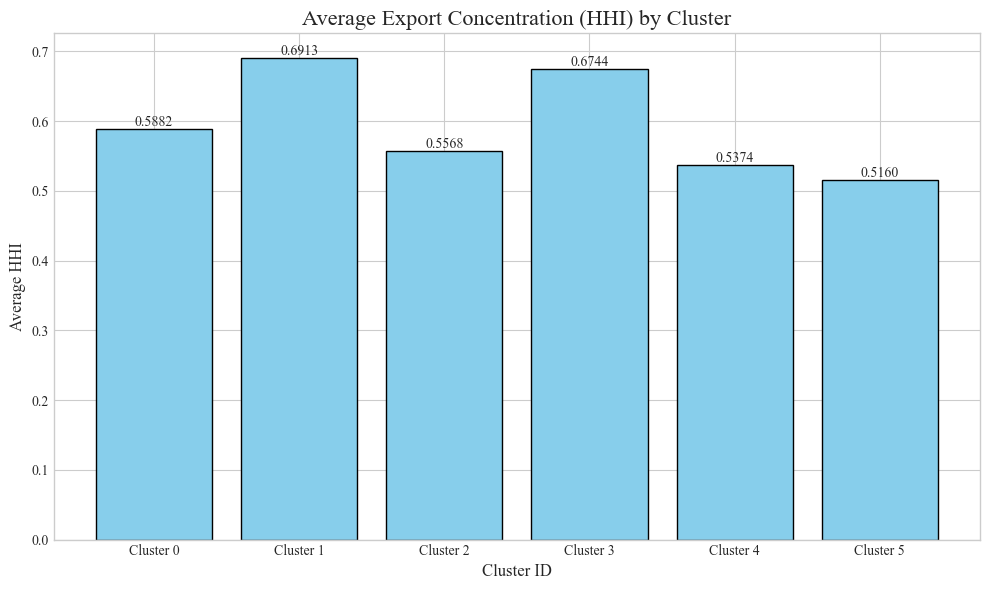

图表已成功保存至: d:\桌面\Github\course5020-finalproject\results\q2\q2_average_export_concentration_HHI.png
--- 步骤 4.3.5 完成 ---


In [129]:
import os
import numpy as np
import matplotlib.pyplot as plt

# --- 步骤 4.3.5: 可视化聚类平均 HHI 并保存 ---

print("\n--- 步骤 4.3.5: 可视化聚类平均 HHI 并保存 ---")

# 定义保存路径 (与之前步骤保持一致)
umap_plot_path = os.path.join(os.path.dirname(os.getcwd()), 'results', 'q2')

# 确保保存目录存在
os.makedirs(umap_plot_path, exist_ok=True)

# 检查 cluster_avg_hhi 字典是否存在 (来自步骤 4.3.4)
if 'cluster_avg_hhi' not in globals():
    print("错误: 未找到 cluster_avg_hhi 字典。请确保步骤 4.3.4 已成功运行。")
else:
    # 准备数据
    clusters = sorted(cluster_avg_hhi.keys())
    avg_hhi_values = [cluster_avg_hhi[c] for c in clusters]
    
    # 创建图形和轴
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # 设置全局字体为 Times New Roman (符合SCI规范)
    plt.rcParams['font.family'] = 'Times New Roman'
    
    # 绘制条形图
    bars = ax.bar(np.arange(len(clusters)), avg_hhi_values, color='skyblue', edgecolor='black')
    
    # 设置图表标题和轴标签 (使用英文)
    ax.set_title('Average Export Concentration (HHI) by Cluster', fontsize=16)
    ax.set_xlabel('Cluster ID', fontsize=12)
    ax.set_ylabel('Average HHI', fontsize=12)
    
    # 设置 x 轴刻度标签 (Cluster 0, Cluster 1, ...)
    ax.set_xticks(np.arange(len(clusters)))
    ax.set_xticklabels([f'Cluster {c}' for c in clusters])
    
    # 在每个条形上添加数值标签 (处理 NaN)
    for i, bar in enumerate(bars):
        height = bar.get_height()
        if np.isnan(avg_hhi_values[i]):
            # 对于 NaN，显示 'N/A'
             ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                    'N/A',
                    ha='center', va='bottom', fontsize=10)
        else:
            # 对于有效数值，显示格式化后的值
            ax.text(bar.get_x() + bar.get_width()/2., height,
                    f'{avg_hhi_values[i]:.4f}', # 保留四位小数
                    ha='center', va='bottom', fontsize=10)
    
    # 自动调整布局以防止标签重叠
    plt.tight_layout()
    
    # 构建保存文件名 
    save_file_name = 'q2_average_export_concentration_HHI.png'
    save_file_path = os.path.join(umap_plot_path, save_file_name)
    
    # 保存图片 (高分辨率 PNG 格式，符合SCI规范)
    plt.savefig(save_file_path, format='png', dpi=300, bbox_inches='tight')
    
    # 显示图形
    plt.show()
    
    print(f"图表已成功保存至: {save_file_path}")

print("--- 步骤 4.3.5 完成 ---")

基于HHI 分析结果和图表，以下是针对六个聚类的详细经济含义解释：

1. **Cluster 0 (HHI ≈ 0.588):**
- 该聚类拥有最多的国家（121个），其平均 HHI 值为 0.588。这是一个**高集中度**的数值，表明该聚类中的国家普遍表现出高度专业化的出口模式。
- 这些国家的出口收入主要依赖于少数几种 HS2 产品类别。这可能代表了以资源型或特定制造业为主的经济体，例如某些石油输出国、矿产出口国或专注于特定工业品（如电子产品）的新兴经济体。
- 尽管该聚类地理上非常分散（之前分析显示加权平均距离高达8837公里），但其成员在出口结构上具有相似的“单一化”特征。
2. **Cluster 1 (HHI ≈ 0.691):**
- 该聚类由4个国家组成（Bangladesh, Cambodia, Sri Lanka, Haiti），其平均 HHI 值达到 **0.691**，是所有聚类中最高的，属于**极高的集中度**。
- 这表明该聚类内的国家出口极度专业化，其经济几乎完全依赖于一两种核心产品。结合之前的分析（包含 Bangladesh, Cambodia, Sri Lanka, Haiti），这些国家通常是以劳动密集型制造业（如纺织品、服装）为主要出口支柱的中等收入国家。
- 它们的出口结构高度集中在少数几个与劳动力成本优势相关的产业上，抗风险能力较弱，对全球市场需求波动非常敏感。
3. **Cluster 2 (HHI ≈ 0.557):**
- 该聚类包含90个国家，其平均 HHI 为 0.557，也处于**高集中度**水平。
- 这表明该聚类内的大多数国家同样依赖于有限的产品组合进行出口。这个聚类很可能包含了世界上大部分的主要经济体和大型贸易国（如中国、美国、德国、日本等）。尽管这些国家在绝对规模和总出口额上巨大，但它们的出口往往集中在少数几个具有比较优势的领域（如汽车、机械、电子设备、农产品等）。
- 这种高 HHI 反映了全球经济中“专业化分工”的深刻影响，即各国倾向于在自己最擅长的领域深度发展。
4. **Cluster 3 (HHI ≈ 0.674):**
- 该聚类仅包含一个国家（Trinidad and Tobago），其 HHI 值为 0.674，属于**极高集中度**。
- 虽然我们无法从整体上讨论其“内部多样性”，但可以推断出这个唯一的国家具有极其单一的出口结构。它可能是某个自然资源禀赋极为突出的国家，其经济几乎完全建立在一种或两种大宗商品（如石油、天然气、某种贵金属或稀有矿物）的出口之上。
- 这种极端的专业化使其经济极易受到国际大宗商品价格剧烈波动的影响，面临巨大的外部冲击风险。
5. **Cluster 4 (HHI ≈ 0.537):**
- 该聚类由4个国家组成（Burundi, Grenada, Lebanon, Tajikistan），其平均 HHI 为 0.537，属于**中等偏高集中度**。
- 这表明这些国家的出口结构比 Cluster 1 和 Cluster 3 更加多样化一些，但仍存在显著的依赖性。这些国家多为小型经济体，可能同时依赖农业、旅游业、特定手工艺品或少量初级产品的出口。它们的出口模式相对灵活，但仍然缺乏足够的多元化来抵御单一市场的衰退。
- 例如，Lebanon 可能依赖于黎巴嫩香料、葡萄酒或金融服务业，而 Burundi 则可能依赖咖啡和茶叶。
6. **Cluster 5 (HHI ≈ 0.516):**
- 该聚类也仅包含一个国家（Nepal），其 HHI 值为 0.516，属于**中等偏高集中度**。
- 与 Cluster 3 相比，这个国家的出口结构稍微更加多样化一点，但依然显示出明显的专业化倾向。它可能是一个拥有多种自然资源或参与多种制造业活动的国家，但其中某一项或两项产业占据了主导地位。例如，它可能是一个同时出口能源、农产品和部分工业制成品的国家，但其经济重心仍明显偏向某一类产品。
- 这种结构比单一出口国更具韧性，但仍需警惕主要出口产品市场变化带来的风险。

### 步骤4.4：综合特征分析

#### 导出完整版聚类对应的国家清单

In [132]:
import os
import numpy as np
import pandas as pd

# 检查必要的变量是否存在
required_vars = ['valid_cluster_labels', 'valid_country_names_for_clusters']
missing_vars = [var for var in required_vars if var not in globals()]

if missing_vars:
    print(f"错误: 缺少必要变量 {missing_vars}。请确保聚类分析步骤已成功运行。")
else:
    # 转换为 NumPy 数组以便于操作
    labels = np.array(valid_cluster_labels)
    countries = np.array(valid_country_names_for_clusters)

    # 遍历所有唯一的聚类 ID
    unique_clusters = sorted(np.unique(labels))
    
    # 创建一个空列表用于存储数据行
    data_rows = []

    print("正在整理聚类-国家数据...")
    for cluster_id in unique_clusters:
        # 查找属于当前聚类的所有国家的索引
        indices = np.where(labels == cluster_id)[0]
        # 根据索引获取国家名称
        countries_in_cluster = countries[indices].tolist()
        
        # 准备每一行的数据 (Cluster_ID, Country_Name)
        for country in countries_in_cluster:
            data_rows.append([cluster_id, country])

    # 创建DataFrame
    df_mapping = pd.DataFrame(data_rows, columns=['Cluster_ID', 'Country_Name'])
    
    print(f"DataFrame 创建完成，共 {len(df_mapping)} 行。")

    # 定义保存路径 (使用您提供的 umap_plot_path)
    csv_save_dir = os.path.join(os.path.dirname(os.getcwd()), 'results', 'q2')
    os.makedirs(csv_save_dir, exist_ok=True) # 确保目录存在
    
    # 定义完整的文件路径和名称
    csv_file_name = 'q2_cluster_countries_mapping.csv'
    csv_full_path = os.path.join(csv_save_dir, csv_file_name)
    
    print(f"正在保存 CSV 文件到: {csv_full_path}")
    
    # 导出为 CSV 文件 (不包含行索引)
    try:
        df_mapping.to_csv(csv_full_path, index=False, encoding='utf-8-sig') # utf-8-sig 有助于 Excel 正确打开中文
        print(f"CSV 文件已成功保存至: {csv_full_path}")
    except Exception as e:
        print(f"保存 CSV 文件时出错: {e}")

print("--- 步骤 4.4.4 完成 ---")

正在整理聚类-国家数据...
DataFrame 创建完成，共 221 行。
正在保存 CSV 文件到: d:\桌面\Github\course5020-finalproject\results\q2\q2_cluster_countries_mapping.csv
CSV 文件已成功保存至: d:\桌面\Github\course5020-finalproject\results\q2\q2_cluster_countries_mapping.csv
--- 步骤 4.4.4 完成 ---


#### 整合所有分析结果

| 聚类 ID | 国家数量 | 主要国家示例                                                                                    | 地理分布特征                                     | 出口集中度水平 (HHI) |
| :------ | :------- | :-------------------------------------------------------------------------------------------------------- | :----------------------------------------------- | :------------------- |
| 0       | 121      | India, Indonesia, Brazil, Mexico, Turkey, Thailand, South Africa, Argentina, Colombia, Egypt             | 高度分散 (加权平均距离 ~8838 km)               | 高 (~0.588)          |
| 1       | 4        | Bangladesh, Cambodia, Sri Lanka, Haiti                                                                  | 相对集中 (加权平均距离 ~2789 km)               | 极高 (~0.691)        |
| 2       | 90       | China, United States, Germany, Japan, France, United Kingdom, Italy, Canada, Korea, Rep., Australia, Russia | 较为分散 (加权平均距离 ~7004 km)               | 高 (~0.557)          |
| 3       | 1        | **Trinidad and Tobago**                                                                                       | N/A (单个国家)                                   | 极高 (~0.674)        |
| 4       | 4        | Burundi, Grenada, Lebanon, Tajikistan                                                                   | 中等分散 (加权平均距离 ~3739 km)               | 中等偏高 (~0.537)    |
| 5       | 1        | **Nepal**                                                                                                     | N/A (单个国家)                                   | 中等偏高 (~0.516)    |



#### 描述性标签

- Cluster 0: 发展中资源与农业导向型国家群
- Cluster 1: 劳动密集型轻工制造国
- Cluster 2: 发达与新兴工业化强国
- Cluster 3: 能源与化工产品高度依赖型国家
- Cluster 4: 小型多元化或特殊地理经济体
- Cluster 5: 内陆发展中国家

#### 聚类结果的政策含义

#### Cluster 0: 发展中资源与农业导向型国家群

此聚类包含大量亚洲、非洲、拉丁美洲及中东的发展中国家。它们的经济结构多样化，但普遍依赖自然资源（如石油、天然气、矿产）和农产品（如咖啡、可可、谷物）出口。较高的 HHI 表明其出口仍集中在少数几类产品上。

*   **政策建议**:
    *   **促进经济多元化**: 减少对初级产品出口的过度依赖，发展制造业和服务业。
    *   **提升价值链**: 对原材料进行深加工，增加出口附加值。
    *   **投资基础设施**: 改善交通、电力和通信设施，降低生产和贸易成本。
    *   **加强区域合作**: 利用地理邻近性，深化区域贸易和经济一体化。

#### Cluster 1: 劳动密集型轻工制造国

该聚类由孟加拉国、柬埔寨、海地和斯里兰卡组成。这些国家人口众多或劳动力成本低廉，经济严重依赖服装、纺织品等劳动密集型产业。

*   **政策建议**:
    *   **产业升级**: 逐步从简单加工向技术含量更高的制造环节转移。
    *   **人力资本投资**: 大力发展教育和职业培训，提高劳动力技能。
    *   **吸引高质量外资**: 引导外商投资流向能带来技术和管理经验的领域。
    *   **风险管理**: 建立社会保障体系，应对订单波动和产业转移风险。

#### Cluster 2: 发达与新兴工业化强国

此聚类汇集了世界主要的发达经济体（如美、德、日、法）和大型新兴工业化国家（如中、墨、土）。它们拥有强大的工业基础、先进的科技和庞大的国内市场，出口产品覆盖高端制造、精密仪器、金融服务等多个领域。

*   **政策建议**:
    *   **创新驱动**: 持续投入研发，保持在核心技术领域的领先优势。
    *   **维护全球领导力**: 积极参与全球治理，在国际贸易规则制定中发挥主导作用。
    *   **应对内外挑战**: 平衡经济增长、社会公平与环境保护；管理好与其他大国的地缘政治关系。
    *   **保障供应链安全**: 增强关键产业和原材料的自主可控能力。

#### Cluster 3: 能源与化工产品高度依赖型国家

特立尼达和多巴哥是典型的代表。该国拥有丰富的天然气和石油资源，并以此为基础发展了强大的石油化工产业。其经济高度依赖能源及其衍生品的出口，表现出极高的集中度。

*   **政策建议**:
    *   **推进经济多元化**: 减少对能源和化工业的过度依赖，发展其他产业如旅游业、金融服务等。
    *   **投资下游和高附加值产业**: 利用现有资源优势，发展更复杂的化工产品和相关制造业。
    *   **财政风险管理**: 建立有效的财政规划机制，以应对能源价格波动带来的收入不稳定。
    *   **人力资本开发**: 培养适应多元化经济所需的各类人才。

#### Cluster 4: 小型多元化或特殊地理经济体

该聚类包括布隆迪、格林纳达、黎巴嫩和塔吉克斯坦。这些国家规模小，地理环境各异（内陆、海岛），出口结构具有一定集中性但不像 Cluster 1/3 那样极端。

*   **政策建议**:
    *   **发挥比较优势**: 根据自身条件（如农业特色、旅游资源、地理位置）发展特色产业。
    *   **区域与国际合作**: 积极参与区域经济合作，寻求更大的市场和资源支持。
    *   **改善营商环境**: 吸引适合本国国情的投资，特别是中小企业。
    *   **增强经济韧性**: 提高应对内外部冲击（如气候变化、地缘政治）的能力。

#### Cluster 5: 内陆发展中国家

尼泊尔是这一类型的代表。作为内陆国家，其对外贸易受限于地理位置，经济结构相对传统，出口可能集中在农产品、手工艺品或低附加值制造业，表现出中等偏高的集中度。

*   **政策建议**:
    *   **克服地理障碍**: 加强与邻国的交通和贸易联系，降低物流成本。
    *   **发展优势产业**: 重点扶持具有潜力的农业、旅游业和特色制造业。
    *   **基础设施建设**: 持续投入交通、电力和通信基础设施，为经济发展奠定基础。
    *   **人力资源开发**: 投资教育和健康，提高人口素质，创造更多就业机会。